<a href="https://colab.research.google.com/github/baronhsieh2005/Steam-Dataset-EDA-and-Modeling/blob/main/CIS_5450_Group_Project_Etienne%2C_Baron%2C_Abdullah.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CIS 5450 Final Project - Steam Game Success Prediction**
*Etienne Lee, Baron Hsieh, Muhammad Abdullah Goher*

#Part 1: Introduction

For our final project, we sought to predict using pre-release metrics the success of games on Steam, the largest digital distribution platform for PC gaming. We chose this topic due to our shared interest in gaming and its potential value for companies and solo developers seeking to create successful games for the Steam platform.

For this project, we decided to use the steam games dataset from Kaggle which contained comprehensive information on every game published on steam. Relevant columns in this dataset included Release Date, Price, Genres, Estimated Owners, Median Playtime Forever, and more. From the information in the dataset, we decided to define success for a game as having a median playtime forever of over one hour. To keep it concise, we chose this metric as it effectively measures user engagement, is resistant to outliers, and was consistently available across all games in our dataset.

Our analysis revealed a significant class imbalance, with approximately 88% of games being unsuccessful by our definition. Throughout this notebook, we detail our approach to addressing this challenge, from data preprocessing to model selection and evaluation. Each section includes clear explanations of our methodology, the reasoning behind our decisions, and the insights gained from our analysis.

We invite you to explore our findings and welcome any questions about our approach or results.

# Part 2: Data Loading and Setup

##2.1 Setup

Here, we import and install the relevant libraries that we will use throughout our project.


In [ ]:
# Imports (Add more throughout the project)

# Data manipulation and analysis
import pandas as pd
import numpy as np

# System and utilities
import os
import json
import re
from datetime import datetime
from collections import Counter
from google.colab import drive

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform

In [ ]:
# Installs (Add more throughout the project)

# Package installations
%%capture
!pip install kaggle

##2.2 Data Loading & Intial Inspection

###2.2.1 Loading CSV file & Intial Inspection

In this section, we first loaded the Steam games dataset from Kaggle's CSV file into a pandas DataFrame named `steam_csv_df`.

In [ ]:
# Mount to Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Download dataset from Kaggle using Kaggle API in Drive
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!kaggle datasets download -d fronkongames/steam-games-dataset

mkdir: cannot create directory ‘/root/.kaggle’: File exists
Dataset URL: https://www.kaggle.com/datasets/fronkongames/steam-games-dataset
License(s): MIT
steam-games-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
# Unzip Dataset in new session
if not os.path.exists('games.csv'):
    !unzip steam-games-dataset.zip
    print("Dataset unzipped!")
else:
    print("games.csv already available")

games.csv already available


In [ ]:
# Create a pandas dataframe from the csv
steam_csv_df = pd.read_csv("games.csv")
# Display all columns at once for easy inspection
pd.set_option('display.max_columns', None)

After loading the Steam game dataset into `steam_csv_df`, we decided to inspect our dataframe to make sure it was usable for data analysis

In [ ]:
# Shape of dataframe
print("Dataset shape:", steam_csv_df.shape)

Dataset shape: (97410, 39)


In [ ]:
# Dataframe column datatypes
print("\nData Types:\n", steam_csv_df.dtypes)


Data Types:
 AppID                          object
Name                           object
Release date                   object
Estimated owners                int64
Peak CCU                        int64
Required age                  float64
Price                           int64
DiscountDLC count               int64
About the game                 object
Supported languages            object
Full audio languages           object
Reviews                        object
Header image                   object
Website                        object
Support url                    object
Support email                  object
Windows                          bool
Mac                              bool
Linux                            bool
Metacritic score                int64
Metacritic url                 object
User score                      int64
Positive                        int64
Negative                        int64
Score rank                    float64
Achievements                    int6

From looking at the shape and types of the dataframe, we can see that our dataframe contains a comprehensive collection of Steam games with detailed attributes including pricing, player statistics, platform support, and review metrics. All data types appear appropriate, though several columns stored as 'object' type (like Release date and Genres) will need preprocessing for analysis.

In [ ]:
steam_csv_df.head()

AppID          Name Release date  Estimated owners  \
20200         Galactic Bowling  Oct 21, 2008    0 - 20000                 0   
655370            Train Bandit  Oct 12, 2017    0 - 20000                 0   
1732930           Jolt Project  Nov 17, 2021    0 - 20000                 0   
1355720               Henosis™  Jul 23, 2020    0 - 20000                 0   
1139950  Two Weeks in Painland   Feb 3, 2020    0 - 20000                 0   

         Peak CCU  Required age  Price  DiscountDLC count  \
20200           0         19.99      0                  0   
655370          0          0.99      0                  0   
1732930         0          4.99      0                  0   
1355720         0          5.99      0                  0   
1139950         0          0.00      0                  0   

                                            About the game  \
20200    Galactic Bowling is an exaggerated and stylize...   
655370   THE LAW!! Looks to be a showdown atop a train....   
1732930  Jolt Project: The army now has a new robotics ...   
1355720  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
1139950  ABOUT THE GAME Play as a hacker who has arrang...   

                                       Supported languages  \
20200                                          ['English']   
655370   ['English', 'French', 'Italian', 'German', 'Sp...   
1732930                 ['English', 'Portuguese - Brazil']   
1355720  ['English', 'French', 'Italian', 'German', 'Sp...   
1139950                     ['English', 'Spanish - Spain']   

        Full audio languages Reviews  \
20200                     []     NaN   
655370                    []     NaN   
1732930                   []     NaN   
1355720                   []     NaN   
1139950                   []     NaN   

                                              Header image  \
20200    https://cdn.akamai.steamstatic.com/steam/apps/...   
655370   https://cdn.akamai.steamstatic.com/steam/apps/...   
1732930  https://cdn.akamai.steamstatic.com/steam/apps/...   
1355720  https://cdn.akamai.steamstatic.com/steam/apps/...   
1139950  https://cdn.akamai.steamstatic.com/steam/apps/...   

                                     Website  \
20200         http://www.galacticbowling.net   
655370                http://trainbandit.com   
1732930                                  NaN   
1355720             https://henosisgame.com/   
1139950  https://www.unusual-games.com/home/   

                                    Support url  \
20200                                       NaN   
655370                                      NaN   
1732930                                     NaN   
1355720                https://henosisgame.com/   
1139950  https://www.unusual-games.com/contact/   

                           Support email  Windows    Mac  Linux  \
20200                                NaN     True  False  False   
655370           support@rustymoyher.com     True   True  False   
1732930        ramoncampiaof31@gmail.com     True  False  False   
1355720             info@henosisgame.com     True   True   True   
1139950  welistentoyou@unusual-games.com     True   True  False   

         Metacritic score Metacritic url  User score  Positive  Negative  \
20200                   0            NaN           0         6        11   
655370                  0            NaN           0        53         5   
1732930                 0            NaN           0         0         0   
1355720                 0            NaN           0         3         0   
1139950                 0            NaN           0        50         8   

         Score rank  Achievements  Recommendations  \
20200           NaN            30                0   
655370          NaN            12                0   
1732930         NaN             0                0   
1355720         NaN             0                0   
1139950         NaN            17                0   

                                          

After examining the first 5 rows of our dataframe, we found a column alignment issue: all columns were shifted one position left, with the AppID column incorrectly set as the index. To realign the data, we first reset the index which moved AppID into a new 'index' column, then shifted all data one column right to match their proper headers, and finally removed the unnecessary index column that was created during the process

In [ ]:
steam_csv_df = steam_csv_df.reset_index()
steam_csv_df = steam_csv_df.shift(axis=1)
steam_csv_df = steam_csv_df.drop(columns=["index"])

In [ ]:
steam_csv_df.head()

AppID                   Name  Release date Estimated owners  Peak CCU  \
0    20200       Galactic Bowling  Oct 21, 2008        0 - 20000         0   
1   655370           Train Bandit  Oct 12, 2017        0 - 20000         0   
2  1732930           Jolt Project  Nov 17, 2021        0 - 20000         0   
3  1355720               Henosis™  Jul 23, 2020        0 - 20000         0   
4  1139950  Two Weeks in Painland   Feb 3, 2020        0 - 20000         0   

   Required age  Price  DiscountDLC count  About the game  \
0             0  19.99                  0               0   
1             0   0.99                  0               0   
2             0   4.99                  0               0   
3             0   5.99                  0               0   
4             0   0.00                  0               0   

                                 Supported languages  \
0  Galactic Bowling is an exaggerated and stylize...   
1  THE LAW!! Looks to be a showdown atop a train....   
2  Jolt Project: The army now has a new robotics ...   
3  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
4  ABOUT THE GAME Play as a hacker who has arrang...   

                                Full audio languages Reviews Header image  \
0                                        ['English']      []          NaN   
1  ['English', 'French', 'Italian', 'German', 'Sp...      []          NaN   
2                 ['English', 'Portuguese - Brazil']      []          NaN   
3  ['English', 'French', 'Italian', 'German', 'Sp...      []          NaN   
4                     ['English', 'Spanish - Spain']      []          NaN   

                                             Website  \
0  https://cdn.akamai.steamstatic.com/steam/apps/...   
1  https://cdn.akamai.steamstatic.com/steam/apps/...   
2  https://cdn.akamai.steamstatic.com/steam/apps/...   
3  https://cdn.akamai.steamstatic.com/steam/apps/...   
4  https://cdn.akamai.steamstatic.com/steam/apps/...   

                           Support url  \
0       http://www.galacticbowling.net   
1               http://trainbandit.com   
2                                  NaN   
3             https://henosisgame.com/   
4  https://www.unusual-games.com/home/   

                            Support email                          Windows  \
0                                     NaN                              NaN   
1                                     NaN          support@rustymoyher.com   
2                                     NaN        ramoncampiaof31@gmail.com   
3                https://henosisgame.com/             info@henosisgame.com   
4  https://www.unusual-games.com/contact/  welistentoyou@unusual-games.com   

    Mac  Linux  Metacritic score  Metacritic url User score  Positive  \
0  True  False             False               0        NaN         0   
1  True   True             False               0        NaN         0   
2  True  False             False               0        NaN         0   
3  True   True              True               0        NaN         0   
4  True   True             False               0        NaN         0   

   Negative  Score rank  Achievements  Recommendations  Notes  \
0         6          11           NaN               30      0   
1        53           5           NaN               12      0   
2         0           0           NaN                0      0   
3         3           0           NaN                0      0   
4        50           8           NaN               17      0   

                            Average playtime forever  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  This Game may contain content not appropriate ...   

   Average playtime two weeks  Median playtime forever  \
0                           0                        0   
1                          

After shifting everything back to their original columns, we looked through the dataframe again and realized that a lot of the columns still did not match up. For example the "About the Game" column was clearly in the "Supported Languages" column, the "Header Image" column was clearly in the "Website" column and many other mismatches.

Thus, we decided to check the original csv on kaggle and it turns out these mismatches were happening there already. After further digging on kaggle, we found this post on the discussion section made around two months ago:
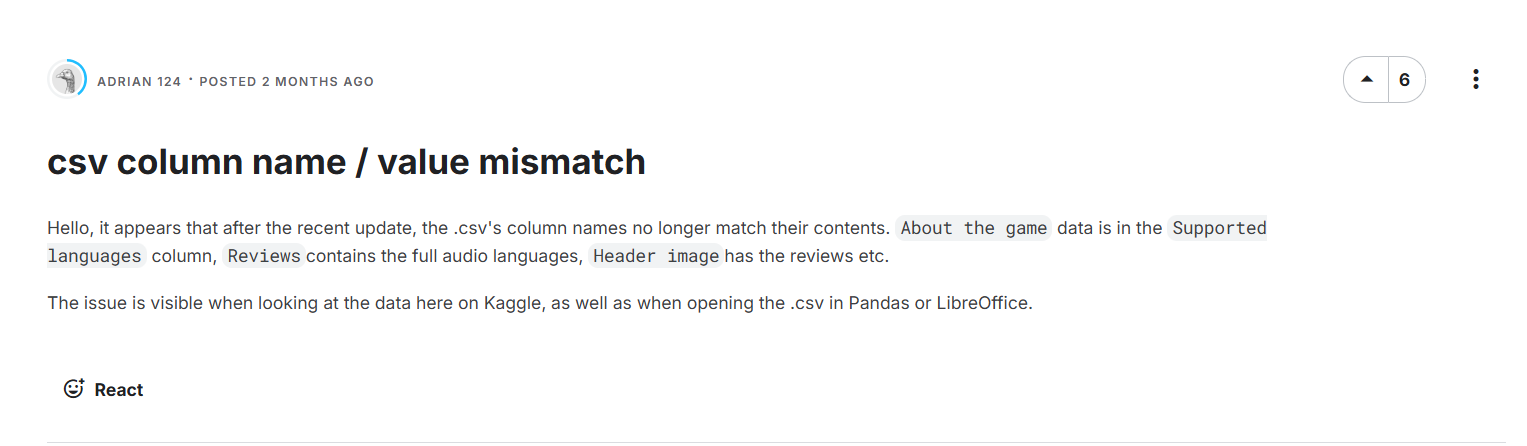



In the comments in this discussion, they mentioned that the json file did not have these errors, so given that we decided to try using the json file for our data analysis instead

###2.2.2 Loading JSON file and initial inspection

In [ ]:
# Try switching to json file instead
steam_json_df = pd.read_json("games.json")
# Transpose the dataframe back to correct orientation
# The initial JSON load resulted in games being columns instead of rows
steam_json_df = steam_json_df.T

In [ ]:
# Shape of dataframe
print("Dataset shape:", steam_json_df.shape)

Dataset shape: (97410, 41)


In [ ]:
# Dataframe column datatypes
print("\nData Types:\n", steam_json_df.dtypes)


Data Types:
 name                        object
release_date                object
required_age                object
price                       object
dlc_count                   object
detailed_description        object
about_the_game              object
short_description           object
reviews                     object
header_image                object
website                     object
support_url                 object
support_email               object
windows                     object
mac                         object
linux                       object
metacritic_score            object
metacritic_url              object
achievements                object
recommendations             object
notes                       object
supported_languages         object
full_audio_languages        object
packages                    object
developers                  object
publishers                  object
categories                  object
genres                      object
screen

In [ ]:
steam_json_df.head()

name  release_date required_age  price dlc_count  \
20200         Galactic Bowling  Oct 21, 2008            0  19.99         0   
655370            Train Bandit  Oct 12, 2017            0   0.99         0   
1732930           Jolt Project  Nov 17, 2021            0   4.99         0   
1355720               Henosis™  Jul 23, 2020            0   5.99         0   
1139950  Two Weeks in Painland   Feb 3, 2020            0    0.0         0   

                                      detailed_description  \
20200    Galactic Bowling is an exaggerated and stylize...   
655370   THE LAW!! Looks to be a showdown atop a train....   
1732930  Jolt Project: The army now has a new robotics ...   
1355720  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
1139950  ABOUT THE GAME Play as a hacker who has arrang...   

                                            about_the_game  \
20200    Galactic Bowling is an exaggerated and stylize...   
655370   THE LAW!! Looks to be a showdown atop a train....   
1732930  Jolt Project: The army now has a new robotics ...   
1355720  HENOSIS™ is a mysterious 2D Platform Puzzler w...   
1139950  ABOUT THE GAME Play as a hacker who has arrang...   

                                         short_description reviews  \
20200    Galactic Bowling is an exaggerated and stylize...           
655370   THE LAW!! Looks to be a showdown atop a train....           
1732930  Shoot vehicles, blow enemies with a special at...           
1355720  HENOSIS™ is a mysterious 2D Platform Puzzler w...           
1139950  Two Weeks in Painland is a story-driven game a...           

                                              header_image  \
20200    https://cdn.akamai.steamstatic.com/steam/apps/...   
655370   https://cdn.akamai.steamstatic.com/steam/apps/...   
1732930  https://cdn.akamai.steamstatic.com/steam/apps/...   
1355720  https://cdn.akamai.steamstatic.com/steam/apps/...   
1139950  https://cdn.akamai.steamstatic.com/steam/apps/...   

                                     website  \
20200         http://www.galacticbowling.net   
655370                http://trainbandit.com   
1732930                                        
1355720             https://henosisgame.com/   
1139950  https://www.unusual-games.com/home/   

                                    support_url  \
20200                                             
655370                                            
1732930                                           
1355720                https://henosisgame.com/   
1139950  https://www.unusual-games.com/contact/   

                           support_email windows    mac  linux  \
20200                                       True  False  False   
655370           support@rustymoyher.com    True   True  False   
1732930        ramoncampiaof31@gmail.com    True  False  False   
1355720             info@henosisgame.com    True   True   True   
1139950  welistentoyou@unusual-games.com    True   True  False   

        metacritic_score metacritic_url achievements recommendations  \
20200                  0                          30               0   
655370                 0                          12               0   
1732930                0                           0               0   
1355720                0                           0               0   
1139950                0                          17               0   

                                                     notes  \
20200                                                        
655370                                                       
1732930                                                      
1355720                                                      
1139950  This Game may contain content not appropriate ...   

                                       supported_languages  \
20200                                            [English]   
655370   [English, French, Italian, German, Spanish - S...   
1732930                     [Eng

Switching to the JSON file effectively resolved the column alignment issues present in the CSV format. The data loaded with the correct column structure, ensuring each attribute was accurately represented. Additionally, the JSON file provided three unique columns—"short_description", "detailed_description", and "packages"—that were not available in the CSV. However, this format brings its own set of challenges: all columns are currently of the 'object' data type, necessitating conversion to more appropriate types for analytical purposes. Moreover, the JSON data sets app_id as an index rather than a regular column, requiring an index reset. Despite these challenges, the JSON data provides a much more reliable foundation for analysis compared to the mismatched data in the CSV, making it a preferable choice. Thus, we decided to move ahead on this project using the json dataframe.

# Part 3: Initial Data Preprocessing

In this data preprocessing section, we performed index reset and column renaming, data type conversions, empty string handling, release date standardization, initial column dropping, and column explosion for list-type data. These preprocessing steps created a clean foundation for our subsequent exploratory data analysis.

In [ ]:
steam_df = steam_json_df.copy()

We decided to rename our dataframe steam_df, as this will be our main working dataframe throughout the analysis.

In [ ]:
# Index reset for app_id column
steam_df = steam_df.reset_index()
steam_df = steam_df.rename(columns={'index': 'app_id'})

##3.1 Column type conversions

As mentioned previously, all columns were initially type `object` in `steam_df`. Thus, we converted all columns to their appropriate types below so they could be used in analysis properly later on.

###3.1.1 Initial conversion attempt using CSV

As all columns in `steam_df` were intially of type object, we first tried to infer the types of each column in `steam_df` by looking at the corresponding column in `steam_csv_df`, as we thought `steam_csv_df` was well typed and we did not want to manually check each column.

In [ ]:
# Step 1: Standardize and rename columns in steam_csv_df to match steam_df naming convention
# This allows us to properly compare data types between the same columns that were named differently
steam_csv_df.columns = [col.lower().replace(' ', '_') for col in steam_csv_df.columns]

column_mapping = {
    'discountdlc_count': 'dlc_count',
    'median_playtime_two_weeks': 'median_playtime_2weeks',
    'appid': 'app_id',
    'average_playtime_two_weeks': 'average_playtime_2weeks'
}

steam_csv_df = steam_csv_df.rename(columns=column_mapping)

# Step 2: Compare data types between the two DataFrames
csv_dtypes = steam_csv_df.dtypes
json_dtypes = steam_df.dtypes

print("\nColumn Name                        CSV Type       JSON Type")
print("-" * 60)

for column in set(csv_dtypes.index).union(json_dtypes.index):
    csv_type = csv_dtypes.get(column, 'N/A')
    json_type = json_dtypes.get(column, 'N/A')
    print(f"{column:<30} {str(csv_type):<15} {str(json_type):<15}")


Column Name                        CSV Type       JSON Type
------------------------------------------------------------
full_audio_languages           object          object         
notes                          int64           object         
metacritic_url                 int64           object         
average_playtime_forever       object          object         
estimated_owners               object          object         
positive                       int64           object         
support_url                    object          object         
negative                       int64           object         
publishers                     object          object         
packages                       N/A             object         
linux                          bool            object         
tags                           object          object         
achievements                   float64         object         
user_score                     object          object      

After displaying the column types, we discovered that our initial assumption about the CSV having well-typed columns was incorrect - several columns had obviously wrong type assignments (e.g., `metacritic_url` and `about_the_game` were typed as `int64`). Thus, we decided to turn to the Kaggle documentation to manually determine and set the correct type for each column, despite this being more time-consuming than our initial approach.

###3.1.2 Data Type Conversions

Using the Kaggle JSON documentation, we implemented a straightforward type conversion strategy: basic data types (integers, floats, booleans, strings) were converted to their appropriate types, while complex data structures (lists and dictionaries) remained as `object` types. This approach allowed us to handle the data efficiently while minimizing potential issues. By focusing only on basic data type conversions, we avoided the complexities and potential errors that could arise from converting nested data structures. Additionally, keeping complex data as `object` types preserved their original structure for any future processing we might need to perform.

In [ ]:
type_conversions = {
    # Integer columns
    'int64': ['app_id', 'required_age', 'dlc_count', 'metacritic_score',
              'achievements', 'recommendations', 'positive', 'negative',
              'average_playtime_forever', 'average_playtime_2weeks',
              'median_playtime_forever', 'median_playtime_2weeks', 'peak_ccu'],

    # Float columns
    'float64': ['price'],

    # Boolean columns
    'boolean': ['windows', 'mac', 'linux'],

    # String columns
    'string': ['name', 'release_date', 'detailed_description', 'about_the_game',
               'short_description', 'reviews', 'header_image', 'website',
               'support_url', 'support_email', 'metacritic_url', 'notes',
               'estimated_owners', 'score_rank']
}

# Convert types
for dtype, columns in type_conversions.items():
    for col in columns:
        if col in steam_df.columns:
            try:
                steam_df[col] = steam_df[col].astype(dtype)
            except Exception as e:
                print(f"Error converting {col}: {e}")

# Print new types to verify
print("\nNew column types:")
print(steam_df.dtypes)


New column types:
app_id                               int64
name                        string[python]
release_date                string[python]
required_age                         int64
price                              float64
dlc_count                            int64
detailed_description        string[python]
about_the_game              string[python]
short_description           string[python]
reviews                     string[python]
header_image                string[python]
website                     string[python]
support_url                 string[python]
support_email               string[python]
windows                            boolean
mac                                boolean
linux                              boolean
metacritic_score                     int64
metacritic_url              string[python]
achievements                         int64
recommendations                      int64
notes                       string[python]
supported_languages                

After converting all columns' types using documentation, we saw that the `release_date` had type string as it was from a JSON file. Furthermore, through inspection below, we found inconsistent formatting of dates in the `release_date ` column. Thus, we decided to convert this column to datetime objects for consistent formatting and ease of use later in EDA.

In [ ]:
# Pattern for "MMM DD, YYYY" (e.g., "Sep 25, 2009")
full_date_pattern = r'^[A-Za-z]{3} \d{1,2}, \d{4}$'

# Pattern for "MMM YYYY" (e.g., "Jun 2019")
month_year_pattern = r'^[A-Za-z]{3} \d{4}$'

# Count how many of each format
full_date_count = steam_df['release_date'].str.match(full_date_pattern).sum()
month_year_count = steam_df['release_date'].str.match(month_year_pattern).sum()
total_rows = len(steam_df)

print(f"Full date format (MMM DD, YYYY): {full_date_count} rows ({(full_date_count/total_rows)*100:.1f}%)")
print(f"Month year format (MMM YYYY): {month_year_count} rows ({(month_year_count/total_rows)*100:.1f}%)")
print(f"Other formats: {total_rows - full_date_count - month_year_count} rows ({((total_rows - full_date_count - month_year_count)/total_rows)*100:.1f}%)")

# See examples of other formats if any
if total_rows - full_date_count - month_year_count > 0:
    other_formats = steam_df[~steam_df['release_date'].str.match(full_date_pattern) &
                           ~steam_df['release_date'].str.match(month_year_pattern)]
    print("\nExamples of other formats:")
    print(other_formats['release_date'].head())

# Convert dates to datetime
def standardize_date(date_str):
    if ',' in date_str:  # Full date format (MMM DD, YYYY)
        return pd.to_datetime(date_str)
    else:  # Month year format (MMM YYYY)
        return pd.to_datetime(date_str + " 1")  # Add day 1 to month-year format

# Convert dates using our custom function
steam_df['release_date'] = steam_df['release_date'].apply(standardize_date)

Full date format (MMM DD, YYYY): 97279 rows (99.9%)
Month year format (MMM YYYY): 131 rows (0.1%)
Other formats: 0 rows (0.0%)


In [ ]:
print(f"Type of release_date column: {steam_df['release_date'].dtype}")

Type of release_date column: datetime64[ns]


##3.2 Data Cleaning and Feature Selection


Our dataset, originating from JSON data, contained columns with various data types `int64`, `float64`, `str`, `datetime64`, and Python data structures like `list` and `dict`. This variety was expected given the diverse nature of game information, but presented several challenges in identifying true null values.

String values (`str` type) were our first consideration. Empty strings (`''`) were found in many columns, and through manual inspection, we determined these empty strings should be treated as null values. This was the most straightforward case to identify.

Numeric values (`int64` and `float64`) presented a more complex challenge. The value `0` appeared in multiple columns, and unlike empty strings, it was more challenging to determine whether a 0 represented a genuine zero value (e.g., a game having a `metacritic_score` of `0`) or missing/unavailable data. This required careful column-by-column investigation.

List values (`list` type) presented a unique case. Some columns contained empty lists (`[]`), but unlike empty strings, we determined these were meaningful. For example, an empty list in `full_audio_languages` likely meant no audio languages were supported, rather than missing data. These should be kept as is, not converted to null.

This variety in data types and null representations, common when working with JSON data, necessitated a careful approach to data cleaning. To streamline our null value analysis, we first decided to determine our success metric and remove post-release features. This reduced the number of columns requiring investigation for the null value patterns discussed above.

###3.2.1 Success Metric Determination

Initially, we considered using either `metacritic_score`, review data (using `positive`, `negative`, and `reviews` columns to calculate either review ratios or total review counts), or a blend of both as our primary success metric, as these are direct indicators of game quality and reception. These metrics would provide clear measures of game success through professional critic scores, user feedback, or a combination of both. However, before proceeding with this approach, we needed to check the availability of this data across our dataset. We chose to check `metacritic_url` rather than `metacritic_score` because the score column being int64 type could have ambiguous zeros, while the URL being a string type would clearly indicate missing data through empty strings. Similarly, the `reviews` column was also a string type, so we checked both columns for empty strings.

In [ ]:
# Check empty strings for metacritic_url and reviews
metacritic_missing = (steam_df['metacritic_url'] == '').sum()
reviews_missing = (steam_df['reviews'] == '').sum()

print(f"Games missing Metacritic data: {metacritic_missing}")
print(f"Games missing review  {reviews_missing}")

Games missing Metacritic data: 93457
Games missing review  87285


Given the substantial missing data (`93,457` games lacking Metacritic URLs/scores and `87,285` missing review data), we needed to pivot to an alternative success metric. We decided to select `median_playtime_forever` as our measure of success. We specifically chose median over average playtime because playtime data tends to be right-skewed (some players might accumulate thousands of hours while most play much less), and median better represents typical player engagement by being less sensitive to these extreme values.

Though we have an obvious flaw in this column due to ambiguous zeros, zeros either meaning the game has not been played at all or the data is missing. Steam documentation clarifies that playtime tracking is automatic, and thus zero either means never launched or launched but immediately closed - both clear indicators of lack of success. This makes `median_playtime_forever` a particularly reliable metric for our analysis, more so than the sparsely populated Metacritic scores and review data. We will therefore proceed with `median_playtime_forever` as our measure of success.

The specific threshold for defining success using this metric will be determined through our exploratory data analysis.

###3.2.2 Removal of post-release features


Now that we have determined our success metric, we can safely drop all post-release features (except for our chosen success metric `median_playtime_forever`). This will prevent data leakage in our model and streamline our subsequent null value analysis.

From our existing columns, we will drop the following post-release features to prevent data leakage in our predictive model:
- Review-related: `reviews`, `recommendations`, `positive`, `negative`, `user_score`, `score_rank`
- Metacritic  `metacritic_score`, `metacritic_url`
- Player statistics: `estimated_owners`, `peak_ccu`
- Playtime metrics (except our success metric): `average_playtime_forever`, `average_playtime_2weeks`, `median_playtime_2weeks`
- User-generated content: `notes`

These features all contain information that would only be available after a game's release. Our predictive model should only use pre-release information to determine success, measured by our chosen metric `median_playtime_forever`.

In [ ]:
# Drop post-release features while keeping our success metric (median_playtime_forever)
columns_to_drop = ['reviews', 'recommendations', 'positive', 'negative', 'user_score', 'score_rank',
                   'metacritic_score', 'metacritic_url', 'estimated_owners', 'peak_ccu',
                   'average_playtime_forever', 'average_playtime_2weeks', 'median_playtime_2weeks',
                   'notes']

columns_to_drop = [col for col in columns_to_drop if col in steam_df.columns]
steam_df = steam_df.drop(columns=columns_to_drop)

# Verify the columns were dropped
print("\nRemaining columns:")
print(steam_df.columns.tolist())


Remaining columns:
['app_id', 'name', 'release_date', 'required_age', 'price', 'dlc_count', 'detailed_description', 'about_the_game', 'short_description', 'header_image', 'website', 'support_url', 'support_email', 'windows', 'mac', 'linux', 'achievements', 'supported_languages', 'full_audio_languages', 'packages', 'developers', 'publishers', 'categories', 'genres', 'screenshots', 'movies', 'median_playtime_forever', 'tags']


Further analysis concluded that `dlc_count` and `achievements` are also post-release features. These columns represent information that becomes available only after the game's release, based on user behavior or developer updates. Including these features in the modeling process would introduce data leakage, as they rely on information that wouldn't be available at the time of prediction.

To maintain the integrity of our pre-release modeling framework, we are dropping the following columns:
- **`dlc_count`**: Represents the number of downloadable content items released for a game, which is a post-release feature.
- **`achievements`**: Represents the number of achievements available in a game, which is determined post-release.


In [ ]:
# List of additional columns to drop
additional_columns_to_drop = ['dlc_count', 'achievements']

# Drop the additional columns
steam_df.drop(columns=additional_columns_to_drop, inplace=True)


In addition to features that were generated after release, we also considered features that could be modified post-release, as these could lead to data leakage in our model. Specifically, we dropped the following support-related features:

- **Support channels:** `website`, `support_url`, `support_email`

The reasoning behind dropping these features was distinct from the other post-release features. While these fields were part of the initial Steam store page setup, they could be updated by developers at any time after release. This created potential data leakage because the values might reflect modifications made in response to the game's success or failure, rather than its initial launch state.

To maintain the predictive integrity of our model, it was crucial to focus on features that were fixed at release time and could not be influenced by the game's subsequent performance. By excluding these modifiable features, we ensured that our model was based solely on pre-release information.

In [ ]:
# Drop modifiable post-release features
modifiable_columns = ['website', 'support_url', 'support_email']

modifiable_columns = [col for col in modifiable_columns if col in steam_df.columns]
steam_df = steam_df.drop(columns=modifiable_columns)

# Verify the columns were dropped
print("\nRemaining columns:")
print(steam_df.columns.tolist())


Remaining columns:
['app_id', 'name', 'release_date', 'required_age', 'price', 'dlc_count', 'detailed_description', 'about_the_game', 'short_description', 'header_image', 'windows', 'mac', 'linux', 'achievements', 'supported_languages', 'full_audio_languages', 'packages', 'developers', 'publishers', 'categories', 'genres', 'screenshots', 'movies', 'median_playtime_forever', 'tags']


###3.2.3 Null Value Conversion

As mentioned previously at the start of this section, our dataset from JSON data contained various data types (`int64`, `float64`, `str`, `datetime64`, `lists`, and `dicts`), each potentially representing null values differently. Having determined our success metric and removed post-release features, we then proceeded to systematically convert inappropriate "empty" values to null across our dataset.

In [ ]:
# Check the types of our dataset
steam_df.dtypes

app_id                              int64
name                       string[python]
release_date               datetime64[ns]
required_age                        int64
price                             float64
dlc_count                           int64
detailed_description       string[python]
about_the_game             string[python]
short_description          string[python]
header_image               string[python]
windows                           boolean
mac                               boolean
linux                             boolean
achievements                        int64
supported_languages                object
full_audio_languages               object
packages                           object
developers                         object
publishers                         object
categories                         object
genres                             object
screenshots                        object
movies                             object
median_playtime_forever             int64
tags                               object
dtype: object

#### String type

We first focused on columns with string type (`str`), because as previously mentioned empty strings (`''`) in these columns represented missing data and should be treated as null values, so we could easily convert for the `str` type.

In [ ]:
# Convert empty strings to NaN for these specific string columns
string_columns = ['name', 'detailed_description', 'about_the_game',
                 'short_description', 'header_image']

# Convert empty strings to NaN
steam_df[string_columns] = steam_df[string_columns].replace('', np.nan)

# Verify the changes - should now show these as null values
print("Number of null values after conversion:")
for col in string_columns:
    null_count = steam_df[col].isnull().sum()
    print(f"{col}: {null_count} null values")

Number of null values after conversion:
name: 6 null values
detailed_description: 4848 null values
about_the_game: 4870 null values
short_description: 4779 null values
header_image: 0 null values


#### Boolean type

Next, for boolean columns, we decided to check for any values that were neither `True` nor `False`, as these would indicate missing or invalid boolean data.

In [ ]:
bool_columns = ['windows', 'mac', 'linux']

for col in bool_columns:
    print(f"\nUnique values in {col}:")
    print(steam_df[col].value_counts(dropna=False))  # dropna=False will show NaN if presentsteam_df


Unique values in windows:
windows
True     97378
False       32
Name: count, dtype: Int64

Unique values in mac:
mac
False    79674
True     17736
Name: count, dtype: Int64

Unique values in linux:
linux
False    85078
True     12332
Name: count, dtype: Int64


As we can see, all boolean columns contained only True and False values, with counts summing to 97410 (our total number of rows) for each column. Therefore, no null conversion was necessary.

#### Numerical(int and float) types

For our numerical columns (all integer except `price` which is float), we analyzed potential null values as follows:

`median_playtime_forever` was our success metric and had already been addressed in our earlier analysis.

`app_id`, `price`, and `required_age` had to be set when publishing any game on Steam's platform. `app_id` served as a unique identifier, `price` had to be explicitly set (even if free), and `required_age` was necessary for regulatory compliance. Therefore, these fields could not contain missing values.

For `achievements` and `dlc_count`, a value of 0 could theoretically have represented either missing data or a true absence of achievements/DLCs. However, since this information would be automatically tracked in Steam's system when achievements or DLCs existed, a missing value would effectively mean the same thing as having none. Therefore, treating 0s as legitimate values was appropriate in both cases.

Thus, we did not need to perform null value conversion on any of these numerical columns.

#### Object(List and Dict) Types

Lastly,  as mentioned previously, from looking at the documentation and the dataframe, we found that for list and dictionary types, an empty list or dictionary represented a legitimate absence of elements (e.g., no supported languages, no screenshots, no developers listed) rather than missing data as discussed previously. Thus, we did not have to do any null conversion for these columns.

###3.2.4 Dropping Null Values

Now that we had converted all missing values to null in our dataframe, we could decide which rows/columns to drop based on their null value counts. Based on the previous section, we only needed to examine the string columns since none of the other column types (numerical, boolean, and object) required null value conversion.

In [ ]:
string_columns = ['name', 'detailed_description', 'about_the_game',
                 'short_description', 'header_image']

null_counts = steam_df[string_columns].isnull().sum()
null_percentages = (steam_df[string_columns].isnull().sum() / len(steam_df)) * 100

for col in string_columns:
    print(f"{col}: {null_counts[col]} null values ({null_percentages[col]:.2f}%)")

name: 6 null values (0.01%)
detailed_description: 4848 null values (4.98%)
about_the_game: 4870 null values (5.00%)
short_description: 4779 null values (4.91%)
header_image: 0 null values (0.00%)


First, we decided to remove rows with missing game names (6 rows) as these represented incomplete or invalid entries. Additionally, we noticed that approximately 5% of the data had missing descriptions (`detailed_description`, `about_the_game`, and `short_description`). The nearly identical percentages across these description columns suggested these were the same low-quality entries - games that didn't even have basic descriptive information were likely placeholder entries or very low-effort submissions. Removing these rows would improve our data quality while only losing about 5% of our data, which was an acceptable trade-off.

In [ ]:
# Remove rows where name or any description field is null
rows_to_drop = ['name', 'detailed_description', 'about_the_game', 'short_description']

# Print the number of rows removed
rows_before = len(steam_df)
steam_df = steam_df.dropna(subset=rows_to_drop)
rows_after = len(steam_df)

print(f"Number of rows before: {rows_before}")
print(f"Number of rows after: {rows_after}")
print(f"Number of rows removed: {rows_before - rows_after}")

Number of rows before: 97410
Number of rows after: 92535
Number of rows removed: 4875


Next, we decided to remove the `header_image` column from our dataset. While this column had zero null values (meaning every game had a header image), this actually limited its usefulness as a feature - we couldn't even feature engineer it into something like "has_header_image" since it would be True for all games. Additionally, since the column contained only URLs pointing to game header images and we weren't planning to perform any image analysis or access these URLs, keeping this column would only add unnecessary bulk to our dataset without contributing to our insights. This was a straightforward cleanup decision to maintain a more focused and efficient dataset.

In [ ]:
# Drop header_image column as it provides no analytical value
steam_df = steam_df.drop('header_image', axis=1)

###3.2.5 Duplicate Handling

In this section, we examine our dataset for duplicate entries using two different approaches: checking for completely duplicate rows and identifying games with duplicate names. Due to the complexity of comparing list and dictionary data types, we excluded object-type columns from our duplicate row analysis.

In [ ]:
# Check for complete duplicates (excluding object type columns which contain lists/dicts)
non_object_cols = steam_df.select_dtypes(exclude=['object']).columns
print("Complete duplicates:", steam_df[non_object_cols].duplicated().sum())

# Check for duplicate games by name
print("\nDuplicate game names:", steam_df['name'].duplicated().sum())

Complete duplicates: 0

Duplicate game names: 874


From our duplicate analysis, we found no completely identical rows when comparing non-object columns. However, we identified 874 games with duplicate names, approximately 0.94% of our dataset. We decided to take a closer look at these duplicate game names to determine whether dropping duplicates would be appropriate for our analysis.

In [ ]:
# Look at a few examples of duplicate games
duplicate_mask = steam_df['name'].duplicated(keep=False)
duplicate_games = steam_df[duplicate_mask].sort_values('name')

# Display a few examples focusing on key differences
print("Example of duplicate games:")
print(duplicate_games[['name', 'app_id', 'price', 'release_date']].head(6))

# Show game with most duplicates
print("\nGame with most duplicates:")
most_duplicated = steam_df['name'].value_counts().head(5)
print(most_duplicated)

Example of duplicate games:
                      name   app_id  price release_date
15733   3D Organon Anatomy  1099550   0.00   2019-07-17
40882   3D Organon Anatomy   583620  24.99   2017-06-23
58867  A Walk in the Woods   557900   0.00   2020-04-21
13384  A Walk in the Woods   842420   0.00   2018-05-01
14510                ALONE  1826070   8.99   2021-12-23
40121                ALONE  1544540   0.79   2021-05-31

Game with most duplicates:
name
Shadow of the Tomb Raider: Definitive Edition    20
Alone                                             6
Hide and Seek                                     5
Aurora                                            5
Escape                                            5
Name: count, dtype: Int64


Our examination of duplicate game names revealed several important patterns. Some games had an unusually high number of duplicates (e.g., `"Shadow of the Tomb Raider: Definitive Edition"` appeared `20` times), suggesting data quality issues. Looking at specific examples, we found cases where the same game had different pricing/versions (`3D Organon Anatomy` at `$0` and `$24.99`) and cases where different games entirely shared the same name (like `"ALONE"` with different developers and prices). Given that these duplicates represented only `0.94%` of our dataset (`874` out of `92,535` entries), and properly distinguishing between legitimate variants and problematic duplicates would be time-consuming, we proceeded with removing all but the first occurrence of each game name. While this approach might have removed some legitimately different games that shared names, the small scale of this cleanup (< `1%` of data) made this trade-off acceptable for maintaining a cleaner dataset.

In [ ]:
# Remove duplicate game names (keeping first occurrence)
steam_df = steam_df.drop_duplicates(subset=['name'], keep='first')

# Verify removal
print(f"Rows after duplicate removal: {len(steam_df)}")

Rows after duplicate removal: 91661


###3.2.6 Feature Removal

In this phase of data preprocessing, we identified several columns for removal based on their limited analytical value within the scope of our success prediction model.

Three description columns (`detailed_description`, `about_the_game`, `short_description`) were identified for removal. Since we are not engaging in Natural Language Processing (NLP) tasks, these textual fields don't provide quantifiable features for our predictive model. Additionally, while we have already handled null values in these columns, they cannot be transformed into usable features without NLP techniques, making their removal a logical step to simplify our dataset.

The multimedia columns (`screenshots` and `movies`) were also targeted for removal. These fields contain links to images and videos on the Steam store page. Since we are not conducting any image or video processing in our analysis, these columns provide no actionable value for our predictive modeling efforts.

By removing these columns, we ensure our dataset remains focused on directly usable features while maintaining its analytical integrity. This streamlined approach aligns with our project scope and analytical objectives, though these decisions could be revisited if future analysis requires NLP or multimedia processing capabilities.

In [ ]:
# Drop description and multimedia columns
columns_to_drop = [
    'detailed_description',
    'about_the_game',
    'short_description',
    'screenshots',
    'movies'
]

# Drop the columns
steam_df = steam_df.drop(columns=columns_to_drop)

# Verify the columns were dropped
print("Shape after dropping columns:", steam_df.shape)
print("\nRemaining columns:")
print(steam_df.columns.tolist())

Shape after dropping columns: (91661, 19)

Remaining columns:
['app_id', 'name', 'release_date', 'required_age', 'price', 'dlc_count', 'windows', 'mac', 'linux', 'achievements', 'supported_languages', 'full_audio_languages', 'packages', 'developers', 'publishers', 'categories', 'genres', 'median_playtime_forever', 'tags']


# Part 4: EDA and Feature Engineering


In this section, we focused on performing exploratory data analysis (EDA) and feature engineering to better understand the dataset and prepare it for modeling. We specifically explored the following columns:

1. **Success Metric:** Investigated the distribution of successful and unsuccessful games based on our defined threshold (median playtime over one hour).
2. **Release Date:** Analyzed the temporal trends to see how the year and month of release impacted game success.
3. **Language Support:** Explored the availability of supported languages and engineered a language tier classification.
4. **Genre:** Examined the variety and distribution of genres to understand their role in game success.
5. **Category:** Investigated game categories to identify their contribution to game performance.
6. **OS Support:** Evaluated platform availability (Windows, macOS, Linux) and its potential impact on game success.
7. **Price:** Analyzed pricing trends, categorized price ranges, and explored their relationship with success.
8. **Required Age:** Explored age restrictions and their influence on player engagement and game success.

Each feature was analyzed and transformed where necessary to extract meaningful insights and ensure compatibility with our modeling framework.



## 4.1 Success Metric Threshold Analaysis and Implementation

In this section, we decided to choose our success metric threshold in the EDA section after conducting thorough analysis. We prioritized this analysis and transformation before any other exploratory data analysis because having a well-defined success metric was crucial—it served as our target variable and informed all subsequent analyses.

While establishing a binary success metric was essential for focused analysis and modeling, we also retained the original `median_playtime_forever` column to conduct nuanced analyses where the actual playtime values were important. This dual approach enabled us to explore relationships between various features and game success in both detailed and simplified ways, ensuring a comprehensive and meaningful EDA throughout the rest of the project.

###4.1.1 Success Metric Threshold Analysis


In [ ]:
# Count games in different playtime categories
zero_playtime = len(steam_df[steam_df['median_playtime_forever'] == 0])
under_30_mins = len(steam_df[(steam_df['median_playtime_forever'] > 0) &
                                        (steam_df['median_playtime_forever'] < 30)])
thirty_to_60_mins = len(steam_df[(steam_df['median_playtime_forever'] >= 30) &
                                            (steam_df['median_playtime_forever'] < 60)])
sixty_to_90_mins = len(steam_df[(steam_df['median_playtime_forever'] >= 60) &
                                           (steam_df['median_playtime_forever'] < 90)])
ninety_to_120_mins = len(steam_df[(steam_df['median_playtime_forever'] >= 90) &
                                             (steam_df['median_playtime_forever'] < 120)])
over_120_mins = len(steam_df[steam_df['median_playtime_forever'] >= 120])

total_games = len(steam_df)

# Print out results
print(f"Total games: {total_games}")
print(f"Games with zero playtime: {zero_playtime} ({(zero_playtime/total_games)*100:.1f}%)")
print(f"Games played 1-29 minutes: {under_30_mins} ({(under_30_mins/total_games)*100:.1f}%)")
print(f"Games played 30-59 minutes: {thirty_to_60_mins} ({(thirty_to_60_mins/total_games)*100:.1f}%)")
print(f"Games played 60-89 minutes: {sixty_to_90_mins} ({(sixty_to_90_mins/total_games)*100:.1f}%)")
print(f"Games played 90-119 minutes: {ninety_to_120_mins} ({(ninety_to_120_mins/total_games)*100:.1f}%)")
print(f"Games played 120+ minutes: {over_120_mins} ({(over_120_mins/total_games)*100:.1f}%)")

# Also print out cumulative numbers for key thresholds
print("\nCumulative success rates at different thresholds:")
print(f"60+ minutes: {len(steam_df[steam_df['median_playtime_forever'] >= 60])} ({(len(steam_df[steam_df['median_playtime_forever'] >= 60])/total_games)*100:.1f}%)")
print(f"90+ minutes: {len(steam_df[steam_df['median_playtime_forever'] >= 90])} ({(len(steam_df[steam_df['median_playtime_forever'] >= 90])/total_games)*100:.1f}%)")
print(f"120+ minutes: {len(steam_df[steam_df['median_playtime_forever'] >= 120])} ({(len(steam_df[steam_df['median_playtime_forever'] >= 120])/total_games)*100:.1f}%)")

Total games: 91661
Games with zero playtime: 76771 (83.8%)
Games played 1-29 minutes: 2264 (2.5%)
Games played 30-59 minutes: 1219 (1.3%)
Games played 60-89 minutes: 855 (0.9%)
Games played 90-119 minutes: 771 (0.8%)
Games played 120+ minutes: 9781 (10.7%)

Cumulative success rates at different thresholds:
60+ minutes: 11407 (12.4%)
90+ minutes: 10552 (11.5%)
120+ minutes: 9781 (10.7%)


Above, we analyzed the distribution of `median_playtime_forever` to determine appropriate thresholds for our success metric. From the results that we got, we decided that defining success as `median_playtime_forever` of 60 minutes or more was an appropriate threshold. This threshold offered a balanced approach by capturing games that had achieved a significant level of player engagement without being overly restrictive. Approximately 12.4% of the games in our dataset met this criterion, providing a sufficient sample size for robust modeling. A 60-minute playtime indicated that players had invested enough time to experience the game's core mechanics, suggesting genuine interest beyond mere curiosity. This threshold aligned with our goal of identifying games that resonated with players while allowing for meaningful insights into the factors that contributed to reaching this engagement level.

The changes maintain the same clear reasoning while properly reflecting that this analysis was performed in the past. Would you like me to suggest any other adjustments to the paragraph?

###4.1.2 Success Metric Threshold Implementation

Based on our threshold analysis, we created a binary success metric while retaining the original `median_playtime_forever` column. This allowed us to maintain both a simplified classification of success and the granular playtime data for our subsequent analyses.

In [ ]:
# Create binary success metric based on 60-minute threshold
steam_df['is_successful'] = (steam_df['median_playtime_forever'] > 60).astype(int)

# Verify both metrics are available
print("\nFirst few rows showing both metrics:")
print(steam_df[['median_playtime_forever', 'is_successful']].head())

# Check success rate distribution if what we saw above
print("\nSuccess rate distribution:")
print(steam_df['is_successful'].value_counts(normalize=True))


First few rows showing both metrics:
   median_playtime_forever  is_successful
0                        0              0
1                        0              0
2                        0              0
3                        0              0
4                        0              0

Success rate distribution:
is_successful
0    0.875967
1    0.124033
Name: proportion, dtype: float64


##4.2 Release Date Column EDA

We decided not to use the raw release date as a predictor variable in our model, as this would essentially turn our analysis into a time series problem. Additionally, using historical release dates wouldn't provide actionable insights for developers, as they can only release games in the present or future.

Instead, we chose to explore established release windows in the gaming industry. Research shows that game releases often align with specific periods throughout the year. The Holiday Season (Mid-November to December) typically coincides with Black Friday, Christmas shopping, and winter break, while Summer Break (June-August) captures the period when students have more free time and is particularly popular for indie releases. The Back to School period (Late August-September) represents another major window, especially for sports games, and the Spring Release window (March-April) is a popular period after the holiday season lull. Any remaining months were categorized as Off Peak periods.

By transforming release dates into these industry-recognized periods, we aimed to investigate whether certain release windows showed higher success rates for game launches, providing actionable insights for developers planning their release timing.

In [ ]:
# Define release window categories based on gaming industry seasonality
def get_gaming_period(month):
    if month in [11, 12]:
        return 'Holiday Season'
    elif month in [6, 7, 8]:
        return 'Summer Break'
    elif month in [8, 9]:
        return 'Back to School'
    elif month in [3, 4]:
        return 'Spring Release'
    else:
        return 'Off Peak'

# Create release window features and analyze success rates
steam_df['release_month'] = pd.to_datetime(steam_df['release_date']).dt.month
steam_df['release_window'] = steam_df['release_month'].apply(get_gaming_period)

overall_success_rate = steam_df['is_successful'].mean()

# Calculate success metrics per release window
window_analysis = steam_df.groupby('release_window').agg({
    'is_successful': ['mean', 'count']
}).round(4)

window_analysis.columns = ['success_rate', 'total_games']
window_analysis['relative_to_baseline'] = ((window_analysis['success_rate'] - overall_success_rate) /
                                         overall_success_rate * 100).round(2)

print(f"\nOverall baseline success rate: {overall_success_rate:.4f}")
print("\nRelease Window Analysis:")
print(window_analysis.sort_values('success_rate', ascending=False))


Overall baseline success rate: 0.1240

Release Window Analysis:
                success_rate  total_games  relative_to_baseline
release_window                                                 
Back to School        0.1442         7135                 16.26
Spring Release        0.1295        15662                  4.41
Off Peak              0.1256        30183                  1.26
Holiday Season        0.1212        14649                 -2.28
Summer Break          0.1142        24032                 -7.93


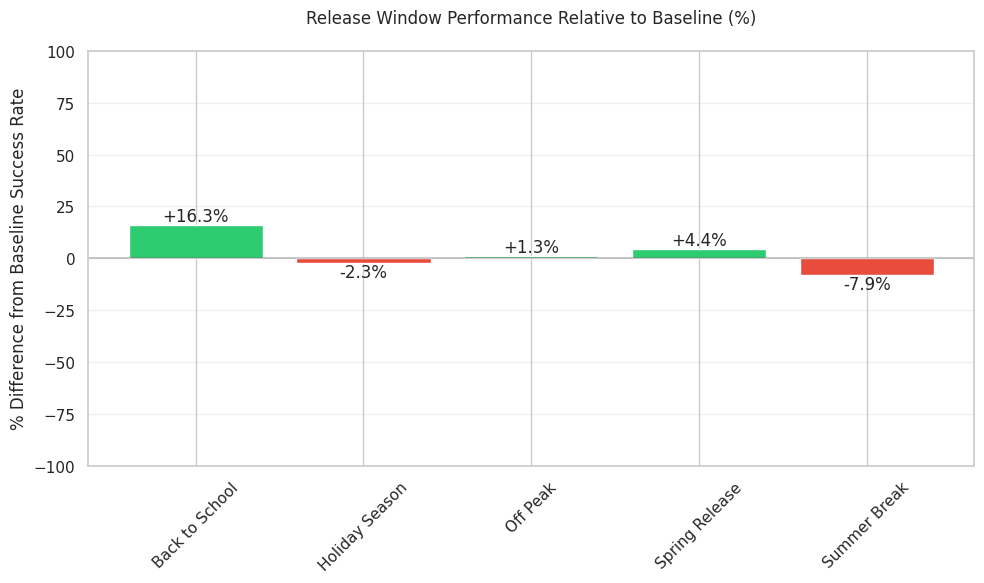

In [ ]:
# Set up the visualization
plt.figure(figsize=(10, 6))
colors = ['#2ecc71' if x > 0 else '#e74c3c' for x in window_analysis['relative_to_baseline']]

# Create bar plot showing release window performance vs baseline
bars = plt.bar(window_analysis.index, window_analysis['relative_to_baseline'], color=colors)

# Configure plot elements
plt.title('Release Window Performance Relative to Baseline (%)', pad=20)
plt.ylabel('% Difference from Baseline Success Rate')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.2)
plt.grid(True, axis='y', alpha=0.3)
plt.ylim(-100, 100)  # Set range to contextualize the differences

# Add percentage labels to bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height, f'{height:+.1f}%',
             ha='center', va='bottom' if height > 0 else 'top')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Our investigation into release timing revealed some interesting patterns in game success rates. While we observed extremes ranging from +16.26% (Back to School) to -7.93% (Summer Break), most release windows clustered fairly close to the baseline. Spring Release (+4.41%), Off Peak (+1.26%), and Holiday Season (-2.28%) all performed similarly, suggesting that release timing had a moderate but not dramatic impact on success rates.

The case for including release windows had been reasonable - the differences between extreme windows were meaningful, representing a 3 percentage point absolute difference (or 25% relative to baseline). Additionally, implementing this feature would have been straightforward, requiring only five categorical variables through one-hot encoding. However, the clustering of three windows near the baseline suggested that the timing effect wasn't consistently strong across all periods.

After weighing these factors, we decided not to include release timing in our predictive model, opting to maintain model simplicity and focus on features showing more consistent relationships with success. While this feature could have been viable, we believed other factors would provide stronger predictive power. The analysis still offered valuable insights for launch planning, even if not used directly in our model.

As a result, we dropped the release_date column entirely, as we had decided against both the release window categorization and any time series analysis of the original dates.

In [ ]:
# Drop release_date column as we decided against both release windows and time series analysis
steam_df = steam_df.drop(['release_date', 'release_month', 'release_window'], axis=1)

##4.3 Languages EDA and Feature Engineering

In this section, we focused on the exploratory data analysis and feature engineering of two language-related columns: `supported_languages` and `full_audio_languages`. Both columns contained list-type data, necessitating initial exploration of their contents to inform our feature engineering decisions. After conducting EDA on these lists, we implemented two key transformations: (1) converting `supported_languages` into a tiered classification system (`language_support_tier`) with five distinct levels, and (2) transforming `full_audio_languages` into a binary feature (`has_audio`) indicating the presence or absence of audio language support.

In [ ]:
# Display a few games and their language support
print("Example 1:")
print("Supported Languages:", steam_df['supported_languages'].iloc[0])
print("Full Audio Languages:", steam_df['full_audio_languages'].iloc[0])

print("\nExample 2:")
print("Supported Languages:", steam_df['supported_languages'].iloc[1])
print("Full Audio Languages:", steam_df['full_audio_languages'].iloc[1])

# Check if full_audio is always a subset of supported
def check_audio_subset(row):
    return all(lang in row['supported_languages'] for lang in row['full_audio_languages'])

# Check first ten rows for subset theory
subset_check = steam_df.head(10).apply(check_audio_subset, axis=1)
print("\nIs full audio always a subset of supported languages?")
print(subset_check.value_counts())

Example 1:
Supported Languages: ['English']
Full Audio Languages: []

Example 2:
Supported Languages: ['English', 'French', 'Italian', 'German', 'Spanish - Spain', 'Japanese', 'Portuguese - Brazil', 'Russian', 'Simplified Chinese', 'Traditional Chinese']
Full Audio Languages: []

Is full audio always a subset of supported languages?
True    10
Name: count, dtype: int64


Fist, we examined sample entries of both columns and also verified that `full_audio_languages` is always a subset of `supported_languages`, confirming our data's logical consistency.

In [ ]:
# Count the number of empty lists in the full_audio_languages column
empty_audio_count = steam_df['full_audio_languages'].apply(lambda x: len(x) == 0).sum()

print(f"Number of entries with empty full audio languages: {empty_audio_count}")

# Count the number of empty lists in the full_audio_languages column
empty_language_count = steam_df['supported_languages'].apply(lambda x: len(x) == 0).sum()

print(f"Number of entries with empty supported languages: {empty_language_count}")

Number of entries with empty full audio languages: 51746
Number of entries with empty supported languages: 84


Next, we decided to examine how many games lacked audio or language support. Initial counts revealed 51,746 games without audio support—a finding we planned to revisit during feature engineering. More pressingly, we identified 84 games that supposedly had no language support at all, which warranted immediate investigation since this seemed logically improbable for any Steam game.

In [ ]:
# Get a sample of games with empty supported languages
empty_supported = steam_df[steam_df['supported_languages'].apply(len) == 0]

# Display relevant information about these games
print(f"Total games with no supported languages: {len(empty_supported)}")
print("\nSample of games with empty supported languages:")
empty_supported.head(5)

Total games with no supported languages: 84

Sample of games with empty supported languages:


app_id          name  required_age  price  dlc_count  windows    mac  \
4542    855060   Huawei VR 2             0   0.00          0     True  False   
4846   1486720       HandsON             0   8.99          1     True  False   
6700    654970  Numberline 2             0   1.99          0     True  False   
11269  1184960    Escalation             0   4.99          0     True  False   
18578  1092950        Piposh             0  44.99          1     True   True   

       linux  achievements supported_languages full_audio_languages  \
4542   False             0                  []                   []   
4846   False             0                  []                   []   
6700   False            60                  []                   []   
11269  False             0                  []                   []   
18578   True            31                  []                   []   

                                                packages  \
4542   [{'title': 'Buy Huawei VR 2', 'description': '...   
4846   [{'title': 'Buy HandsON', 'description': '', '...   
6700   [{'title': 'Buy Numberline 2', 'description': ...   
11269  [{'title': 'Buy Escalation', 'description': ''...   
18578  [{'title': 'Buy Piposh', 'description': '', 's...   

                                      developers  \
4542                                          []   
4846   [Another Kind of Blue, Dutch Tilt Studio]   
6700                      [V34D4R, Egor Magurin]   
11269                            [Hubert Dzikuć]   
18578                               [Guillotine]   

                                publishers  \
4542                                    []   
4846                [Another Kind of Blue]   
6700                     [Indovers Studio]   
11269  [Icebreaker Interactive (Bankrupt)]   
18578                         [Guillotine]   

                                categories                      genres  \
4542                                    []                          []   
4846                       [Single-player]         [Adventure, Casual]   
6700                       [Single-player]             [Casual, Indie]   
11269                                   []              [Early Access]   
18578  [Single-player, Steam Achievements]  [Adventure, Casual, Indie]   

       median_playtime_forever  \
4542                         0   
4846                         0   
6700                         0   
11269                        0   
18578                        0   

                                                    tags  is_successful  
4542                                                  []              0  
4846                                                  []              0  
6700                         {'Indie': 27, 'Casual': 21}              0  
11269  {'Strategy': 47, 'Action': 46, 'Indie': 46, 'E...              0  
18578  {'Indie': 249, 'Point & Click': 223, 'Satire':...              0

In [ ]:
# Find games that are missing critical information
suspicious_games = steam_df[
    (steam_df['supported_languages'].apply(len) == 0) &
    (steam_df['categories'].apply(len) == 0) &
    (steam_df['genres'].apply(len) == 0)
]

print(f"Number of suspicious games (no languages, categories, AND genres): {len(suspicious_games)}")

# Remove these suspicious entries
steam_df_cleaned = steam_df[
    ~((steam_df['supported_languages'].apply(len) == 0) &
      (steam_df['categories'].apply(len) == 0) &
      (steam_df['genres'].apply(len) == 0))
]

print(f"\nRows removed: {len(steam_df) - len(steam_df_cleaned)}")

Number of suspicious games (no languages, categories, AND genres): 8

Rows removed: 8


 Upon inspection, some games appeared legitimate, featuring proper metadata like categories, genres, and developer information. However, a subset of these entries exhibited suspicious patterns, with empty lists across multiple fields, including supported_languages, categories, and genres. To ensure data quality without overly aggressive removal, we decided to filter out only the most problematic cases. Specifically, we removed 8 games that had empty lists for all three critical fields—languages, categories, and genres. This targeted approach allowed us to enhance data quality while preserving valid entries that merely lacked language data. As a result, we removed only 0.009% of the dataset, ensuring our analysis remains robust and reliable.

Next, we decided to examine the `full_audio_languages` column more closely, specifically the distribution to decide our feature engineering approach.

Percentage of games with no audio languages: 56.45%


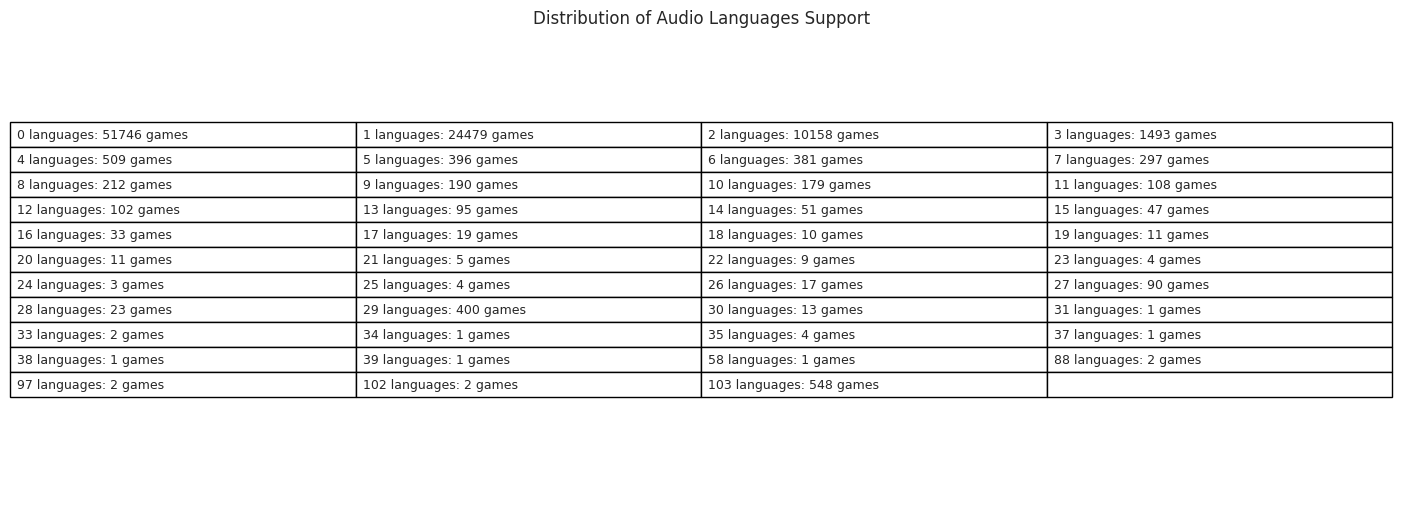

In [ ]:
# Calculate audio language distributions
audio_counts = steam_df['full_audio_languages'].apply(len).value_counts().sort_index()
total_games = len(steam_df)
games_no_audio = len(steam_df[steam_df['full_audio_languages'].apply(len) == 0])
percent_no_audio = (games_no_audio / total_games) * 100

# Print summary statistics
print(f"Percentage of games with no audio languages: {percent_no_audio:.2f}%")

# Display distribution table
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_position([0, 0, 1, 0.95])
plt.axis('off')

# Transform data for 4-column layout
data = [(count, value) for count, value in audio_counts.items()]
n = len(data)
rows = np.ceil(n/4).astype(int)
cell_text = [['' for _ in range(4)] for _ in range(rows)]

for i in range(n):
    row = i // 4
    col = i % 4
    cell_text[row][col] = f"{data[i][0]} languages: {data[i][1]} games"

# Configure and style table
table = plt.table(cellText=cell_text,
                 loc='center',
                 cellLoc='left',
                 edges='closed',
                 colWidths=[0.24, 0.24, 0.24, 0.24])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for cell in table._cells.values():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')
    cell.set_text_props(wrap=True)
    cell.PAD = 0.02

plt.title('Distribution of Audio Languages Support', y=0.98)
plt.show()

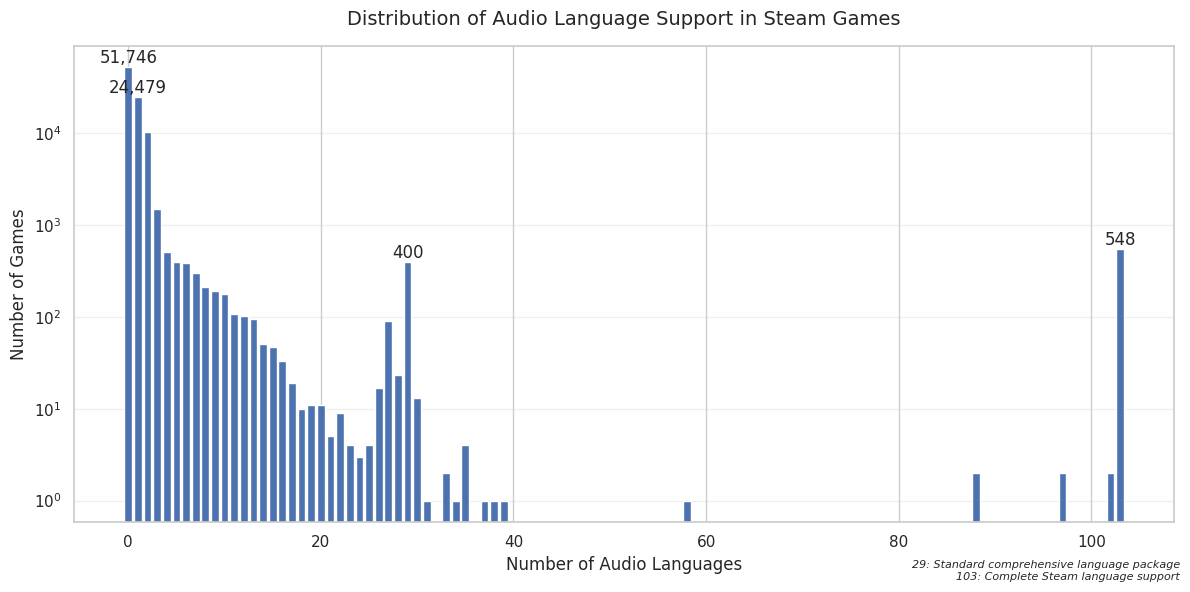

In [ ]:
# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create the figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Get the counts
audio_counts = steam_df['full_audio_languages'].apply(len).value_counts().sort_index()

# Create bar plot
bars = ax.bar(audio_counts.index, audio_counts.values)

# Customize the plot
plt.title('Distribution of Audio Language Support in Steam Games', fontsize=14, pad=15)
plt.xlabel('Number of Audio Languages', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)

# Add annotations for key points
for i in [0, 1, 29, 103]:
    if i in audio_counts.index:
        count = audio_counts[i]
        ax.text(i, count, f'{count:,}', ha='center', va='bottom')

# Add grid for better readability
ax.grid(True, axis='y', alpha=0.3)

# Adjust y-axis to log scale to better show the distribution
ax.set_yscale('log')

# Add explanatory text for spikes
plt.figtext(0.99, 0.02,
            '29: Standard comprehensive language package\n103: Complete Steam language support',
            ha='right', fontsize=8, style='italic')

plt.tight_layout()
plt.show()

To analyze the distribution, we first examined basic statistics, including the percentage of games with no audio support, and created a tabular display showing counts for each number of languages. While informative, the table format didn't provide clear visual insights into the distribution patterns. This led us to create a logarithmic scale bar graph, which better illustrated the dramatic skew in our data.

The visualization revealed compelling patterns that guided our feature engineering decision. We opted to binary encode this column into `has_audio` for several key reasons. First, the data transformation was necessary because the original format (lists of languages) wasn't suitable for machine learning models, which require numerical inputs. Second, the distribution patterns showed a strong skew where 56% of games had no audio, 27% had single language support, and only 17% had two or more languages. Given this heavy skew, the presence/absence of audio likely carries more predictive power than the specific number of languages supported. Additionally, using a binary feature instead of the raw count simplifies our model while retaining the most important signal - whether a game invests in audio support at all, which could be a stronger indicator of game quality and development investment than the specific number of languages supported.

In [ ]:
# Binary encoding below
steam_df['has_audio'] = (steam_df['full_audio_languages'].apply(len) > 0).astype(int)

# Quick verification
print("Distribution of has_audio:")
print(steam_df['has_audio'].value_counts(normalize=True).multiply(100))

Distribution of has_audio:
has_audio
0    56.453672
1    43.546328
Name: proportion, dtype: float64


**Need:**  
The `supported_languages` feature is a list of languages, which needs to be converted to a numerical format for modeling.

**Analysis Process:**

1. **Examined Distribution:**  
   - All games have at least one language.
   - 57% have single language support.

2. **Considered Binary 'has_english' Approach:**  
   - Rejected due to low variance (95.32% of games have English).

3. **Selected Tiered Approach Based on Natural Breaks in Distribution:**
   - **Tier 1 (Basic):** 1 language (~57%)
   - **Tier 2 (Limited):** 2-5 languages (~24%)
   - **Tier 3 (Multi-language):** 6-15 languages (~15%)
   - **Tier 4 (Extensive):** 16-28 languages (~3%)
   - **Tier 5 (Global):** 29+ languages (~1%)

**Conclusion:**  
This transformation maintains meaningful distinctions in language support while converting the list feature into a single ordinal variable. Code cells are below.

Next, we decided to similarly examine the `supported_languages` column more closely, specifically the distribution to decide our feature engineering approach.

Percentage of games with only one language: 56.66%


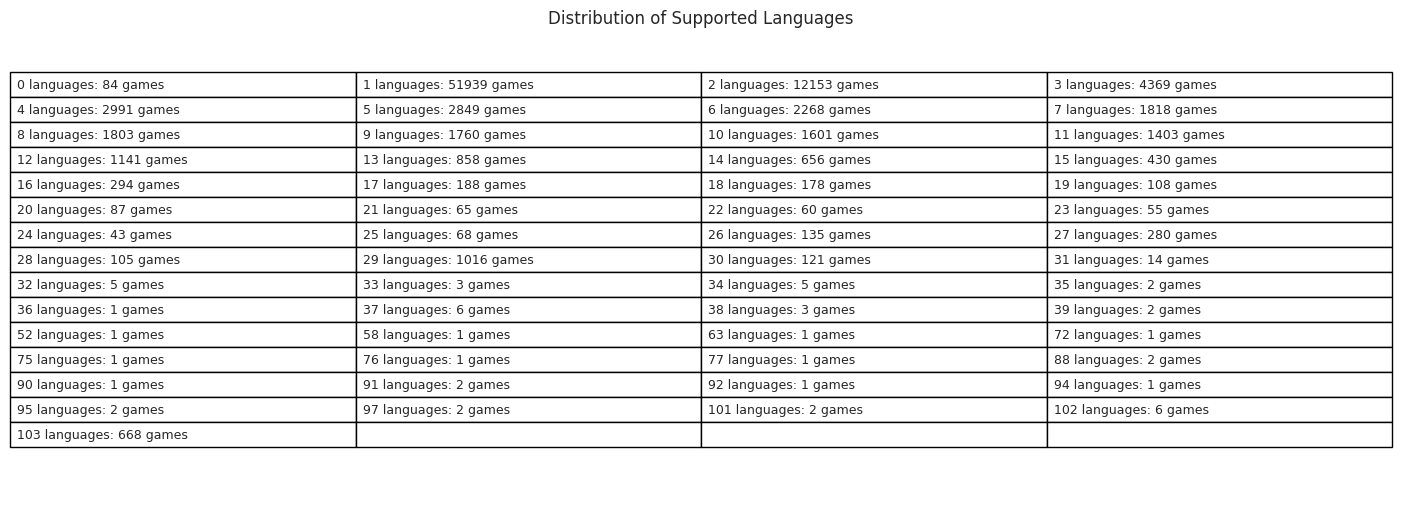

In [ ]:
# Calculate language support distributions
language_counts = steam_df['supported_languages'].apply(len).value_counts().sort_index()

total_games = len(steam_df)
games_single_language = len(steam_df[steam_df['supported_languages'].apply(len) == 1])
percent_single_language = (games_single_language / total_games) * 100

# Print summary statistics
print(f"Percentage of games with only one language: {percent_single_language:.2f}%")

# Display distribution table
fig = plt.figure(figsize=(12, 5))
ax = plt.gca()
ax.set_position([0, 0, 1, 0.95])
plt.axis('off')

# Transform data for 4-column layout
data = [(count, value) for count, value in language_counts.items()]
n = len(data)
rows = np.ceil(n / 4).astype(int)
cell_text = [['' for _ in range(4)] for _ in range(rows)]

for i in range(n):
    row = i // 4
    col = i % 4
    cell_text[row][col] = f"{data[i][0]} languages: {data[i][1]} games"

# Configure and style table
table = plt.table(cellText=cell_text,
                  loc='center',
                  cellLoc='left',
                  edges='closed',
                  colWidths=[0.24, 0.24, 0.24, 0.24])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1.2, 1.5)

for cell in table._cells.values():
    cell.set_edgecolor('black')
    cell.set_facecolor('white')
    cell.set_text_props(wrap=True)
    cell.PAD = 0.02

plt.title('Distribution of Supported Languages', y=0.98)
plt.show()

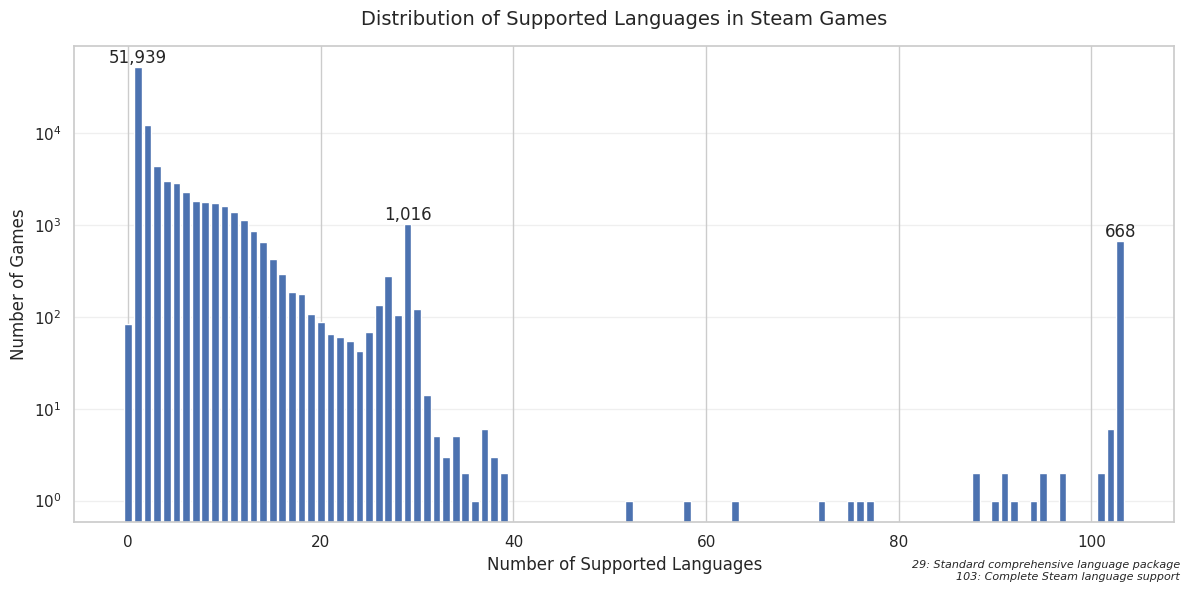

In [ ]:
# Set Seaborn style
sns.set_theme(style="whitegrid")

# Create the figure and axis
plt.figure(figsize=(12, 6))

# Create bar plot
bars = plt.bar(language_counts.index, language_counts.values)

# Customize the plot
plt.title('Distribution of Supported Languages in Steam Games', fontsize=14, pad=15)
plt.xlabel('Number of Supported Languages', fontsize=12)
plt.ylabel('Number of Games', fontsize=12)

# Add annotations for key points
for i in [1, 29, 103]:
    if i in language_counts.index:
        count = language_counts[i]
        plt.text(i, count, f'{count:,}', ha='center', va='bottom')

# Add grid for better readability
plt.grid(True, axis='y', alpha=0.3)

# Adjust y-axis to log scale
plt.yscale('log')

# Add explanatory text for spikes
plt.figtext(0.99, 0.02,
            '29: Standard comprehensive language package\n103: Complete Steam language support',
            ha='right', fontsize=8, style='italic')

plt.tight_layout()
plt.show()

In [ ]:
# Check for English in supported languages
english_count = steam_df['supported_languages'].apply(lambda x: 'english' in [lang.lower() for lang in x]).sum()
total_games = len(steam_df)

print(f"Games with English support: {english_count}")
print(f"Total games: {total_games}")
print(f"Percentage with English: {(english_count/total_games)*100:.2f}%")

Games with English support: 87283
Total games: 91661
Percentage with English: 95.22%


In [ ]:
# Calculate key statistics
total_games = len(steam_df)

# Calculate percentages for each tier
tier_1 = (language_counts == 1).sum()
tier_2 = ((language_counts > 1) & (language_counts <= 5)).sum()
tier_3 = ((language_counts > 5) & (language_counts <= 15)).sum()
tier_4 = ((language_counts > 15) & (language_counts <= 28)).sum()
tier_5 = (language_counts > 28).sum()

print("Distribution Analysis of Supported Languages:\n")
print(f"Total Games: {total_games:,}\n")

print("Tier Distribution:")
print(f"Tier 1 (1 language): {tier_1:,} games ({tier_1/total_games*100:.1f}%)")
print(f"Tier 2 (2-5 languages): {tier_2:,} games ({tier_2/total_games*100:.1f}%)")
print(f"Tier 3 (6-15 languages): {tier_3:,} games ({tier_3/total_games*100:.1f}%)")
print(f"Tier 4 (16-28 languages): {tier_4:,} games ({tier_4/total_games*100:.1f}%)")
print(f"Tier 5 (29+ languages): {tier_5:,} games ({tier_5/total_games*100:.1f}%)")

Distribution Analysis of Supported Languages:

Total Games: 91,661

Tier Distribution:
Tier 1 (1 language): 11 games (0.0%)
Tier 2 (2-5 languages): 11 games (0.0%)
Tier 3 (6-15 languages): 3 games (0.0%)
Tier 4 (16-28 languages): 0 games (0.0%)
Tier 5 (29+ languages): 32 games (0.0%)


Similar to our analysis of full_audio_languages, we first created a detailed table showing counts for each number of languages, accompanied by a log-scale plot to visualize the distribution. The distribution pattern showed notable similarities to full_audio_languages, with characteristic spikes at 29 (Steam's standard language package) and 103 (complete Steam language support).

However, a key difference emerged: unlike audio support, virtually all games had at least one supported language. This made our previous binary encoding approach unsuitable. We initially considered creating a 'has_english' column, but with 95.22% of games supporting English, this wouldn't provide meaningful differentiation.

Instead, we developed a tiered approach based on natural breaks in the distribution:
- Tier 1 (Basic): Single language support (~57% of games)
- Tier 2 (Limited): 2-5 languages (~24%)
- Tier 3 (Multi-language): 6-15 languages (~15%)
- Tier 4 (Extensive): 16-28 languages (~3%)
- Tier 5 (Global): 29+ languages (~1%)

This tiered approach offers several advantages over keeping the raw language counts. First, it reduces the dimensionality of the data while preserving meaningful distinctions in language support levels. Second, the tiers align with natural breakpoints in the distribution, making them more interpretable than arbitrary numerical cutoffs. Third, these tiers reflect meaningful differences in market reach and development investment - from games targeting specific regions (Tier 1) to those aiming for global accessibility (Tier 5). This categorization should provide more useful insights for our predictive modeling than raw counts would.

In [ ]:
def get_language_tier(num_languages):
    if num_languages == 1:
        return 1    # "Basic" - Single language
    elif num_languages <= 5:
        return 2    # "Limited" - Common for smaller games
    elif num_languages <= 15:
        return 3    # "Multi-language" - Significant international support
    elif num_languages <= 28:
        return 4    # "Extensive" - Broad language support
    else:
        return 5    # "Global" - Comprehensive language support

# Create new feature
steam_df['language_support_tier'] = steam_df['supported_languages'].apply(len).apply(get_language_tier)

In [ ]:
steam_df = steam_df.drop(columns=['supported_languages', 'full_audio_languages'])

As mentioned above, we then created a new column with the new tiers called `language_support_tier`. Then we dropped the old `supported_languages` and `full_audio_languages` columns as they were no longer needed

## 4.4 Genre EDA and Feature Engineering

Video game genres are defined as groups of games that share similar gameplay characteristics, noticeably by the ways the players can interact with the game / the overall experience the game provides. Understanding and analyzing these genres is an essential step in exploratory data analysis (EDA) when examining a dataset of video games. By performing thorough investigation into these genres, we gain insights into how different genres of games can contribute to a game's success/popularity in the gaming community.

First, consideirng the `genres` column in our dataframe contains lists of strings that each represent a game genre define by steam, let us explode the dataframe on `genres` to see what are the unique genre types are in our dataframe.

In [ ]:
genres_steam_df = steam_df.explode('genres')

genres_steam_df.dropna(subset=['genres'], inplace=True)
genres_steam_df.reset_index(drop=True, inplace=True)

unique_genres = genres_steam_df['genres'].unique()
print("Unique genres:")
for genre in unique_genres:
    print(genre)

Unique genres:
Casual
Indie
Sports
Action
Adventure
Strategy
Free to Play
Massively Multiplayer
RPG
Simulation
Early Access
Racing
Utilities
Education
Sexual Content
Nudity
Violent
Gore
Design & Illustration
Animation & Modeling
Game Development
Web Publishing
Software Training
Photo Editing
Audio Production
Video Production
Accounting
Movie
Documentary
Episodic
Short
Tutorial
360 Video
Free To Play


Now, from the unique genres above, we realize that some of the genres are not related to video games. After extensively searching the Steam platform, we realize that a lot of the "games" included in this dataframe are software tools/utitlities that are unrelated to video games. Hence, we gotten a list of genres that are not related to video games in `excluded_genres`, and we would drop the rows in our `steam_df` dataframe that has these genres:

In [ ]:
excluded_genres = [
    'Documentary',
    'Design & Illustration',
    'Animation & Modeling',
    'Game Development',
    'Web Publishing',
    'Software Training',
    'Photo Editing',
    'Audio Production',
    'Video Production',
    'Accounting',
    'Movie',
    'Short',
    'Utilities',
    'Episodic',
    'Tutorial',
    '360 Video',
    'Free To Play'
]

excluded_genres_set = set(excluded_genres)

mask = [
    excluded_genres_set.isdisjoint(genres)
    for genres in steam_df['genres']
]

filtered_steam_df = steam_df[mask].reset_index(drop=True)
relevant_genre_df =  genres_steam_df[~genres_steam_df['genres'].isin(excluded_genres)].reset_index(drop=True)

steam_df = filtered_steam_df

app_id                    name  required_age  price  dlc_count  \
0        20200        Galactic Bowling             0  19.99          0   
1       655370            Train Bandit             0   0.99          0   
2      1732930            Jolt Project             0   4.99          0   
3      1355720                Henosis™             0   5.99          0   
4      1139950   Two Weeks in Painland             0   0.00          0   
...        ...                     ...           ...    ...        ...   
89833  3165130             SLIME ORDER             0   0.99          0   
89834  3080940  Femdom Game World: Mom             0   4.19          0   
89835  2593970             Blocky Farm             0   8.99          0   
89836  3124670       Escape The Garage             0   4.99          0   
89837  3054200              Lober Lobe             0   4.49          0   

       windows    mac  linux  achievements  \
0         True  False  False            30   
1         True   True  False            12   
2         True  False  False             0   
3         True   True   True             0   
4         True   True  False            17   
...        ...    ...    ...           ...   
89833     True  False  False             1   
89834     True  False  False             0   
89835     True  False  False            21   
89836     True  False  False            23   
89837     True  False  False           100   

                                                packages  \
0      [{'title': 'Buy Galactic Bowling', 'descriptio...   
1      [{'title': 'Buy Train Bandit', 'description': ...   
2      [{'title': 'Buy Jolt Project', 'description': ...   
3      [{'title': 'Buy Henosis™', 'description': '', ...   
4                                                     []   
...                                                  ...   
89833  [{'title': 'Buy SLIME ORDER', 'description': '...   
89834  [{'title': 'Buy Femdom Game World: Mom', 'desc...   
89835  [{'title': 'Buy Blocky Farm', 'description': '...   
89836  [{'title': 'Buy Escape The Garage', 'descripti...   
89837  [{'title': 'Buy Lober Lobe', 'description': ''...   

                          developers                     publishers  \
0            [Perpetual FX Creative]        [Perpetual FX Creative]   
1                     [Rusty Moyher]                 [Wild Rooster]   
2                    [Campião Games]                [Campião Games]   
3                [Odd Critter Games]            [Odd Critter Games]   
4                    [Unusual Games]                [Unusual Games]   
...                              ...                            ...   
89833                        [かべろくん]                        [かべろくん]   
89834            [Femdom Game World]            [Femdom Game World]   
89835  [Forever Entertainment S. A.]  [Forever Entertainment S. A.]   
89836                       [CryneX]         [CryneX, CryTechGames]   
89837      [James H. Van der Meulen]          [Trash Vomit Studios]   

                                              categories  \
0      [Single-player, Multi-player, Steam Achievemen...   
1      [Single-player, Steam Achievements, Full contr...   
2                                        [Single-player]   
3               [Single-player, Full controller support]   
4                    [Single-player, Steam Achievements]   
...                                                  ...   
89833                    [Single-player, Family Sharing]   
89834                    [Single-player, Family Sharing]   
89835  [Single-player, Steam Achievements, Partial Co...   
89836  [Single-player, Steam Achievements, Family Sha...   
89837  [Single-player, Steam Achievements, Full contr...   

                                     genres  median_playtime_forever  \
0                   [Casual, Indie, Sports]                        0   
1                           [Action, Indie]                        0   
2      [Action, Adventure, Indie, Strategy]            

After filtering out all the unrelated genres, we decided to create a bar graph to model the relationship of the relevant genres to the median playtime of a game, which we defined as the success metric of a video game previously. We initially decided to look at the median of median playtimes for games in each genre, however, since a great deal of games have 0 median playtime, we decided to use the average of median playtime forever of games in each category to produce an actual visualalization.

<ipython-input-161-cca103361edd>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='median_playtime', y='genres', data=genre_playtime, palette='viridis')


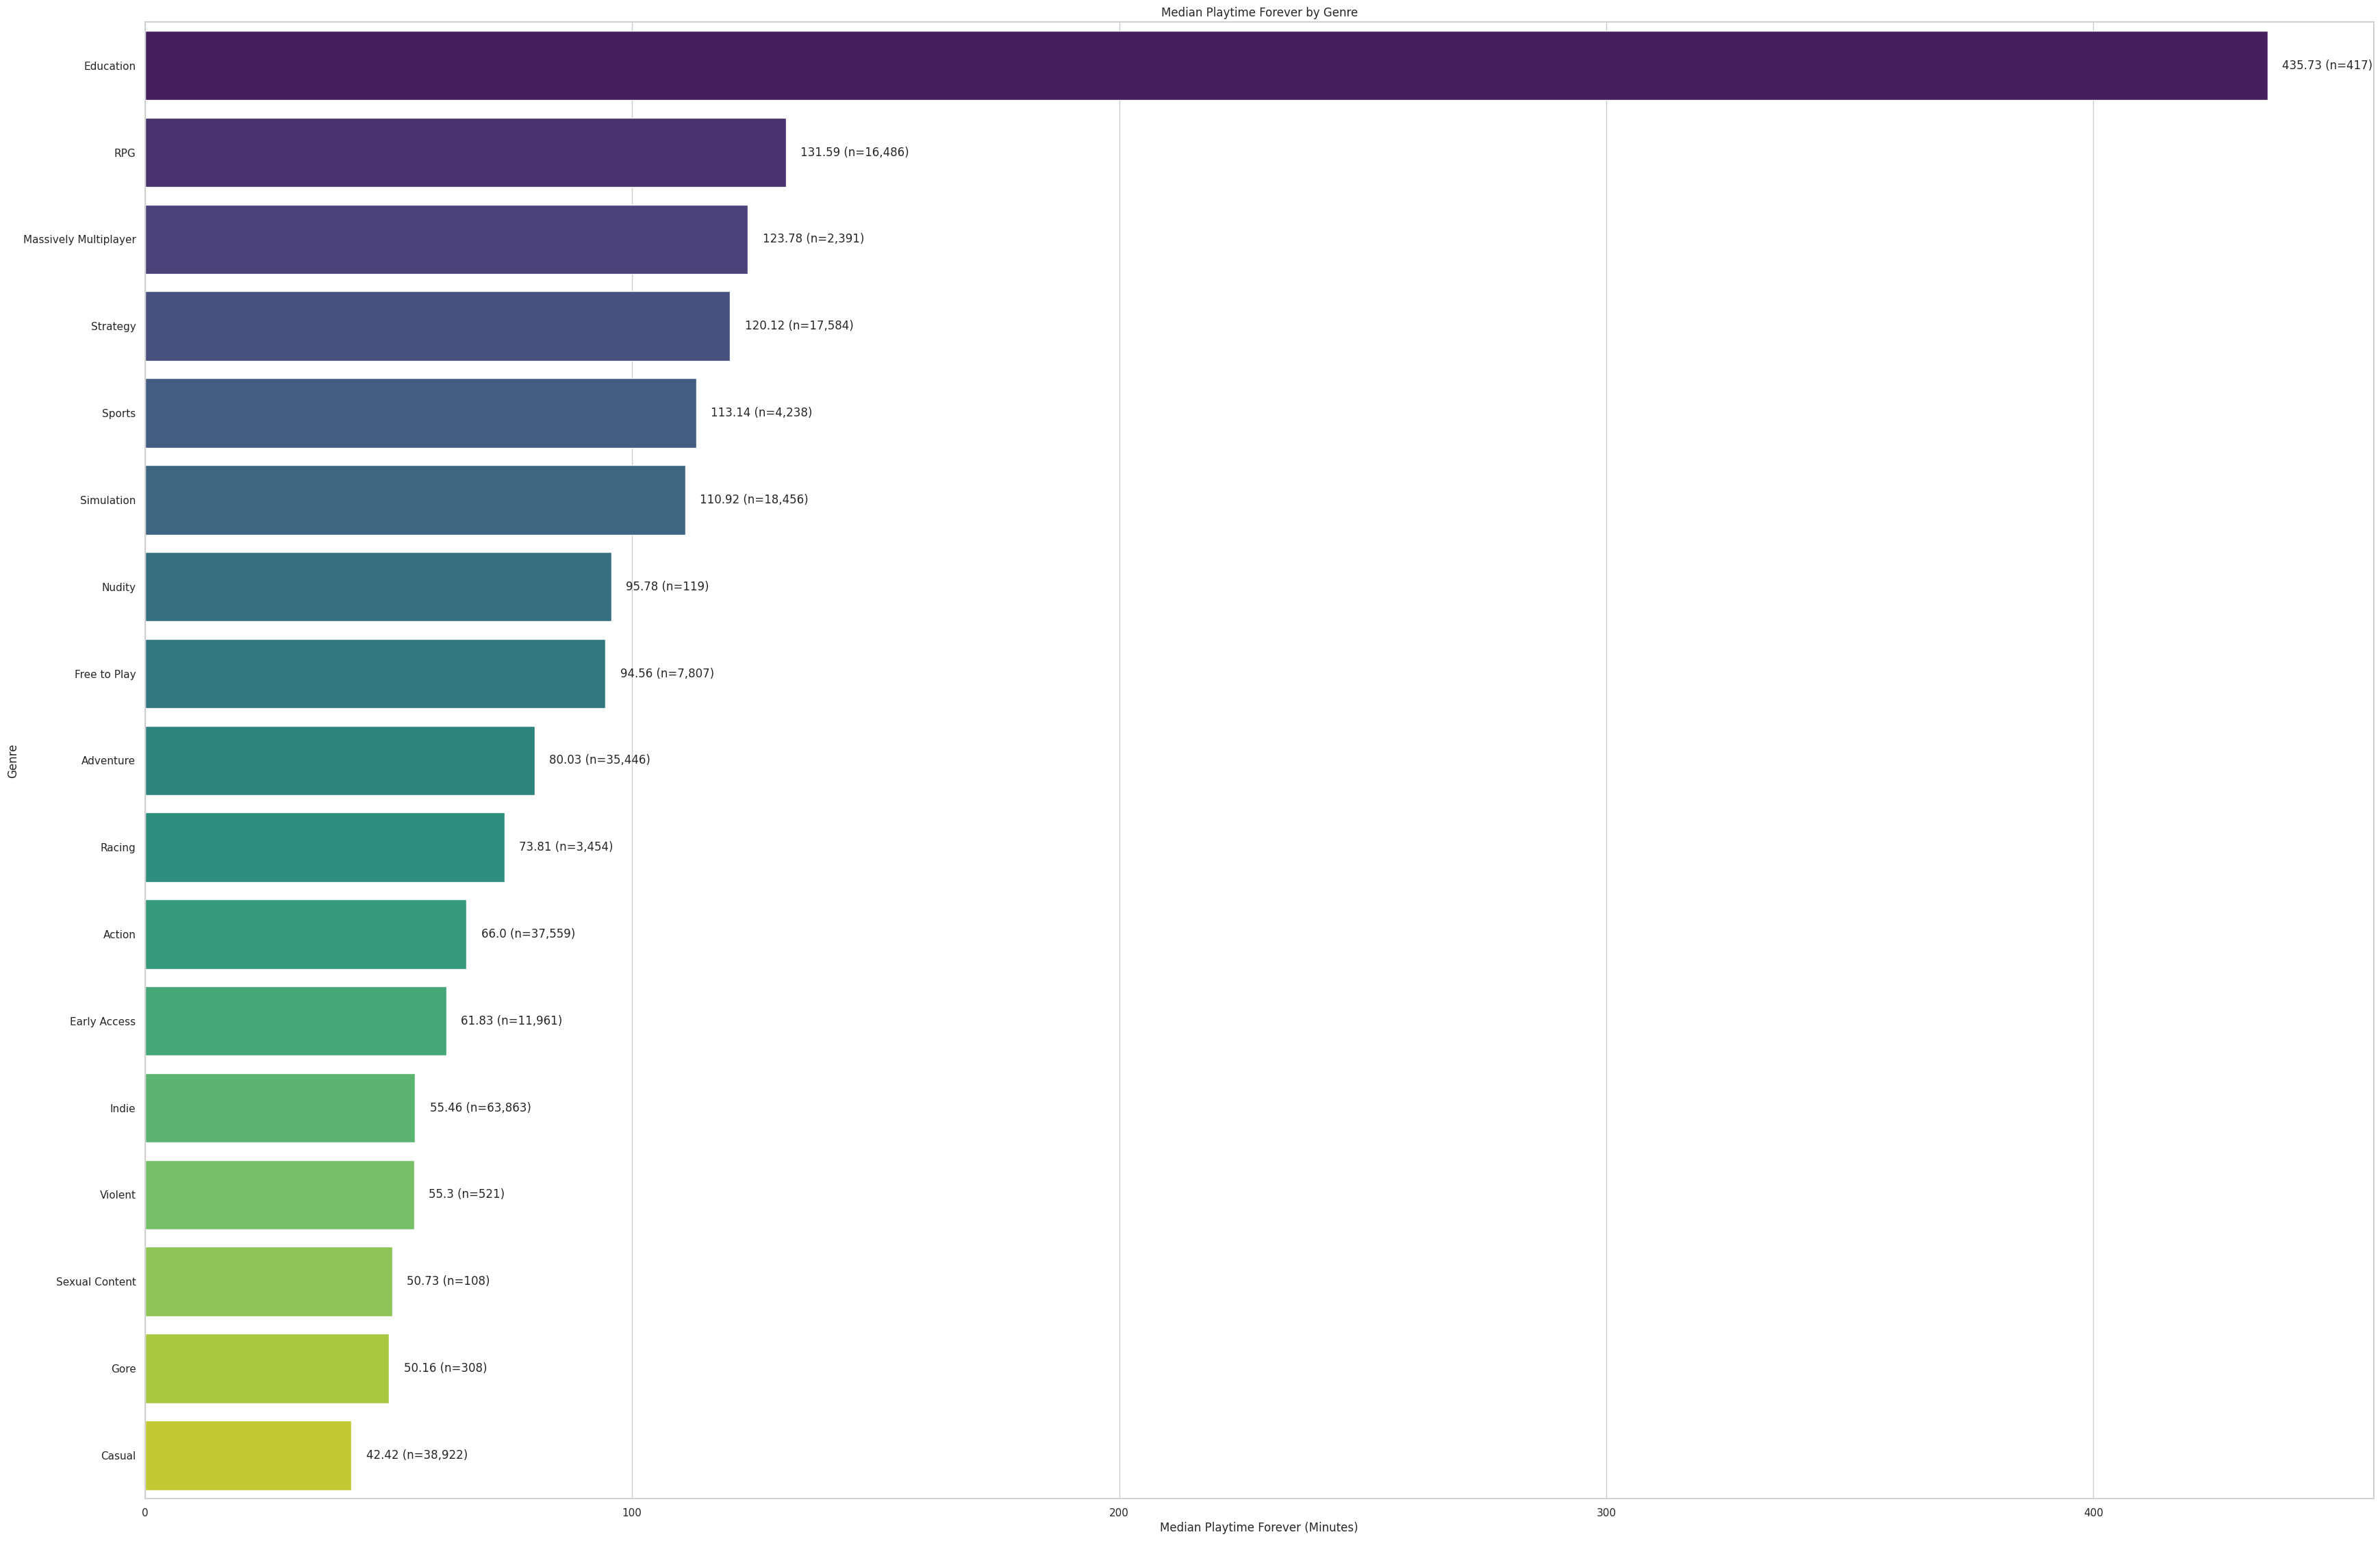

In [ ]:
genre_playtime = (relevant_genre_df.groupby('genres')
                 .agg(
                     median_playtime=('median_playtime_forever', 'mean'),
                     unique_games=('name', 'nunique')
                 )
                 .reset_index())

genre_playtime = genre_playtime.sort_values('median_playtime', ascending=False)

plt.figure(figsize=(42, 28))

sns.barplot(x='median_playtime', y='genres', data=genre_playtime, palette='viridis')

for i, row in enumerate(genre_playtime.itertuples()):
    plt.text(row.median_playtime + 3, i,
             f'{round(row.median_playtime, 2)} (n={row.unique_games:,})',
             va='center')

plt.xlabel('Median Playtime Forever (Minutes)')
plt.ylabel('Genre')
plt.title('Median Playtime Forever by Genre')

plt.show()

From the above bar graph, we can make the following interpretation about genres:
- Genres that inherently encourage progression, story engagement, community interaction, or skill mastery (such as RPGs, MMOs, and Strategy games) lead to more sustained playtime.
- Genres that are more “pick-up-and-play,” offering quick entertainment without deep progression systems (like Casual or simple Action titles) tend to have shorter median play durations.
- The educational genre’s high median playtime suggests a potentially different usage pattern—these may be used repeatedly as part of a learning routine, extending their overall time of engagement compared to leisure-focused genres. Yet considering the low sample size of games that fall under the education category, we need to investigate further and employ more rigorous methods to ensure we can accurately find what genres can contribute most to the success of a game.

Now, we need to transform the genres data for into a numerical representation that models can easily interpret. For the genres attribute, which is inherently a multi-label categorical feature (each game can belong to multiple genres), a straightforward and commonly used approach is to apply a binary (one-hot) encoding, where 0 represents the game does not fall under this genre and 1 represents that the game does. Therefore, we would be using a MultiLabelBinarizer to accomplish this.

In [ ]:
mlb = MultiLabelBinarizer()
encoded_genres = mlb.fit_transform(steam_df['genres'])

encoded_df = pd.DataFrame(encoded_genres, columns=mlb.classes_, index=steam_df.index)

steam_df = steam_df.join(encoded_df)

There is a decent amount of unique genres in this dataframe even after removing some of the unrelated genres out of the dataset. Therefore, to reduce potentially Redundant Features and Multicollinearity issues, we would want to perform some analysis to gain a rigorous and structured understanding of how these genres relate, group, and can be used more effectively in further analyses or modeling tasks.

We would essentially begin with a constructing a correlation matrix based on the genres we have in our dataset. Through this correlation matrix, we can represent it using a heatmap, which provides a visual representation of how each genre is related to every other genre. Although these genres are binary indicators (e.g., presence or absence of a feature), computing correlation can still reveal patterns in how features co-occur. A positive correlation suggests that two genres often appear together in games, whereas a negative or near-zero correlation suggests they are unrelated or rarely co-occur.

In [ ]:
genre_columns = [
    'Action', 'Adventure', 'Casual', 'Early Access', 'Education',
    'Free to Play', 'Gore', 'Indie', 'Massively Multiplayer',
    'Nudity', 'RPG', 'Racing', 'Sexual Content', 'Simulation',
    'Sports', 'Strategy', 'Violent'
]

genres_heatmap_df = steam_df[genre_columns]

corr_matrix = genres_heatmap_df.corr()

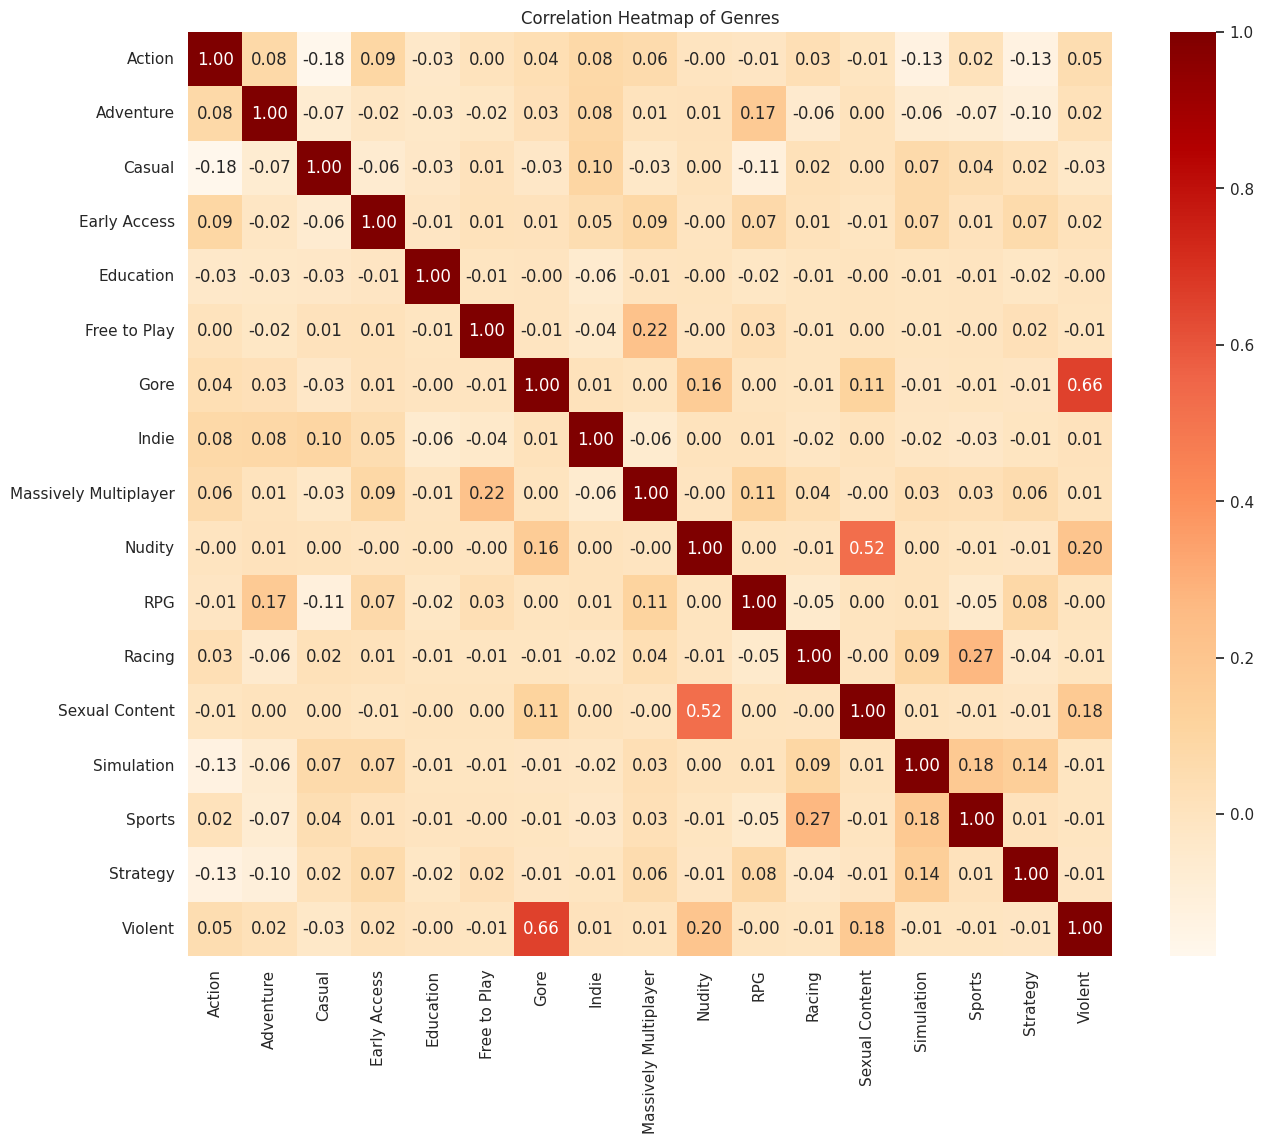

In [ ]:
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='OrRd', square=True)
plt.title("Correlation Heatmap of Genres")
plt.show()

From our heatmap, we can see that most of the genres don't have any significant correlations we each other. Those that particularly stand out would probably be (Violence, Gore) and (Sexual Content, Nudity), but their correlation are still pretty moderate as well, so there seems to be no motivation to be grouping any of the genres together. However, we should like to employ a more rigorous clustering method as well as apply our understanding of each genres to decide what genres should be combined together. Hence, we decided to employ Hierarchical Clustering to these genres. Initially, in the process of our implementing our Hierarchical Clustering, we thought we could easily convert correlation to Euclidian Distance for our choice of distance metric, however, we then researched and realized that Jaccard Distance is the better choice of distance for binary data, and since we want to know whether falling ubder this genre allows a game to be more successful, Jaccard Distance would be a good choice as it’s particularly good when the presence of a feature is more meaningful than its absence. And for our choice of linkage, we choose complete linkage for creating more compact clusters. We define our jaccard distance matrix and create our dendrogram in the following code:

In [ ]:
binary_data = steam_df[genre_columns]

binary_data_transposed = binary_data.T.values

jaccard_distances = pdist(binary_data_transposed, metric='jaccard')

jaccard_distance_matrix = pd.DataFrame(
    squareform(jaccard_distances),
    index=genre_columns,
    columns=genre_columns
)

condensed_distances = squareform(jaccard_distance_matrix, checks=False)

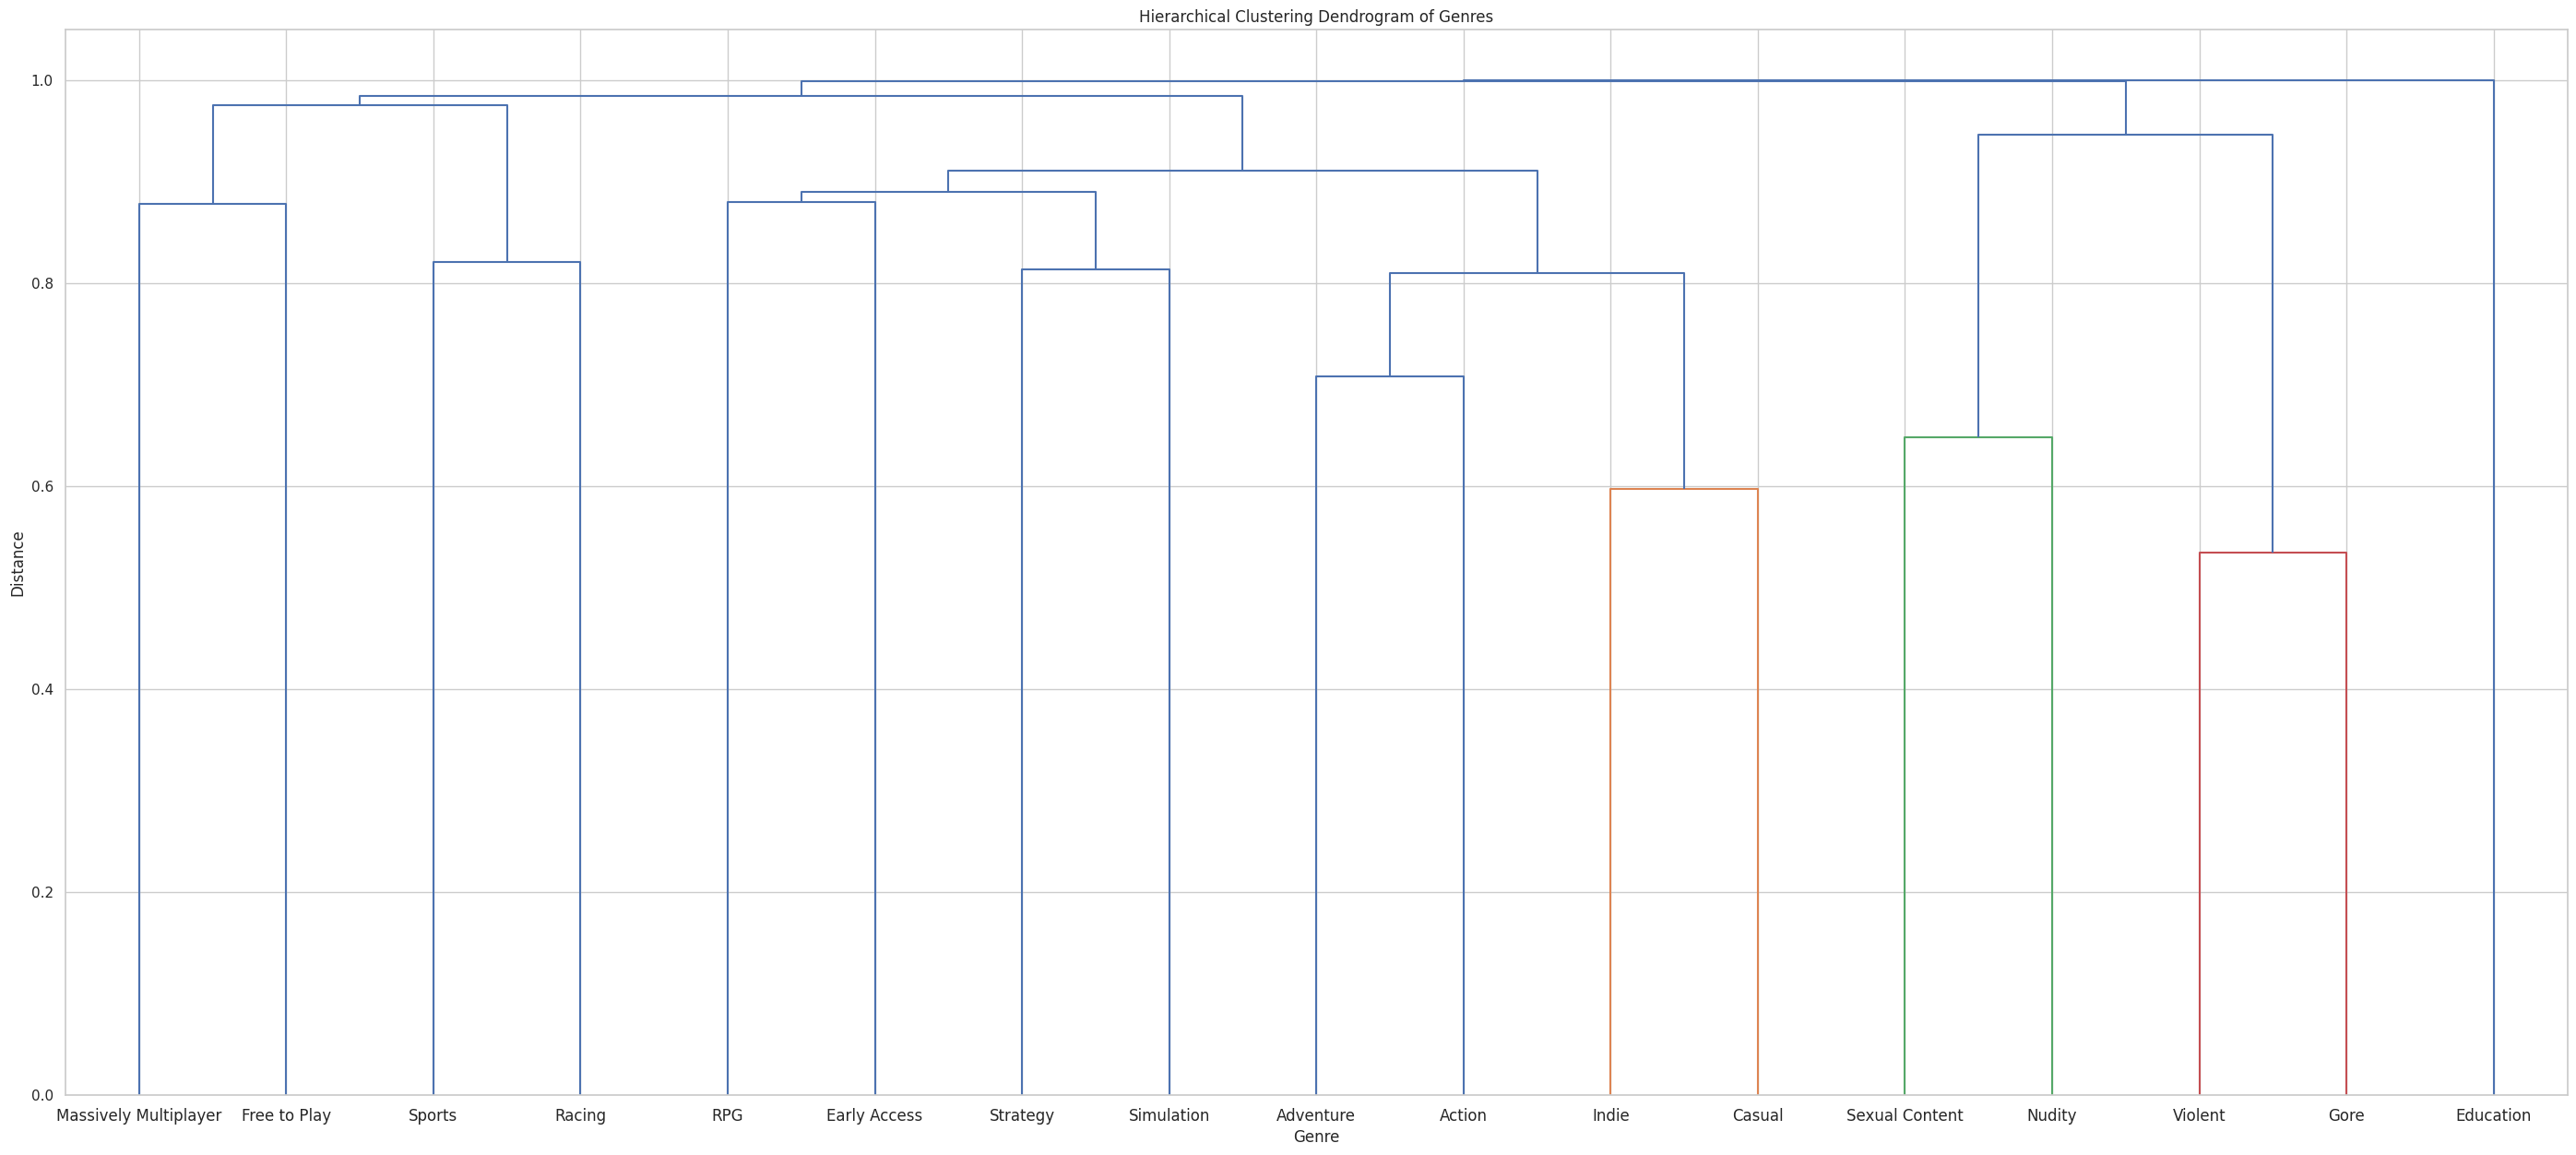

In [ ]:
linked = linkage(condensed_distances, method='complete')

# Plot dendrogram
plt.figure(figsize=(35, 15))
dendrogram(linked, labels=jaccard_distance_matrix.index, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of Genres')
plt.xlabel('Genre')
plt.ylabel('Distance')
plt.show()

From the Dendrogram above, we want to transform this visual hierarchy into actual clusters. We would employ the Silhouette method to identify the cut that provides the best clustering as measured by the output Silhoette Score. We choose thresholds between 0.6 and 1.0 as beyond 1.0 only one clustering is formed and we bound it by 0.6 as the the silhouette score requires at least 2 clusters and fewer than the total number of samples for meaningful computation:

In [ ]:
thresholds = np.linspace(0.6, 1.0, 1000)
best_threshold = None
best_score = -1
best_labels = None

for t in thresholds:
    labels = fcluster(linked, t=t, criterion='distance')
    dist_array = jaccard_distance_matrix.values

    if len(np.unique(labels)) > 1:
        score = silhouette_score(dist_array, labels, metric='precomputed')
        print(f"Threshold: {t:.2f}, Silhouette Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_threshold = t
            best_labels = labels
    else:
        print(f"Threshold: {t:.2f}, only one cluster formed, skipping silhouette.")

print("\nBest threshold based on Silhouette Score:", best_threshold)
print("Best Silhouette Score:", best_score)

cluster_assignments = pd.DataFrame({
    'Category': jaccard_distance_matrix.index,
    'Cluster': best_labels
}).sort_values('Cluster')

print(cluster_assignments)

Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.60, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score: 0.0642
Threshold: 0.61, Silhouette Score:

Looking at the clustering results, we mostly disagree with this clustering as the correlation between most of the clustered data are too small, which would definitely lead to over-generalization issues for our data. We would also separate Sexual Content and Nudity and Violent and Gore as not much games fall under these categories, and the correlation isn't particularly significant as well. Therefore, we retain all the game genres attribute, while only dropping the genres column as we have already successfully encoded it.

In [ ]:
steam_df = steam_df.drop(columns=['genres'])

## 4.5 Category EDA and Feature Engineering

At first glance, the `categories` attribute seems to be discussing similar things with the previous `genres` attribute we just analyzed previously. However, upon close inspection and research or how Steam defines these categories, we realize these two attributes are pretty disjoint. Steam defines categories as the features and modes that the game offers. Noteable features include device support (remote play on devices other than pc, vr support/vr only, additional controller support), gameplay modes (Singleplayer, multiplayer, PvP, Co-op), community support (Steam Workshop, includes level editor)...etc. Therefore, we decided to delve deeper into these categories to gain insights into how different game categories can contribute to a game's success/popularity in the gaming community.

First, we would want to identify how many unique categories there are in the dataframe. To do so, let us explode the dataframe on categories and drop the null values after explosion, and call this exploded dataframe `category_steam_df`.

In [ ]:
category_steam_df = steam_df.explode('categories')

for col in category_steam_df.columns:
    null_count = category_steam_df[col].isna().sum()
    print(f"{col}: {null_count} null values")

category_steam_df.dropna(subset=['categories'], inplace=True)
category_steam_df.reset_index(drop=True, inplace=True)

app_id: 0 null values
name: 0 null values
required_age: 0 null values
price: 0 null values
dlc_count: 0 null values
windows: 0 null values
mac: 0 null values
linux: 0 null values
achievements: 0 null values
packages: 0 null values
developers: 0 null values
publishers: 0 null values
categories: 218 null values
median_playtime_forever: 0 null values
tags: 0 null values
is_successful: 0 null values
has_audio: 0 null values
language_support_tier: 0 null values
Action: 0 null values
Adventure: 0 null values
Casual: 0 null values
Early Access: 0 null values
Education: 0 null values
Free to Play: 0 null values
Gore: 0 null values
Indie: 0 null values
Massively Multiplayer: 0 null values
Nudity: 0 null values
RPG: 0 null values
Racing: 0 null values
Sexual Content: 0 null values
Simulation: 0 null values
Sports: 0 null values
Strategy: 0 null values
Violent: 0 null values


app_id              name  required_age  price  dlc_count  windows  \
0         20200  Galactic Bowling             0  19.99          0     True   
1         20200  Galactic Bowling             0  19.99          0     True   
2         20200  Galactic Bowling             0  19.99          0     True   
3         20200  Galactic Bowling             0  19.99          0     True   
4        655370      Train Bandit             0   0.99          0     True   
...         ...               ...           ...    ...        ...      ...   
292948  3054200        Lober Lobe             0   4.49          0     True   
292949  3054200        Lober Lobe             0   4.49          0     True   
292950  3054200        Lober Lobe             0   4.49          0     True   
292951  3054200        Lober Lobe             0   4.49          0     True   
292952  3054200        Lober Lobe             0   4.49          0     True   

          mac  linux  achievements  \
0       False  False            30   
1       False  False            30   
2       False  False            30   
3       False  False            30   
4        True  False            12   
...       ...    ...           ...   
292948  False  False           100   
292949  False  False           100   
292950  False  False           100   
292951  False  False           100   
292952  False  False           100   

                                                 packages  \
0       [{'title': 'Buy Galactic Bowling', 'descriptio...   
1       [{'title': 'Buy Galactic Bowling', 'descriptio...   
2       [{'title': 'Buy Galactic Bowling', 'descriptio...   
3       [{'title': 'Buy Galactic Bowling', 'descriptio...   
4       [{'title': 'Buy Train Bandit', 'description': ...   
...                                                   ...   
292948  [{'title': 'Buy Lober Lobe', 'description': ''...   
292949  [{'title': 'Buy Lober Lobe', 'description': ''...   
292950  [{'title': 'Buy Lober Lobe', 'description': ''...   
292951  [{'title': 'Buy Lober Lobe', 'description': ''...   
292952  [{'title': 'Buy Lober Lobe', 'description': ''...   

                       developers               publishers  \
0         [Perpetual FX Creative]  [Perpetual FX Creative]   
1         [Perpetual FX Creative]  [Perpetual FX Creative]   
2         [Perpetual FX Creative]  [Perpetual FX Creative]   
3         [Perpetual FX Creative]  [Perpetual FX Creative]   
4                  [Rusty Moyher]           [Wild Rooster]   
...                           ...                      ...   
292948  [James H. Van der Meulen]    [Trash Vomit Studios]   
292949  [James H. Van der Meulen]    [Trash Vomit Studios]   
292950  [James H. Van der Meulen]    [Trash Vomit Studios]   
292951  [James H. Van der Meulen]    [Trash Vomit Studios]   
292952  [James H. Van der Meulen]    [Trash Vomit Studios]   

                        categories  median_playtime_forever  \
0                    Single-player                        0   
1                     Multi-player                        0   
2               Steam Achievements                        0   
3       Partial Controller Support                        0   
4                    Single-player                        0   
...                            ...                      ...   
292948               Single-player                        0   
292949          Steam Achievements                        0   
292950     Full controller support                        0   
292951                 Steam Cloud                        0   
292952              Family Sharing                        0   

                                                     tags  is_successful  \
0       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
1       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
2       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
3       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   


After exploding the dataframe, let us count the unique categories there are in `categories_steam_df`:

In [ ]:
unique_categories = category_steam_df['categories'].unique()
print("Unique categories:")
for category in unique_categories:
    print(category)

Unique categories:
Single-player
Multi-player
Steam Achievements
Partial Controller Support
Full controller support
Steam Leaderboards
Remote Play on Phone
Remote Play on Tablet
Remote Play on TV
MMO
PvP
Online PvP
Co-op
Online Co-op
In-App Purchases
Steam Cloud
Steam Trading Cards
Shared/Split Screen
Cross-Platform Multiplayer
Remote Play Together
Stats
Shared/Split Screen PvP
Captions available
Steam Workshop
Includes level editor
LAN PvP
LAN Co-op
Shared/Split Screen Co-op
Steam Turn Notifications
VR Support
SteamVR Collectibles
Valve Anti-Cheat enabled
Includes Source SDK
Commentary available
Mods
Mods (require HL2)
Tracked Motion Controller Support
Tracked Controller Support
VR Only
VR Supported
HDR available
Family Sharing
Steam Timeline


To ensure that the all the categories have sufficient representation in the dataframe so that we would not need to deal with outliers in our later analysis, let us first out the number of games that falls under each category and sort them in descending order:

In [ ]:
category_counts = category_steam_df['categories'].value_counts()

category_counts = category_counts.reset_index()
category_counts.columns = ['categories', 'count']

category_counts = category_counts.sort_values('count', ascending=False)

print("Number of games in each category:")
print(category_counts.to_string(index=False))

Number of games in each category:
                       categories  count
                    Single-player  85534
               Steam Achievements  40624
                      Steam Cloud  20770
          Full controller support  18072
                     Multi-player  16931
       Partial Controller Support  11333
                              PvP  10695
              Steam Trading Cards   9834
                            Co-op   8610
                       Online PvP   7638
               Steam Leaderboards   7281
                   Family Sharing   7055
             Remote Play Together   6554
              Shared/Split Screen   6117
                     Online Co-op   5039
          Shared/Split Screen PvP   4353
                            Stats   3805
        Shared/Split Screen Co-op   3433
                 In-App Purchases   2506
       Cross-Platform Multiplayer   2482
                Remote Play on TV   2201
            Includes level editor   2001
                   Stea

Now, upon closer inspection of the information of categories from above and how steam defines them on their website, we decided to remove some of these categories from our dataframe (not removing games that fall under one of these unwanted categories, but just removing these categories in general from the dataframe). Our justification to why we are dropping categories can be divided to these two reasons:

1. **Limited Representation:** For categories like Mods, Steam Timeline, Mods (Require HL2), and Tracked Motion Controller Support has way too low of a representation in the dataset, which only either 1 or 2 games that fall under these categories. Hence, we decided to drop these four categories to remove outliers and retain accuracy of our data.

2. **Post-Success Metric**: For categories like Steam Trading Cards, Steam Leaderboads, Commentary Available, and SteamVR collectibles, games that fall under these categories are already successful in Steam. To elaborate, given the example of Steam Trading Cards, Steam only offers/collaborate with successful games to create these Steam Trading Cards to give players incentive to participate in their trading card system. Therefore, including the Steam Trading Card category to predict a game's success would be inaccurate since we are essentially using a post-success metric to predict a game's success. Therefore, we removed these categories to retain accuracy for our data.

Additionally, we also decided to drop the Steam Achievements category as it essentially represent games that have Steam Achievements, which is already an attribute in the original dataset. So to prevent repeated consideration, we decided to remove this category.

In [ ]:
unwanted_categories = [
    "Mods",
    "Steam Timeline",
    "Mods (require HL2)",
    "Tracked Motion Controller Support",
    "Steam Trading Cards",
    "Steam Leaderboards",
    "Commentary available",
    "Steam Achievements",
    "SteamVR Collectibles"
]


steam_df['categories'] = steam_df['categories'].apply(
    lambda category_list: [cat for cat in category_list if cat not in unwanted_categories]
)

app_id                    name  required_age  price  dlc_count  \
0        20200        Galactic Bowling             0  19.99          0   
1       655370            Train Bandit             0   0.99          0   
2      1732930            Jolt Project             0   4.99          0   
3      1355720                Henosis™             0   5.99          0   
4      1139950   Two Weeks in Painland             0   0.00          0   
...        ...                     ...           ...    ...        ...   
89833  3165130             SLIME ORDER             0   0.99          0   
89834  3080940  Femdom Game World: Mom             0   4.19          0   
89835  2593970             Blocky Farm             0   8.99          0   
89836  3124670       Escape The Garage             0   4.99          0   
89837  3054200              Lober Lobe             0   4.49          0   

       windows    mac  linux  achievements  \
0         True  False  False            30   
1         True   True  False            12   
2         True  False  False             0   
3         True   True   True             0   
4         True   True  False            17   
...        ...    ...    ...           ...   
89833     True  False  False             1   
89834     True  False  False             0   
89835     True  False  False            21   
89836     True  False  False            23   
89837     True  False  False           100   

                                                packages  \
0      [{'title': 'Buy Galactic Bowling', 'descriptio...   
1      [{'title': 'Buy Train Bandit', 'description': ...   
2      [{'title': 'Buy Jolt Project', 'description': ...   
3      [{'title': 'Buy Henosis™', 'description': '', ...   
4                                                     []   
...                                                  ...   
89833  [{'title': 'Buy SLIME ORDER', 'description': '...   
89834  [{'title': 'Buy Femdom Game World: Mom', 'desc...   
89835  [{'title': 'Buy Blocky Farm', 'description': '...   
89836  [{'title': 'Buy Escape The Garage', 'descripti...   
89837  [{'title': 'Buy Lober Lobe', 'description': ''...   

                          developers                     publishers  \
0            [Perpetual FX Creative]        [Perpetual FX Creative]   
1                     [Rusty Moyher]                 [Wild Rooster]   
2                    [Campião Games]                [Campião Games]   
3                [Odd Critter Games]            [Odd Critter Games]   
4                    [Unusual Games]                [Unusual Games]   
...                              ...                            ...   
89833                        [かべろくん]                        [かべろくん]   
89834            [Femdom Game World]            [Femdom Game World]   
89835  [Forever Entertainment S. A.]  [Forever Entertainment S. A.]   
89836                       [CryneX]         [CryneX, CryTechGames]   
89837      [James H. Van der Meulen]          [Trash Vomit Studios]   

                                              categories  \
0      [Single-player, Multi-player, Partial Controll...   
1      [Single-player, Full controller support, Remot...   
2                                        [Single-player]   
3               [Single-player, Full controller support]   
4                                        [Single-player]   
...                                                  ...   
89833                    [Single-player, Family Sharing]   
89834                    [Single-player, Family Sharing]   
89835  [Single-player, Partial Controller Support, St...   
89836                    [Single-player, Family Sharing]   
89837  [Single-player, Full controller support, Steam...   

       median_playtime_forever  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            0   
...                        ...   
89833                        0   

In [ ]:
category_cleaned_steam_df = steam_df.explode('categories')


category_cleaned_steam_df.dropna(subset=['categories'], inplace=True)
category_cleaned_steam_df.reset_index(drop=True, inplace=True)

app_id               name  required_age  price  dlc_count  windows  \
0         20200   Galactic Bowling             0  19.99          0     True   
1         20200   Galactic Bowling             0  19.99          0     True   
2         20200   Galactic Bowling             0  19.99          0     True   
3        655370       Train Bandit             0   0.99          0     True   
4        655370       Train Bandit             0   0.99          0     True   
...         ...                ...           ...    ...        ...      ...   
234917  3124670  Escape The Garage             0   4.99          0     True   
234918  3054200         Lober Lobe             0   4.49          0     True   
234919  3054200         Lober Lobe             0   4.49          0     True   
234920  3054200         Lober Lobe             0   4.49          0     True   
234921  3054200         Lober Lobe             0   4.49          0     True   

          mac  linux  achievements  \
0       False  False            30   
1       False  False            30   
2       False  False            30   
3        True  False            12   
4        True  False            12   
...       ...    ...           ...   
234917  False  False            23   
234918  False  False           100   
234919  False  False           100   
234920  False  False           100   
234921  False  False           100   

                                                 packages  \
0       [{'title': 'Buy Galactic Bowling', 'descriptio...   
1       [{'title': 'Buy Galactic Bowling', 'descriptio...   
2       [{'title': 'Buy Galactic Bowling', 'descriptio...   
3       [{'title': 'Buy Train Bandit', 'description': ...   
4       [{'title': 'Buy Train Bandit', 'description': ...   
...                                                   ...   
234917  [{'title': 'Buy Escape The Garage', 'descripti...   
234918  [{'title': 'Buy Lober Lobe', 'description': ''...   
234919  [{'title': 'Buy Lober Lobe', 'description': ''...   
234920  [{'title': 'Buy Lober Lobe', 'description': ''...   
234921  [{'title': 'Buy Lober Lobe', 'description': ''...   

                       developers               publishers  \
0         [Perpetual FX Creative]  [Perpetual FX Creative]   
1         [Perpetual FX Creative]  [Perpetual FX Creative]   
2         [Perpetual FX Creative]  [Perpetual FX Creative]   
3                  [Rusty Moyher]           [Wild Rooster]   
4                  [Rusty Moyher]           [Wild Rooster]   
...                           ...                      ...   
234917                   [CryneX]   [CryneX, CryTechGames]   
234918  [James H. Van der Meulen]    [Trash Vomit Studios]   
234919  [James H. Van der Meulen]    [Trash Vomit Studios]   
234920  [James H. Van der Meulen]    [Trash Vomit Studios]   
234921  [James H. Van der Meulen]    [Trash Vomit Studios]   

                        categories  median_playtime_forever  \
0                    Single-player                        0   
1                     Multi-player                        0   
2       Partial Controller Support                        0   
3                    Single-player                        0   
4          Full controller support                        0   
...                            ...                      ...   
234917              Family Sharing                        0   
234918               Single-player                        0   
234919     Full controller support                        0   
234920                 Steam Cloud                        0   
234921              Family Sharing                        0   

                                                     tags  is_successful  \
0       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
1       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
2       {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
3       {'Indie': 109, 'Action': 103, 'Pixel Graphics'...       

In [ ]:
unique_categories = category_cleaned_steam_df['categories'].unique()
print("Unique categories:")
for category in unique_categories:
    print(category)

Unique categories:
Single-player
Multi-player
Partial Controller Support
Full controller support
Remote Play on Phone
Remote Play on Tablet
Remote Play on TV
MMO
PvP
Online PvP
Co-op
Online Co-op
In-App Purchases
Steam Cloud
Shared/Split Screen
Cross-Platform Multiplayer
Remote Play Together
Stats
Shared/Split Screen PvP
Captions available
Steam Workshop
Includes level editor
LAN PvP
LAN Co-op
Shared/Split Screen Co-op
Steam Turn Notifications
VR Support
Valve Anti-Cheat enabled
Includes Source SDK
Tracked Controller Support
VR Only
VR Supported
HDR available
Family Sharing


After cleaning, we created a bar graph models the relationship between each indivudal category to the median playtime forever of games. Considering that a huge majority of the game has 0 median playtime, we couldn't use the median of the median playtime for games falling in the categories as they offer no visual data. Therefore, we would create a bar graph that compares the categories of OS support to the average median playtime of games to give us a rough intuition of what categories seems to contribute to the median playtime of games, which we define as the success metric of video games in steam.

<ipython-input-176-8b8c64b086de>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x='median_playtime', y='categories', data=category_stats, palette='mako_r')


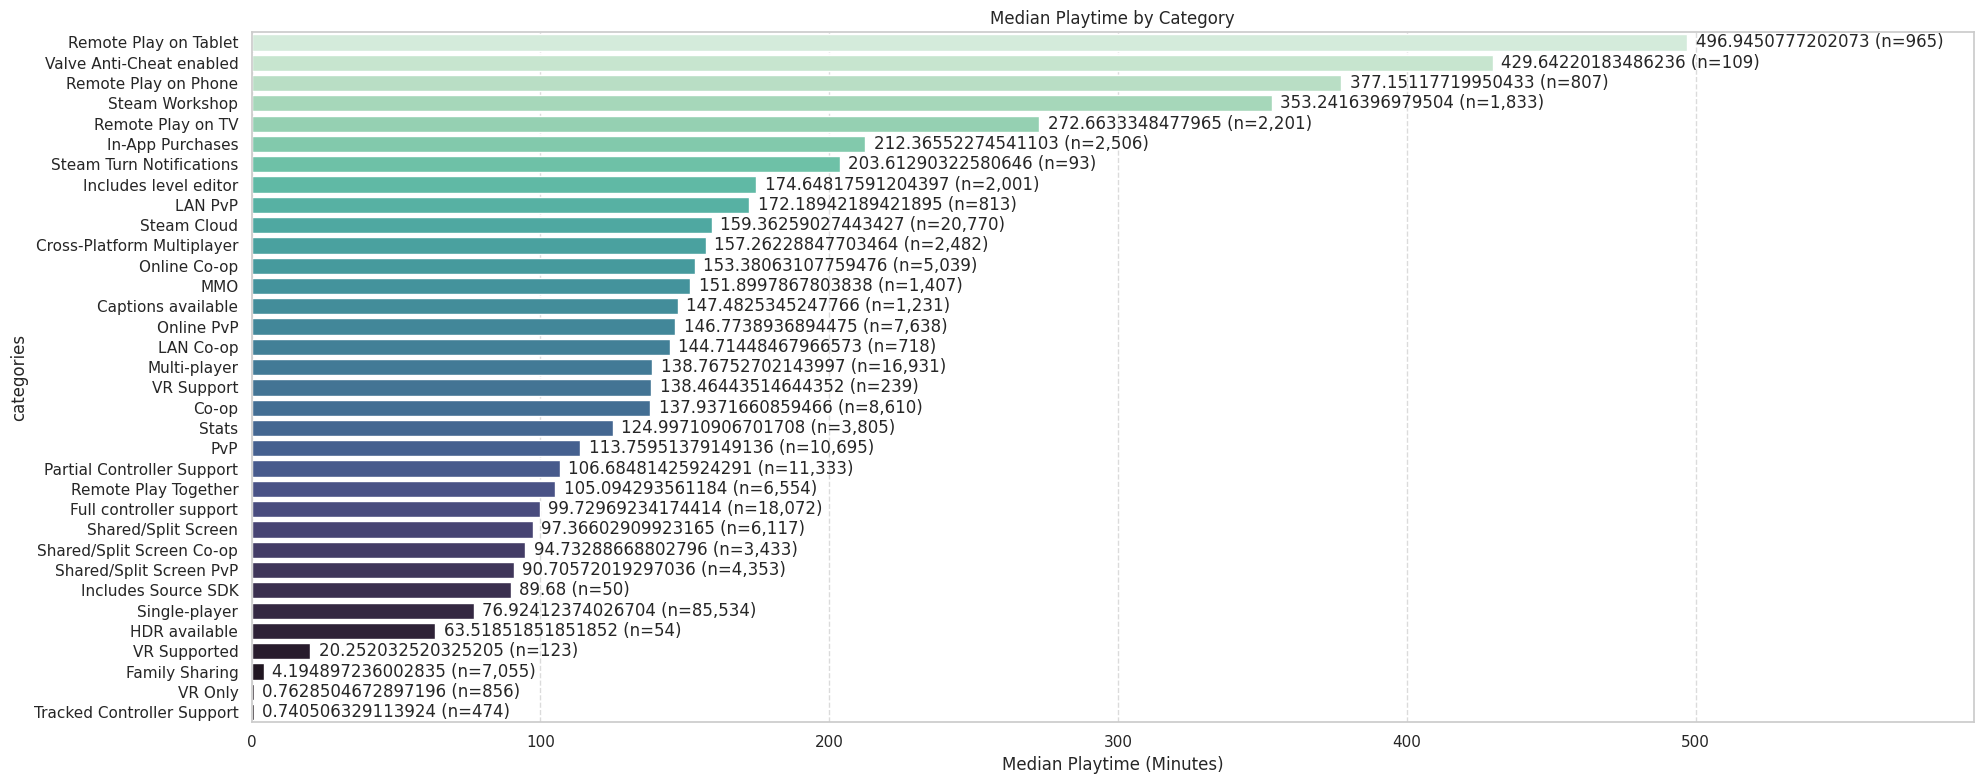

In [ ]:
category_stats = (category_cleaned_steam_df.groupby('categories')
                 .agg(
                     median_playtime=('median_playtime_forever', 'mean'),
                     unique_games=('name', 'nunique')
                 )
                 .reset_index())

category_stats = category_stats.sort_values('median_playtime', ascending=False)

plt.figure(figsize=(20, 8))
ax = sns.barplot(x='median_playtime', y='categories', data=category_stats, palette='mako_r')

for i, row in enumerate(category_stats.itertuples()):
    plt.text(row.median_playtime + 3, i,
             f'{row.median_playtime} (n={row.unique_games:,})',
             va='center')

plt.title('Median Playtime by Category')
plt.xlabel('Median Playtime (Minutes)')
plt.margins(x=0.2)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

  From the above chart, we can make the following interpretations:

- Certain features correlate with longer engagement—especially those tied to multiplayer ecosystems, continuous content updates, or broader accessibility (remote play).
- Conversely, niche or novelty features may not consistently lead to sustained play.
T- his indicates that the presence of social, creative, or competitive mechanics is strongly associated with longer player commitment.

However, we still want to use employ a more rigorous method to determine what are the exact categories that contribute to a video game's success.

Now, we need to transform the categories data for into a numerical representation that models can easily interpret. For the categories attribute, which is inherently a multi-label categorical feature (each game can belong to multiple categories), a straightforward and commonly used approach is to apply a binary (one-hot) encoding, where 0 represents the game does not fall under this category and 1 represents that the game does. Therefore, we would be using a MultiLabelBinarizer to accomplish this.

In [ ]:
mlb = MultiLabelBinarizer()
encoded_cat = mlb.fit_transform(steam_df['categories'])

encoded_df = pd.DataFrame(encoded_cat, columns=mlb.classes_, index=steam_df.index)

steam_df = steam_df.join(encoded_df)


Considering the abundance of unique categories there are in this dataframe, we are concerned that some of the categories might be redundant and lead to Redundant Features and Multicollinearity issues. For instance, with our knowledge of video games and steam, it is fairly obvious Shared/Split Screen and Remote Play Together would be highly correlated as they are essentially the same thing (to activate remote play with another player on steam, you would be sharing the screen from the other player on a separate device, which essentially always falls under the Shared/Split Screen category). Therefore, we would want to perform some analysis to gain a rigorous and structured understanding of how these features relate, group, and can be used more effectively in further analyses or modeling tasks.

We would essentially begin with a constructing a correlation matrix based on the categories we have in our dataset. Through this correlation matrix, we can represent it using a heatmap, which provides a visual representation of how each category is related to every other category. Although these categories are binary indicators (e.g., presence or absence of a feature), computing correlation can still reveal patterns in how features co-occur. A positive correlation suggests that two categories often appear together in games, whereas a negative or near-zero correlation suggests they are unrelated or rarely co-occur.

In [ ]:
specified_columns = [
    'Single-player',
    'Multi-player',
    'Partial Controller Support',
    'Full controller support',
    'Remote Play on Phone',
    'Remote Play on Tablet',
    'Remote Play on TV',
    'MMO',
    'PvP',
    'Online PvP',
    'Co-op',
    'Online Co-op',
    'In-App Purchases',
    'Steam Cloud',
    'Shared/Split Screen',
    'Cross-Platform Multiplayer',
    'Remote Play Together',
    'Stats',
    'Shared/Split Screen PvP',
    'Captions available',
    'Steam Workshop',
    'Includes level editor',
    'LAN PvP',
    'LAN Co-op',
    'Shared/Split Screen Co-op',
    'Steam Turn Notifications',
    'VR Support',
    'Valve Anti-Cheat enabled',
    'Includes Source SDK',
    'Tracked Controller Support',
    'VR Only',
    'VR Supported',
    'HDR available',
    'Family Sharing'
]


cat_heatmap_df = steam_df[specified_columns]

corr_matrix = cat_heatmap_df.corr()

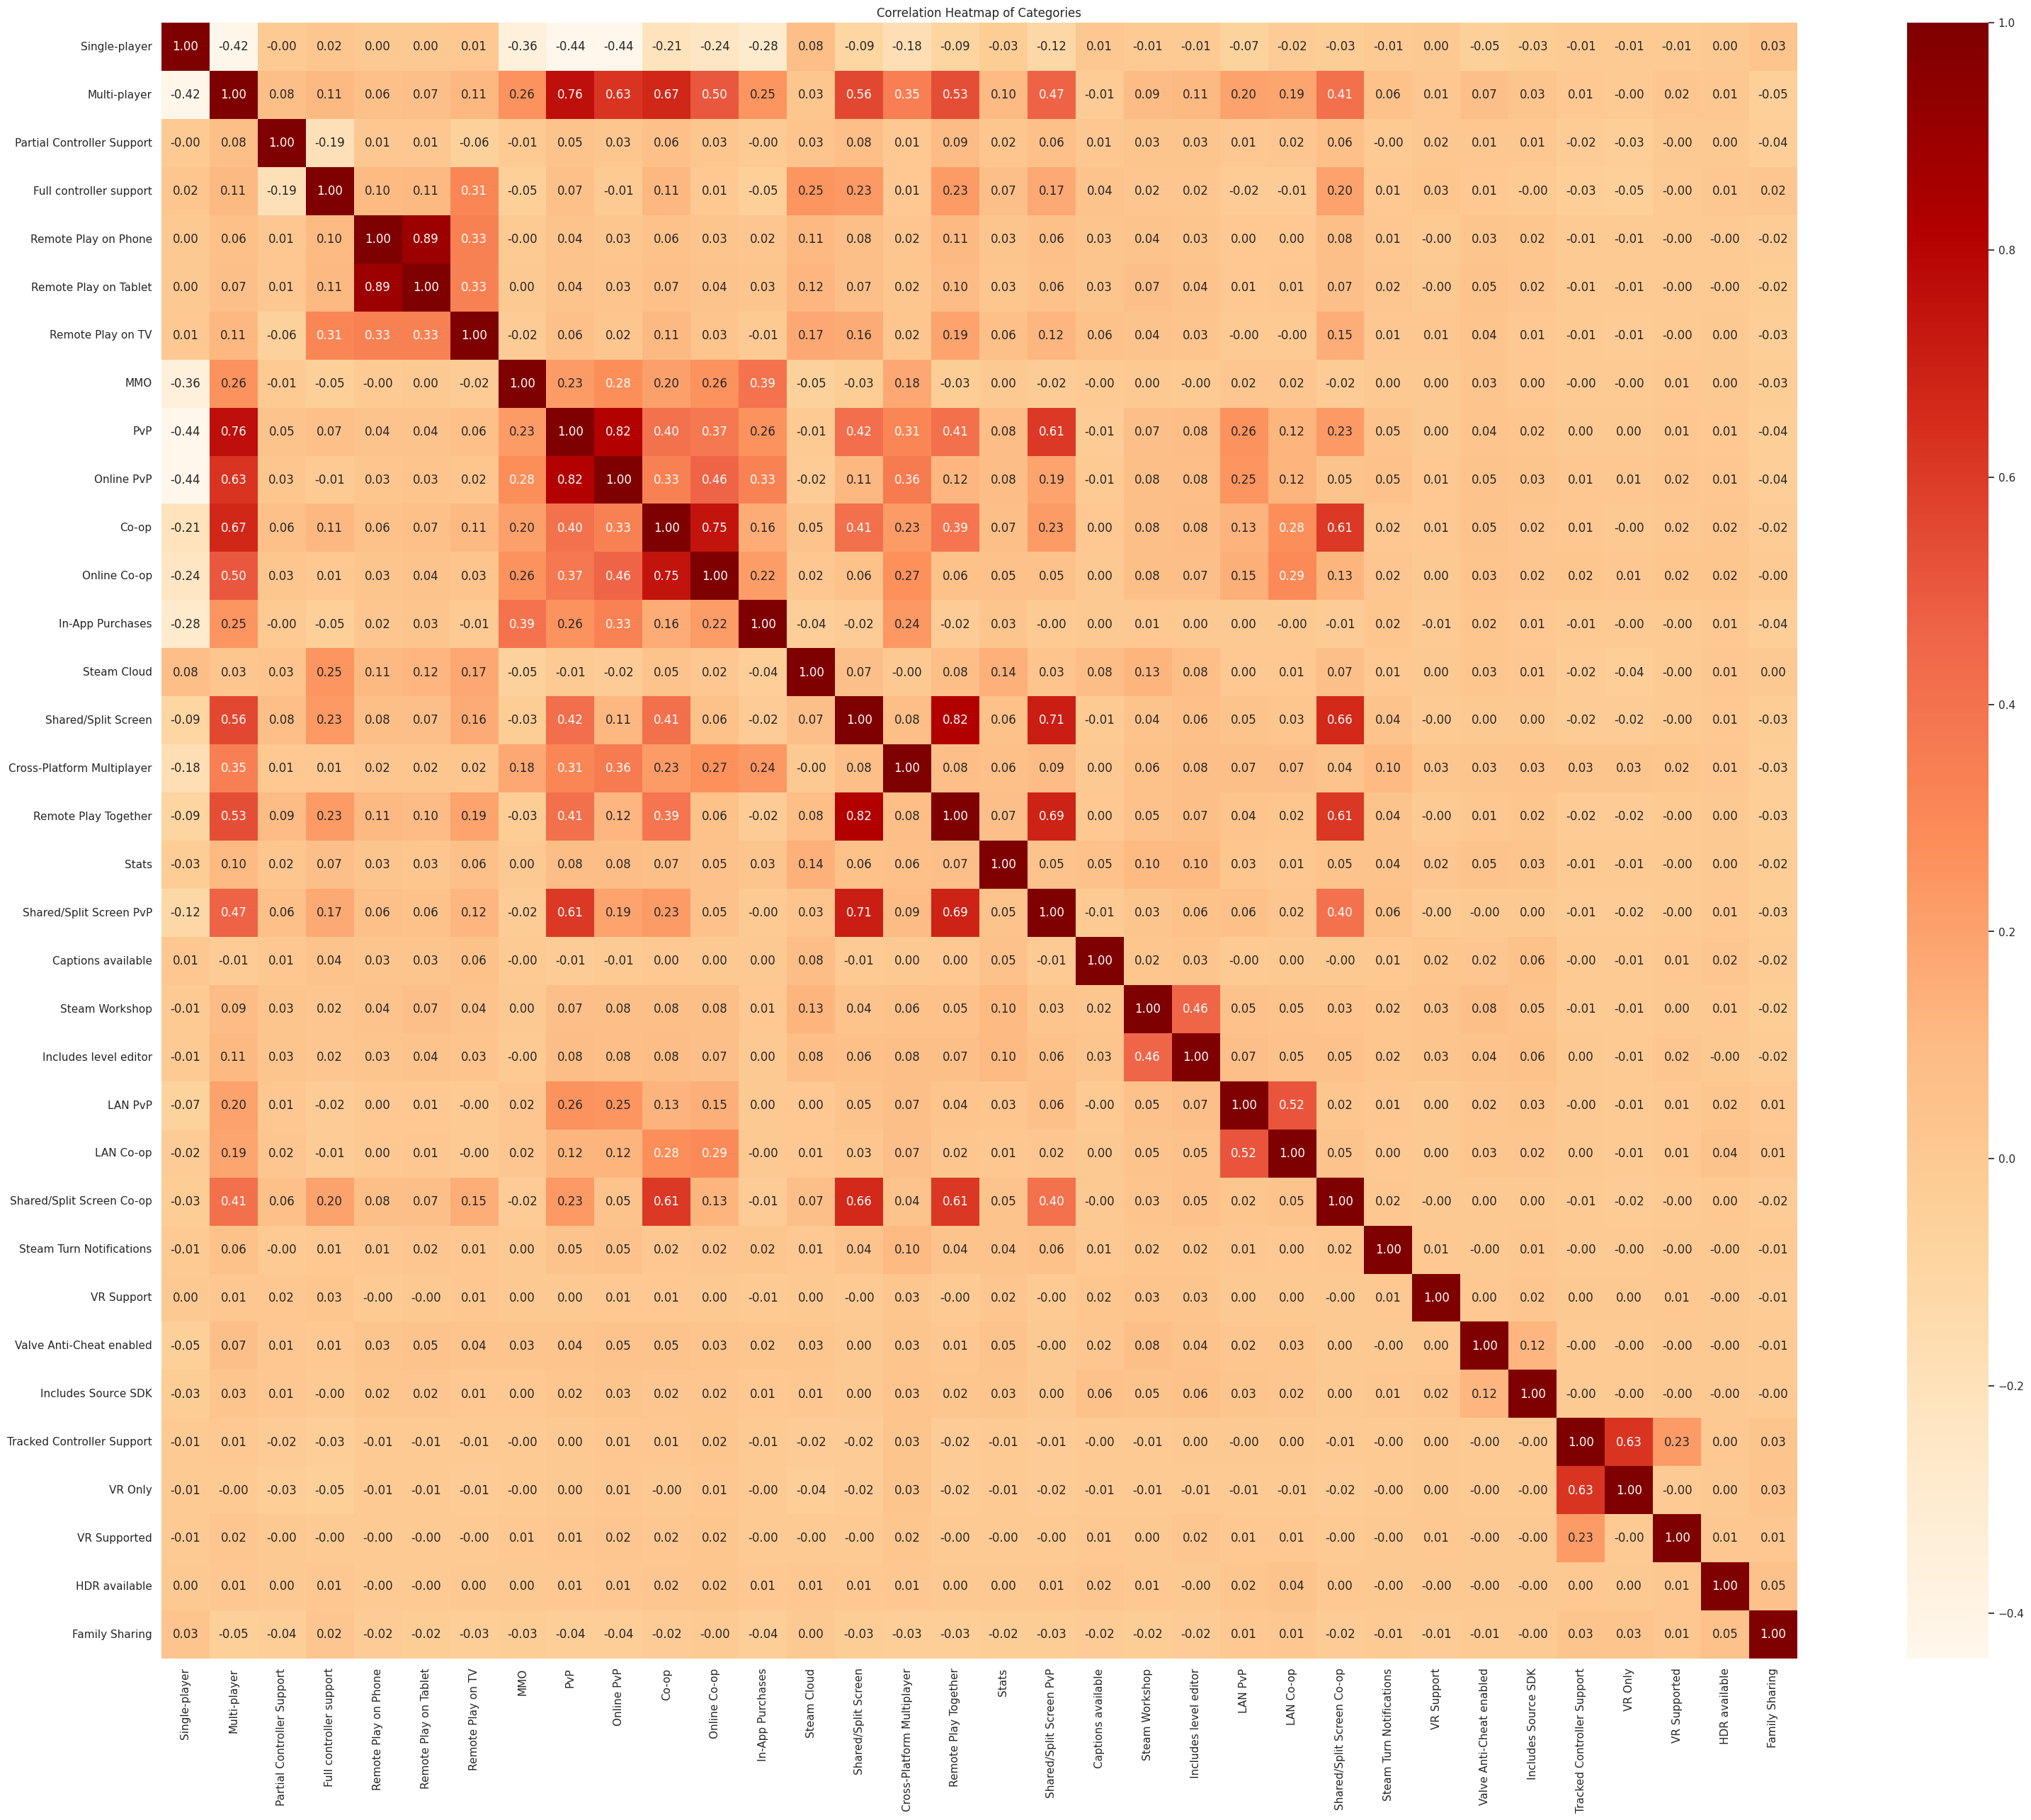

In [ ]:
plt.figure(figsize=(40, 30))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='OrRd', square=True)
plt.title("Correlation Heatmap of Categories")
plt.show()

From this heatmap, we can immediately identify some categories with some high correlations between the categories of our dataset. Noteable pairs include (Remote Play on Phone, Remote Play on Tablet), (Remote Play Together, Shared/Split Screen), (PvP, Online PvP), (Co-Op, Online Co-op), (Multiplayer, PvP). While these correlations give justification to cluster these columns together, we would like to employ a more rigorous clustering method as well as apply our understanding of each categories to decide what categories should be combined together. Hence, we decided to employ Hierarchical Clustering to these categories. Initially, in the process of our implementing our Hierarchical Clustering, we thought we could easily convert correlation to Euclidian Distance for our choice of distance metric, however, we then researched and realized that Jaccard Distance is the better choice of distance for binary data, and since we want to know whether having this feature/playmode allows a game to be more successful, Jaccard Distance would be a good choice as it’s particularly good when the presence of a feature is more meaningful than its absence. And for our choice of linkage, we choose complete linkage for creating more compact clusters. We define our jaccard distance matrix and create our dendrogram in the following code:

In [ ]:
binary_data = steam_df[specified_columns]

binary_data_transposed = binary_data.T.values

jaccard_distances = pdist(binary_data_transposed, metric='jaccard')

jaccard_distance_matrix = pd.DataFrame(
    squareform(jaccard_distances),
    index=specified_columns,
    columns=specified_columns
)

condensed_distances = squareform(jaccard_distance_matrix, checks=False)

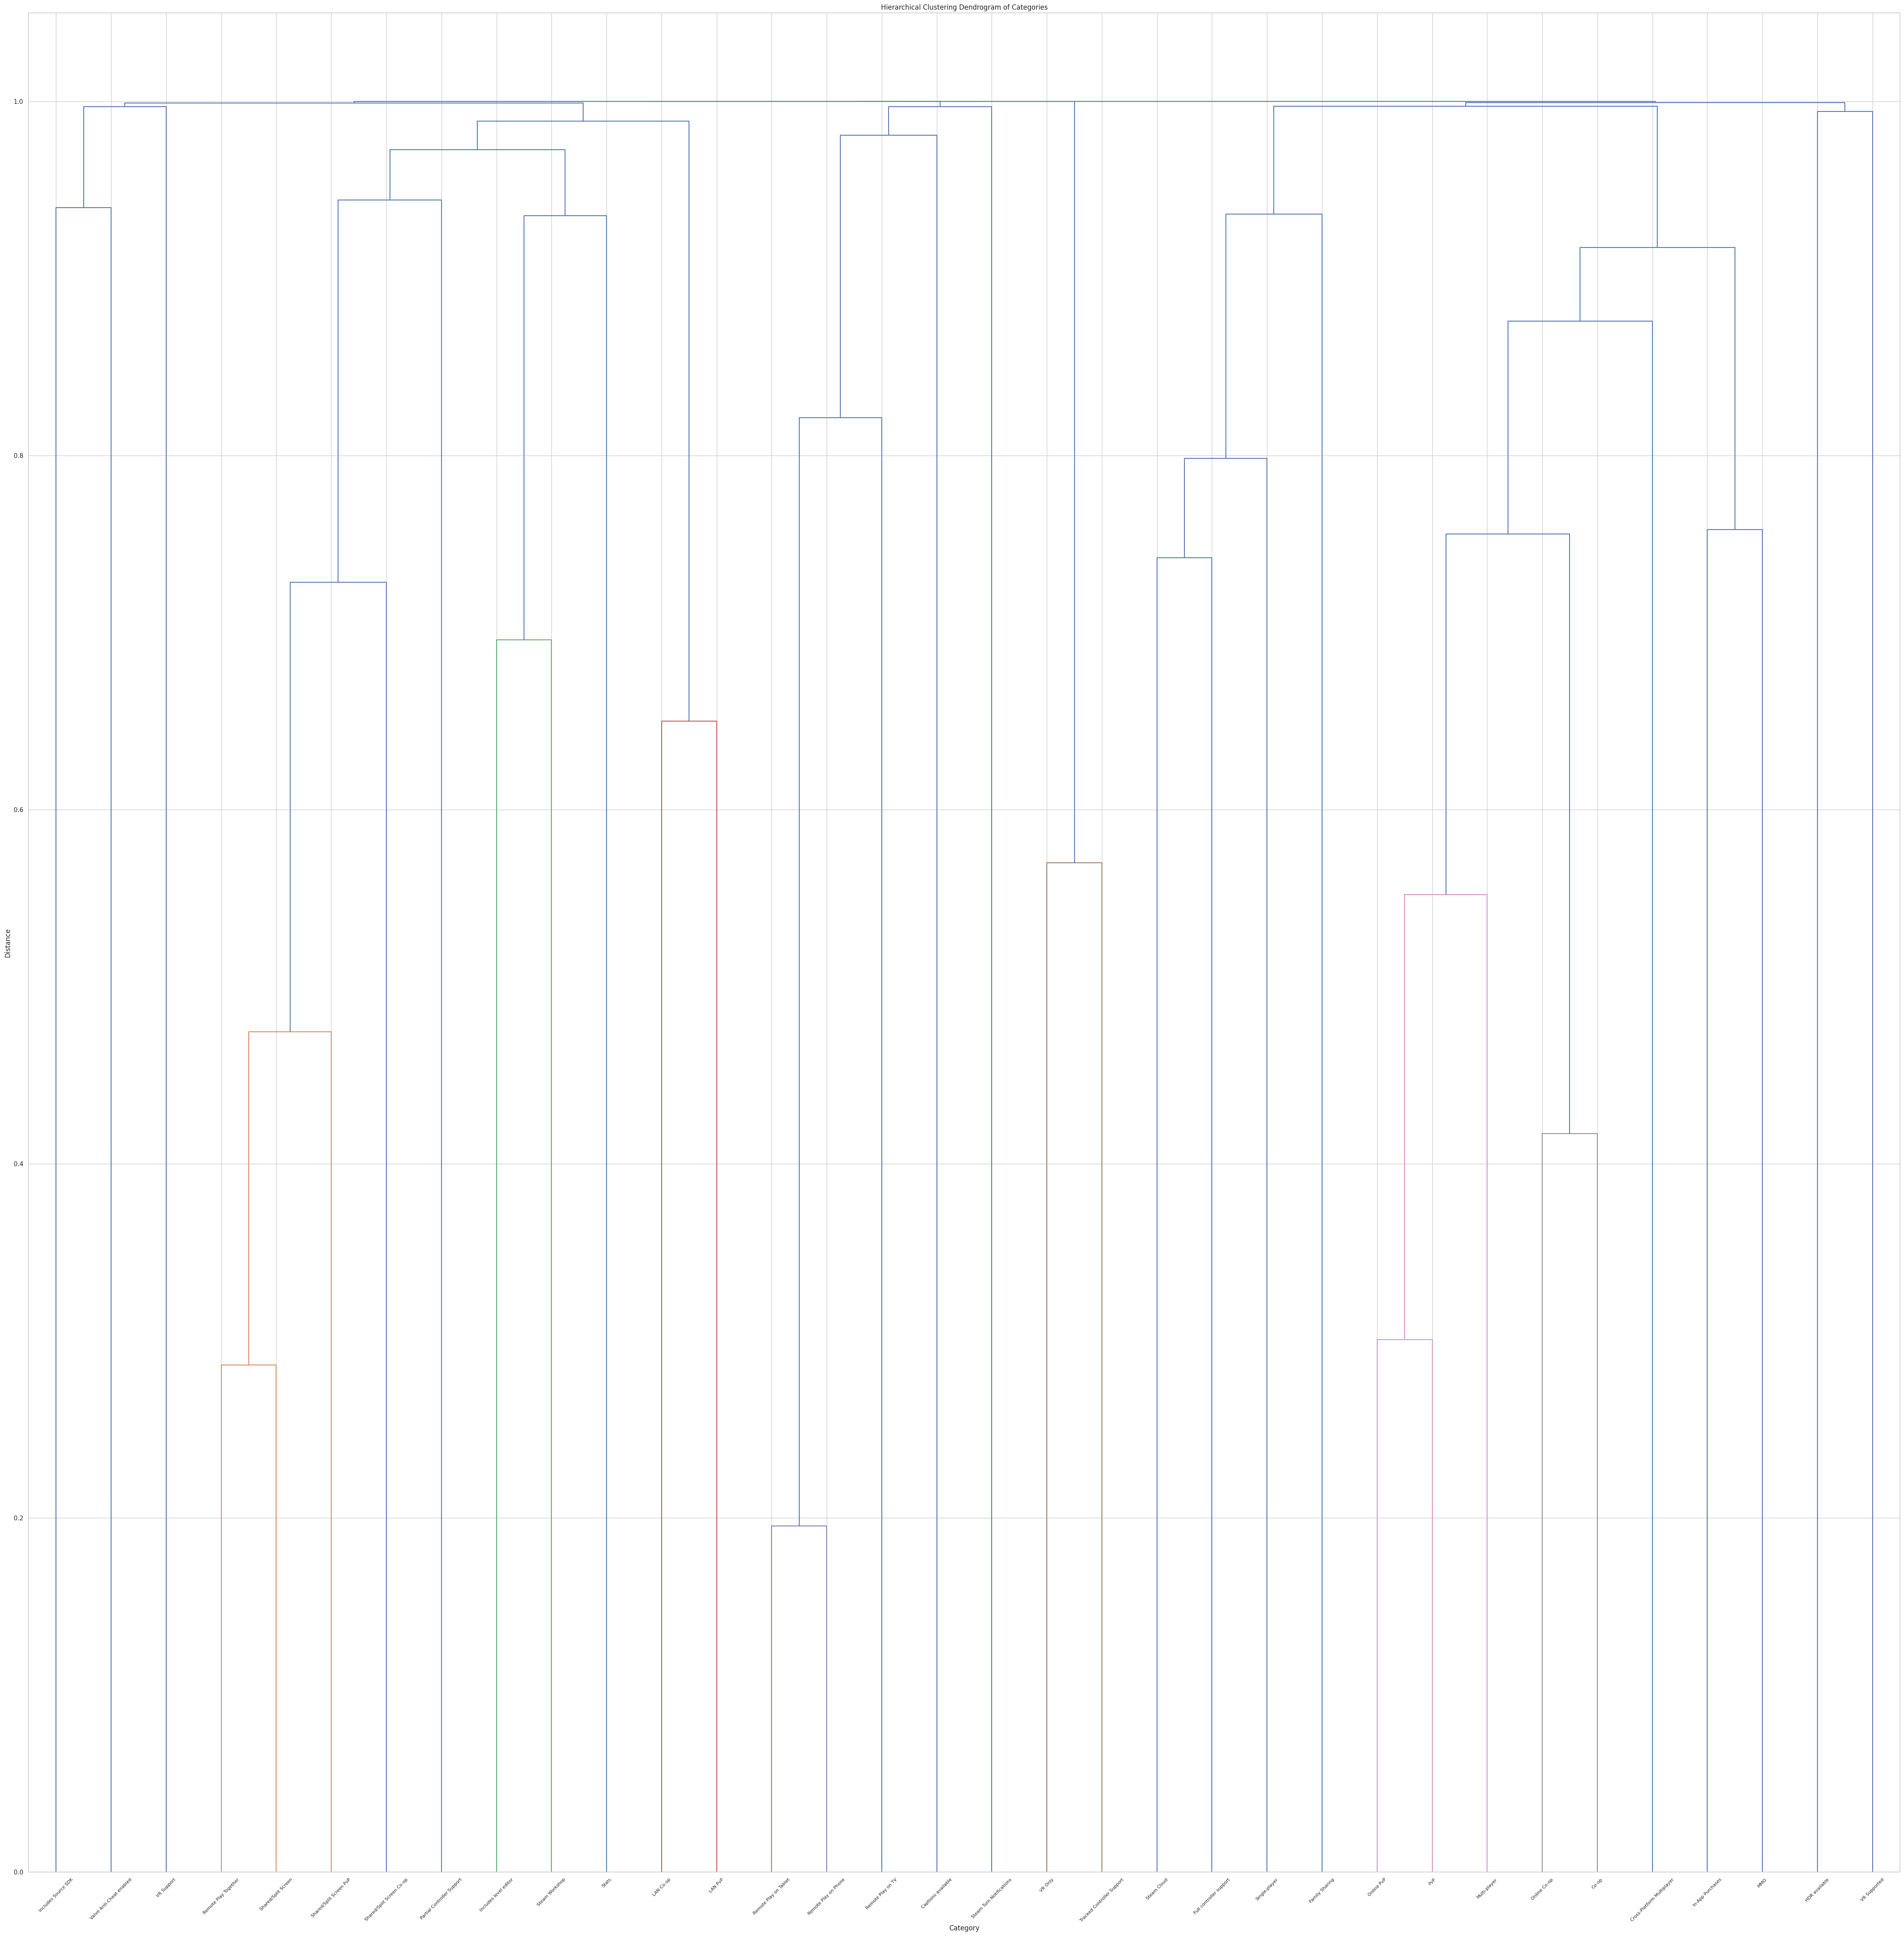

In [ ]:
linked = linkage(condensed_distances, method='complete')

plt.figure(figsize=(60, 60))
dendrogram(linked, labels=jaccard_distance_matrix.index, orientation='top', distance_sort='descending', show_leaf_counts=True)
plt.title('Hierarchical Clustering Dendrogram of Categories')
plt.xlabel('Category')
plt.ylabel('Distance')
plt.show()

From the Dendrogram above, we want to transform this visual hierarchy into actual clusters. We would employ the Silhouette method to identify the cut that provides the best clustering as measured by the output Silhoette Score. We choose thresholds between 0.3 and 1.0 as beyond 1.0 only one clustering is formed and we bound it by 0.3 as the the silhouette score requires at least 2 clusters and fewer than the total number of samples for meaningful computation:

In [ ]:
thresholds = np.linspace(0.3, 1.0, 1000)
best_threshold = None
best_score = -1
best_labels = None

for t in thresholds:
    labels = fcluster(linked, t=t, criterion='distance')
    dist_array = jaccard_distance_matrix.values

    if len(np.unique(labels)) > 1:
        score = silhouette_score(dist_array, labels, metric='precomputed')
        print(f"Threshold: {t:.2f}, Silhouette Score: {score:.4f}")

        if score > best_score:
            best_score = score
            best_threshold = t
            best_labels = labels
    else:
        print(f"Threshold: {t:.2f}, only one cluster formed, skipping silhouette.")

print("\nBest threshold based on Silhouette Score:", best_threshold)
print("Best Silhouette Score:", best_score)

cluster_assignments = pd.DataFrame({
    'Category': jaccard_distance_matrix.index,
    'Cluster': best_labels
}).sort_values('Cluster')

print(cluster_assignments)

Threshold: 0.30, Silhouette Score: 0.0670
Threshold: 0.30, Silhouette Score: 0.0670
Threshold: 0.30, Silhouette Score: 0.0858
Threshold: 0.30, Silhouette Score: 0.0858
Threshold: 0.30, Silhouette Score: 0.0858
Threshold: 0.30, Silhouette Score: 0.0858
Threshold: 0.30, Silhouette Score: 0.0858
Threshold: 0.30, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.31, Silhouette Score: 0.0858
Threshold: 0.32, Silhouette Score: 0.0858
Threshold: 0.32, Silhouette Score:

Now, with the clustering results and the heatmap correlation we got from the previous steps, we want to use our results to combine the category attrbutes in our dataset. We agreed with the clustering of Remote Play on Phone and Remote Play on Tablet, due to their high correlation in the heatmap of 0.89, the clustering of Shared Split Screen and Remote Play Together also due to their high correlation of 0.82 in the heatmap, the clustering of Co-op and Online Co-op due to their high correlation and general association (Online Co-op is a subset of Co-op), and the clustering of of PvP and online PvP by the same logic. However, we disagreed on clustering of MMO and In-App Purchases because of their low correlation of 0.39. Additionally, we decided to keep Multiplayer as a separate category as though it is a superset of the PvP and Co-op categories, it is so broad we felt like clustering all the Multiplayer modes together would over-generalize our data. On the other hand, we decided to cluster Shared/Split Screen Co-op and PvP to their respective Co-op and PvP categories to keep the Co-op and PvP categories more compact, and we choose to also group the LAN PvP and Co-op categories as a cluster as from a lot of games that offer LAN support often doesn't have the PvP or Co-op category label, also as represented by their low correlation to the other PvP/Co-op categories, hence we decided to group them together due to their moderate correlation and the results we obtained from hierarchical clustering. We grouped the attributes/columns together in the dataframe, as shown below:

In [ ]:
steam_df['Remote Play (Phone or Tablet)'] = steam_df['Remote Play on Phone'] | steam_df['Remote Play on Tablet']

steam_df['Shared/Split Screen and Remote Play Together'] = (
    steam_df['Shared/Split Screen'] |
    steam_df['Remote Play Together']
)

steam_df['Co-op (Online or Offline)'] = steam_df['Online Co-op'] | steam_df['Co-op'] | steam_df['Shared/Split Screen Co-op']
steam_df['PvP (Online or Offline)'] = steam_df['Online PvP'] | steam_df['PvP'] | steam_df['Shared/Split Screen PvP']

steam_df['LAN Support'] = steam_df['LAN PvP'] | steam_df['LAN Co-op']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 89838 entries, 0 to 89837
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   app_id                                        89838 non-null  int64  
 1   name                                          89838 non-null  string 
 2   required_age                                  89838 non-null  int64  
 3   price                                         89838 non-null  float64
 4   dlc_count                                     89838 non-null  int64  
 5   windows                                       89838 non-null  boolean
 6   mac                                           89838 non-null  boolean
 7   linux                                         89838 non-null  boolean
 8   achievements                                  89838 non-null  int64  
 9   packages                                      89838 non-null 

After grouping the columns together and finising our feature engineering on the categories attribute, we would drop the merged columns as ell as the categories column to keep our dataframe clean.

In [ ]:
cols_to_drop = [
    'Remote Play on Phone',
    'Remote Play on Tablet',
    'LAN PvP',
    'LAN Co-op',
    'Shared/Split Screen',
    'Shared/Split Screen PvP',
    'Shared/Split Screen Co-op',
    'Remote Play Together',
    'Online Co-op',
    'Co-op',
    'Online PvP',
    'PvP',
    'categories'
]

steam_df = steam_df.drop(columns=cols_to_drop)

In summary, our approach to EDA and feature engineering of the categories attribute balanced domain knowledge, statistical analysis, and computational techniques. By first cleaning and encoding categories, we created a robust set of binary features easily integrable into various analytical frameworks. The correlation and hierarchical clustering analyses guided strategic feature grouping, ensuring a leaner and more semantically meaningful representation of a game’s features.

The key advantages of this process include:

1. **Improved Data Quality:** Removal of negligible and post-success categories prevents distortions in subsequent modeling.

2. **Enhanced Interpretability:** Binary features and thoughtfully constructed clusters make it easier to understand how certain gaming features relate to success or popularity.

3. **Reduced Dimensionality and Overfitting Risk:** By merging correlated categories, we simplified the feature space, reducing the risk of collinearity and enhancing model generalization.

4. **Robust Foundation for Advanced Modeling:** With this cleaner and more compact feature set, we can more confidently apply machine learning models, analyze feature importance, and draw actionable insights about what gameplay modes and features resonate with players.

Ultimately, the careful EDA and feature engineering performed here set a strong foundation for more accurate, interpretable, and impactful analyses of how different categories influence a game’s performance on Steam.

## 4.6 OS Support EDA and Feature Engineering

Although Windows has been the most popular operarting system when it comes to gaming, with it dominating much of the gaming desktop/laptop market, considering the rise in popularity of macOS and the stable presence of Linux in the OS ecosystem, we want to explore whether adding additional support to macOS and Linux would be a significant contributing factor to a video game's success on steam.

To do so, let us first explore how different combinations of OS support affect the median playtime forever of a game. Due to Windows support prevalence in the gaming market, we wanted to see whether there exists games that does not have windows support (only has macOS support, linux support, or both) before preceding to the analysis. Therefore, we created a mask using the windows column to filter the dataframe to see all rows that have no windows support, as shown below:

In [ ]:
windows_false_mask = ~steam_df['windows']

# Filter the DataFrame using the mask
windows_false_df = steam_df[windows_false_mask]

app_id                                      name  required_age  \
522     461550       Typing Instructor Platinum 21 - Mac             0   
1223   1659790                                Fall Tower             0   
1905    805260                                    PICNIC             0   
3747    569050                Paul Pixel - The Awakening             0   
4419    364380                       CINEVEO - VR Cinema             0   
6539    594550          Arma: Cold War Assault Mac/Linux            17   
18259  1065900                                  Celtreos             0   
22268   461530                          CV Maker for Mac             0   
29433  1634660                                     fight             0   
33240   842350            Escape Code - Coding Adventure             0   
39300   694180                              MobileZombie             0   
43956  1965000                   Hotel Manager Simulator             0   
44182   214630     Call of Duty: Black Ops - Mac Edition            18   
44269  1693750                                  Ironfell             0   
45291  1715670                 Swinario Super Bros. Play             0   
45495   644300  Family Tree Heritage™ Platinum 15 –  Mac             0   
49746   443320     Family Tree Heritage Platinum 9 - Mac             0   
50443  1505830                               Evil Shogun             0   
55441   492520                     Resume Maker® for Mac             0   
60882  2155800                            FOREST DONGMUL             0   
70530  2198560                                   Mancala             0   
72717   392040                                 War Blade             0   
76173  2507880                                   Sunbeam             0   
85370  2951560                              Shoot or Die             0   
86625  2404100                                        女王             0   

        price  dlc_count  windows    mac  linux  achievements  \
522     29.99          0    False   True  False             0   
1223     0.99          0    False   True  False             0   
1905     0.00          0    False  False   True             0   
3747     3.99          0    False   True  False             0   
4419    29.99          0    False  False   True             0   
6539     4.99          0    False   True   True             0   
18259    9.99          1    False   True  False             0   
22268   19.99          0    False   True  False             0   
29433  199.99          0    False   True  False             0   
33240    9.99          0    False   True  False             0   
39300    0.00          0    False   True  False             0   
43956    5.99          0    False   True  False             0   
44182    0.00          0    False   True  False            68   
44269    0.00          0    False   True  False             0   
45291    4.99          0    False  False   True             0   
45495   49.99          0    False   True  False             0   
49746    0.00          0    False   True  False             0   
50443    1.00          0    False   True  False             0   
55441   11.99          0    False   True  False             0   
60882    0.00          0    False   True  False             0   
70530    6.79          0    False  False   True             0   
72717    0.00          0    False   True  False             0   
76173    4.99          0    False   True  False            19   
85370    0.00          0    False   True  False             0   
86625    0.00          0    False  False   True             0   

                                                packages  \
522    [{'title': 'Buy Typing Instructor Platinum 21 ...   
1223   [{'title': 'Buy Fall Tower', 'description': ''...   
1905                                                  []   
3747   [{'title': 'Buy Paul Pixel - The Awakening', '...   
4419   [{'title': 'Buy CINEVEO - VR Cinema', 'descrip...   
6539   [{'title': 'Buy Arma: Col

The filtered dataframe above suggests that there does exist games with no Windows support. However, there are a very limited number of them, for example, only one game in the whole dataframe that has both macOS and Linux support. Hence, the limited samples that falls under the no windows support categories would most likely produce inaccurate results. To confirm exactly the number of games that fall under each OS support categories, let us write a program `determine_os_support` that would list out the detailed OS support for each row, which would be applied on a separate copy of the `steam_df` dataframe on an additional column called `os_support_category`. We can then use this column to find the number of games that fall under each OS support categories, as well as creating an interactive treemap chart to better visualize this distribution:

In [ ]:
def determine_os_support(row):
    windows = row['windows']
    mac = row['mac']
    linux = row['linux']

    supported_os = []
    if windows:
        supported_os.append('Windows')
    if mac:
        supported_os.append('Mac')
    if linux:
        supported_os.append('Linux')

    if len(supported_os) == 1:
        return f"{supported_os[0]} Only"
    elif len(supported_os) == 2:
        return f"{supported_os[0]} & {supported_os[1]}"
    elif len(supported_os) == 3:
        return "Windows, Mac & Linux"
    else:
        return "No OS Support"

os_support_steam_df = steam_df.copy()
os_support_steam_df['os_support_category'] = os_support_steam_df.apply(determine_os_support, axis=1)


# Step 2: Calculate the distribution
os_distribution = os_support_steam_df['os_support_category'].value_counts()

# Optional: Calculate percentages
os_distribution_percentage = os_support_steam_df['os_support_category'].value_counts(normalize=True) * 100

# Step 3: Print the distribution
print("OS Support Distribution (Counts):")
print(os_distribution)
print("\nOS Support Distribution (Percentages):")
print(os_distribution_percentage.round(2))

OS Support Distribution (Counts):
os_support_category
Windows Only            69621
Windows, Mac & Linux     9098
Windows & Mac            8161
Windows & Linux          2933
Mac Only                   19
Linux Only                  5
Mac & Linux                 1
Name: count, dtype: int64

OS Support Distribution (Percentages):
os_support_category
Windows Only            77.50
Windows, Mac & Linux    10.13
Windows & Mac            9.08
Windows & Linux          3.26
Mac Only                 0.02
Linux Only               0.01
Mac & Linux              0.00
Name: proportion, dtype: float64


app_id                    name  required_age  price  dlc_count  \
0        20200        Galactic Bowling             0  19.99          0   
1       655370            Train Bandit             0   0.99          0   
2      1732930            Jolt Project             0   4.99          0   
3      1355720                Henosis™             0   5.99          0   
4      1139950   Two Weeks in Painland             0   0.00          0   
...        ...                     ...           ...    ...        ...   
89833  3165130             SLIME ORDER             0   0.99          0   
89834  3080940  Femdom Game World: Mom             0   4.19          0   
89835  2593970             Blocky Farm             0   8.99          0   
89836  3124670       Escape The Garage             0   4.99          0   
89837  3054200              Lober Lobe             0   4.49          0   

       windows    mac  linux  achievements  \
0         True  False  False            30   
1         True   True  False            12   
2         True  False  False             0   
3         True   True   True             0   
4         True   True  False            17   
...        ...    ...    ...           ...   
89833     True  False  False             1   
89834     True  False  False             0   
89835     True  False  False            21   
89836     True  False  False            23   
89837     True  False  False           100   

                                                packages  \
0      [{'title': 'Buy Galactic Bowling', 'descriptio...   
1      [{'title': 'Buy Train Bandit', 'description': ...   
2      [{'title': 'Buy Jolt Project', 'description': ...   
3      [{'title': 'Buy Henosis™', 'description': '', ...   
4                                                     []   
...                                                  ...   
89833  [{'title': 'Buy SLIME ORDER', 'description': '...   
89834  [{'title': 'Buy Femdom Game World: Mom', 'desc...   
89835  [{'title': 'Buy Blocky Farm', 'description': '...   
89836  [{'title': 'Buy Escape The Garage', 'descripti...   
89837  [{'title': 'Buy Lober Lobe', 'description': ''...   

                          developers                     publishers  \
0            [Perpetual FX Creative]        [Perpetual FX Creative]   
1                     [Rusty Moyher]                 [Wild Rooster]   
2                    [Campião Games]                [Campião Games]   
3                [Odd Critter Games]            [Odd Critter Games]   
4                    [Unusual Games]                [Unusual Games]   
...                              ...                            ...   
89833                        [かべろくん]                        [かべろくん]   
89834            [Femdom Game World]            [Femdom Game World]   
89835  [Forever Entertainment S. A.]  [Forever Entertainment S. A.]   
89836                       [CryneX]         [CryneX, CryTechGames]   
89837      [James H. Van der Meulen]          [Trash Vomit Studios]   

       median_playtime_forever  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            0   
...                        ...   
89833                        0   
89834                        0   
89835                        0   
89836                        0   
89837                        0   

                                                    tags  is_successful  \
0      {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
1      {'Indie': 109, 'Action': 103, 'Pixel Graphics'...              0   
2                                                     []              0   
3      {'2D Platformer': 161, 'Atmospheric': 154, 'Su...              0   
4      {'Indie': 42, 'Adventure': 41, 'Nudity': 22, '...              0   
...                                                  ...            ...   
89833  {'Casual': 68, 'Puzzle': 42, 'Point & Click': ...  

In [ ]:
import plotly.graph_objects as go

data = {
    'os_support_category': [
        'Windows Only',
        'Windows, Mac & Linux',
        'Windows & Mac',
        'Windows & Linux',
        'Other'
    ],
    'Number of Games': [69621, 9098, 8161, 2933, 25]
}
df = pd.DataFrame(data)

total_games = df['Number of Games'].sum()

df['Percentage'] = (df['Number of Games'] / total_games) * 100

windows_mac_linux_pct = df.loc[df['os_support_category'] == 'Windows, Mac & Linux', 'Percentage'].values[0]
windows_mac_pct = df.loc[df['os_support_category'] == 'Windows & Mac', 'Percentage'].values[0]
windows_linux_pct = df.loc[df['os_support_category'] == 'Windows & Linux', 'Percentage'].values[0]
windows_only_pct = df.loc[df['os_support_category'] == 'Windows Only', 'Percentage'].values[0]
other_pct = df.loc[df['os_support_category'] == 'Other', 'Percentage'].values[0]

df_all_trees = pd.DataFrame([
    dict(id='total', parent='', value=100, color=total_games),
    dict(id='Windows with additional support', parent='total', value=(windows_mac_linux_pct + windows_linux_pct + windows_mac_pct), color=(9133+8263+2944)),
    dict(id='Windows, Mac & Linux', parent='Windows with additional support', value=windows_mac_linux_pct, color=9133),
    dict(id='Windows & Mac', parent='Windows with additional support', value=windows_mac_pct, color=8263),
    dict(id='Windows & Linux', parent='Windows with additional support', value=windows_linux_pct, color=2944),
    dict(id='Windows Only', parent='total', value=windows_only_pct, color=70545),
    dict(id='Other', parent='total', value=other_pct, color=31)
])

average_color = 18515

fig = go.Figure(go.Treemap(
    labels=df_all_trees['id'],
    parents=df_all_trees['parent'],
    values=df_all_trees['value'],
    branchvalues='total',
    marker=dict(
        colors=df_all_trees['color'],
        colorscale='deep',
        cmid=average_color
    ),
    customdata=df_all_trees['color'],
    hovertemplate='<b>%{label}</b><br>' +
                  'Percentage: %{value:.2f}%<br>' +
                  'Number of Games: %{color} Games<extra></extra>',
    name=''
))

fig.update_traces(
    texttemplate='%{label}<br>%{value:.2f}%<br>%{customdata} Games',
    textposition='middle center',
    textfont=dict(color='white', size=14)
)

fig.update_layout(
    title='OS Support Distribution (Treemap)',
    title_font_weight='bold',
    title_pad_l=450,
    margin=dict(t=60, l=25, r=25, b=25)
)

fig.show()

From above, we can see that windows support is still the predominant trend for most of the games in steam, with exactly 71833 games in Steam, which is 77.69% of the total number of games in Steam that only has Windows Support. And only around 0.04% of the games in Steam (around 33 entries) have exclusive support for macOS and Linux, which has a distribution so small thatb it could not be visualized on the treemap. This observation makes sense as Windows is already the most established gaming OS, giving more incentive for developers to create games based on the Windows OS, while extending support to macOS and Linux also requires more time and resources as well, making it a difficult option for most indie developers or small game companies. Hence, considering the extremely low representation of the no Windows support category of games, we would exclude them from the dataset to ensure cleaner and more meaningful analysis.

The below bar graph is used to show average median playtime for games that fall under each of the OS support categories, which we can use to identify some interesting findings as well as some issues that comes with the inclusion of no Windows support category of games in our dataset. As we can see, since the representation for the macOS or Linux categories are so low, it seems like from the visualization that games that offer support for only macOS and Linux are the most successful games (as we defined the median playtime forever attribute to be our success metric). While in reality, there is only one game in the whole dataset that falls under this os support category, so the average median playtime for the category is the median playtime of that game. Therefore, this inaccuracy suggests that we should drop the no windows support os categories. Another interesting finding that we discovered from the bar graph is that all the categories that have additional support other OS aside from Windows all seem to have higher median playtime than only windows support.

<ipython-input-196-579c2b324c5e>:14: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




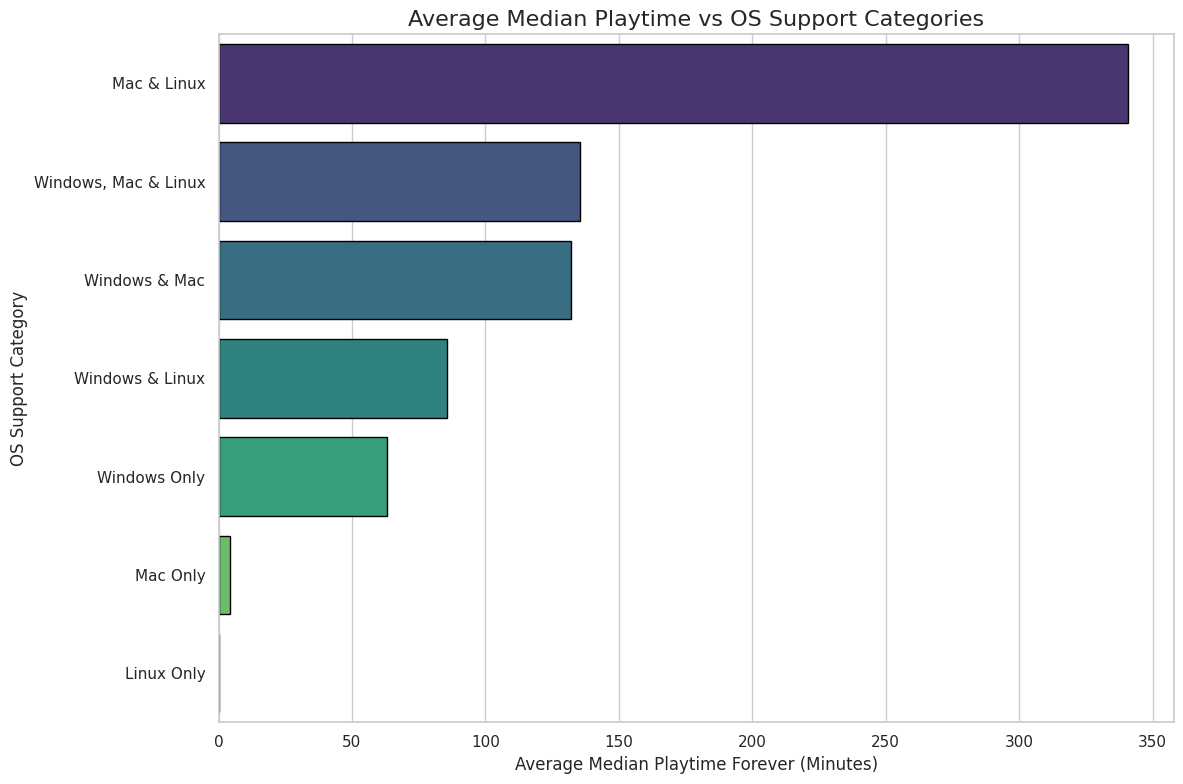

In [ ]:
os_playtime_stats = os_support_steam_df.groupby('os_support_category').agg(
    median_playtime=('median_playtime_forever', 'mean'),
    number_of_games=('median_playtime_forever', 'count')
).reset_index()

# Optional: Sort the DataFrame by average playtime descending
os_playtime_stats = os_playtime_stats.sort_values(by='median_playtime', ascending=False)


sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))

# Create the bar plot
bar_plot = sns.barplot(
    x='median_playtime',
    y='os_support_category',
    data=os_playtime_stats,
    palette='viridis',
    edgecolor='black'
)


# Set labels and title
plt.xlabel('Average Median Playtime Forever (Minutes)', fontsize=12)
plt.ylabel('OS Support Category', fontsize=12)
plt.title('Average Median Playtime vs OS Support Categories', fontsize=16)

# Adjust layout
plt.tight_layout()

# Display the plot
plt.show()



In [ ]:
steam_df = steam_df[steam_df['windows']]

Considering the relatively much lower number of games that fall under these categories, we would group them all into the "windows with additional support" category for further analysis to investigate whether adding additional os support aside from windows would bring a game more success. We would create a new column in our dataframe called `windows_only` to encode the category of games with only window OS support as true/1 and games with additional os support other than windows as false/0. We believe doing so offers the following advantages:

- **Simplicity and Interpretability**:
Converting complex OS support patterns into a single binary column significantly simplifies modeling and analytics tasks. Instead of juggling multiple OS columns or categories, analysts can rely on one straightforward feature that indicates whether a game is exclusive to Windows or not.

- **Reduced Dimensionality**:
By collapsing multiple columns (windows, mac, linux) and their various combinations into a single binary feature, we reduce the dimensionality of the dataset. Lower dimensionality often translates to less complexity and easier model training, especially when working with large datasets or complex algorithms.

- **Mitigation of Sparsity and Rare Categories**:
Rare categories (like Linux-only or Mac-only support) introduced sparsity and instability into our dataset. Encoding OS support into a binary attribute eliminates categories with low frequency counts. This ensures that subsequent modeling will not be biased by these rare scenarios, improving the statistical robustness of downstream analyses.

In [ ]:
steam_df['windows_only'] = (
    steam_df['windows'] &
    ~steam_df['mac'] &
    ~steam_df['linux']
)

app_id                    name  required_age  price  dlc_count  \
0        20200        Galactic Bowling             0  19.99          0   
1       655370            Train Bandit             0   0.99          0   
2      1732930            Jolt Project             0   4.99          0   
3      1355720                Henosis™             0   5.99          0   
4      1139950   Two Weeks in Painland             0   0.00          0   
...        ...                     ...           ...    ...        ...   
89833  3165130             SLIME ORDER             0   0.99          0   
89834  3080940  Femdom Game World: Mom             0   4.19          0   
89835  2593970             Blocky Farm             0   8.99          0   
89836  3124670       Escape The Garage             0   4.99          0   
89837  3054200              Lober Lobe             0   4.49          0   

       windows    mac  linux  achievements  \
0         True  False  False            30   
1         True   True  False            12   
2         True  False  False             0   
3         True   True   True             0   
4         True   True  False            17   
...        ...    ...    ...           ...   
89833     True  False  False             1   
89834     True  False  False             0   
89835     True  False  False            21   
89836     True  False  False            23   
89837     True  False  False           100   

                                                packages  \
0      [{'title': 'Buy Galactic Bowling', 'descriptio...   
1      [{'title': 'Buy Train Bandit', 'description': ...   
2      [{'title': 'Buy Jolt Project', 'description': ...   
3      [{'title': 'Buy Henosis™', 'description': '', ...   
4                                                     []   
...                                                  ...   
89833  [{'title': 'Buy SLIME ORDER', 'description': '...   
89834  [{'title': 'Buy Femdom Game World: Mom', 'desc...   
89835  [{'title': 'Buy Blocky Farm', 'description': '...   
89836  [{'title': 'Buy Escape The Garage', 'descripti...   
89837  [{'title': 'Buy Lober Lobe', 'description': ''...   

                          developers                     publishers  \
0            [Perpetual FX Creative]        [Perpetual FX Creative]   
1                     [Rusty Moyher]                 [Wild Rooster]   
2                    [Campião Games]                [Campião Games]   
3                [Odd Critter Games]            [Odd Critter Games]   
4                    [Unusual Games]                [Unusual Games]   
...                              ...                            ...   
89833                        [かべろくん]                        [かべろくん]   
89834            [Femdom Game World]            [Femdom Game World]   
89835  [Forever Entertainment S. A.]  [Forever Entertainment S. A.]   
89836                       [CryneX]         [CryneX, CryTechGames]   
89837      [James H. Van der Meulen]          [Trash Vomit Studios]   

       median_playtime_forever  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            0   
...                        ...   
89833                        0   
89834                        0   
89835                        0   
89836                        0   
89837                        0   

                                                    tags  is_successful  \
0      {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
1      {'Indie': 109, 'Action': 103, 'Pixel Graphics'...              0   
2                                                     []              0   
3      {'2D Platformer': 161, 'Atmospheric': 154, 'Su...              0   
4      {'Indie': 42, 'Adventure': 41, 'Nudity': 22, '...              0   
...                                                  ...            ...   
89833  {'Casual': 68, 'Puzzle': 42, 'Point & Click': ...  

Now, after successfully encoding the `windows_only` column, let us take a look at how having only Windows OS support vs offering additional OS support relates to the median playtime forever of a game. Considering that a huge majority of the game has 0 median playtime, we couldn't use the median of the median playtime for games falling in the Windows Only and Windows and Additional OS support categories as they offer no visual data. Therefore, we would first create a bar graph that compares the categories of OS support to the average median playtime of games, then create a violin plot with box and data points to supplement additional information about the distribution of data using Plotly. Additionally, for creating the graphs, we did some extensive search on Steam and SteamDB to verify whether for data points that have absurdly high median playtimes, which we were able to confirm that all the 15 games above 30k playtime has incorrect data. Therefore, we filtered them out for offer better accuracy for our graph plots.

<ipython-input-199-861db1e6289f>:25: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




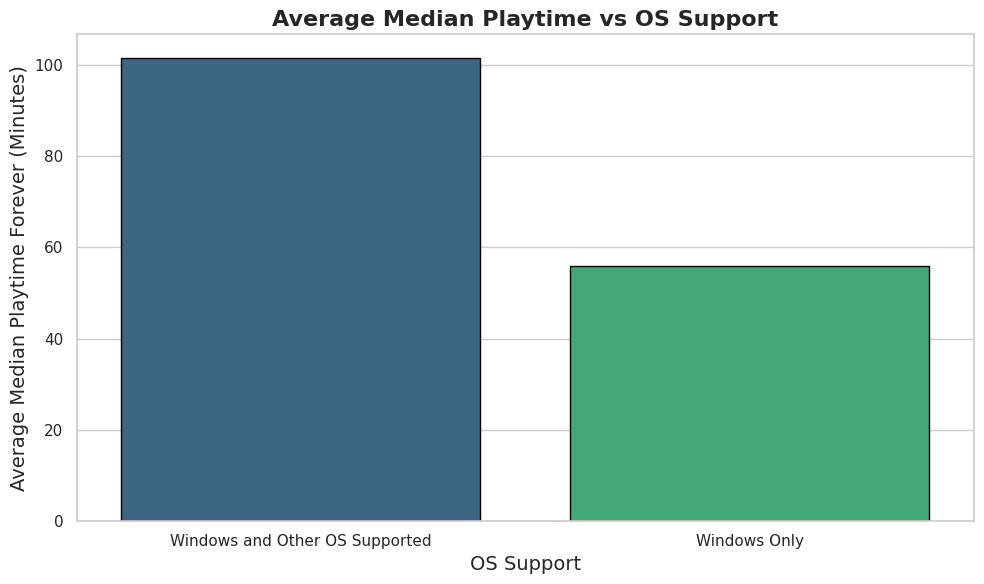

In [ ]:
steam_df = steam_df[steam_df['median_playtime_forever'] <= 30000] # 15 games that have > 30000 playtime, which I have searched and confirmed as outliers

average_playtime = steam_df.groupby('windows_only').agg(
    median_playtime=('median_playtime_forever', 'mean'),
    number_of_games=('median_playtime_forever', 'count')
).reset_index()

label_mapping = {
    True: 'Windows Only',
    False: 'Windows and Other OS Supported'
}

average_playtime['os_support'] = average_playtime['windows_only'].map(label_mapping)


average_playtime = average_playtime[['os_support', 'median_playtime', 'number_of_games']]


plt.figure(figsize=(10, 6))

bar_plot = sns.barplot(
    x='os_support',
    y='median_playtime',
    data=average_playtime,
    palette='viridis',
    edgecolor='black'
)

plt.title('Average Median Playtime vs OS Support', fontsize=16, fontweight='bold')
plt.xlabel('OS Support', fontsize=14)
plt.ylabel('Average Median Playtime Forever (Minutes)', fontsize=14)


plt.tight_layout()

plt.show()

From the bar chart above, we can make the following interpretations:
- Games available on multiple platforms (Windows and others) tend to have higher engagement or longer median playtimes. This could mean that games developed with broader platform support attract more committed player communities or are of a type that players stick with longer.
- Another possible explanation is that titles engineered for multiple OS platforms may be from developers who invest more heavily in robust features, updates, or long-term content support, all of which can encourage players to keep returning to the game.
- Conversely, Windows-only games, on average, show a shorter median playtime. This might be due to a higher volume of smaller or more casual games, early prototypes (e.g., early access titles), or less polished indie offerings that do not retain players for extended sessions.

In [ ]:
import plotly.express as px


label_mapping = {
    True: 'Windows Only',
    False: 'Windows and Other OS Supported'
}

steam_df['os_support'] = steam_df['windows_only'].map(label_mapping)

fig = px.violin(
    steam_df,
    x='os_support',
    y='median_playtime_forever',
    box=True,
    points='all'
)

fig.update_layout(
    title='Distribution of Median Playtime Forever by OS Support',
    xaxis_title='OS Support',
    yaxis_title='Median Playtime Forever (Minutes)'
)

fig.show()


Now that we have performed our EDA and feature engineering on OS Support, we would drop the `windows`, `mac`, `linux`, and the additional `os_support` column that we used the map the `windows_only` true/false to the text corresponding to the bar graph and violin plot we created above.

In [ ]:
cols_to_drop = [
    'windows',
    'mac',
    'linux',
    'os_support'
]

steam_df = steam_df.drop(columns=cols_to_drop)

In conclusion, the careful EDA and feature engineering steps taken here—identifying dominant OS support patterns, acknowledging the negligible presence of non-Windows games, and ultimately simplifying OS support representation into a binary feature—ensure that subsequent analyses will be more simple, reliable and interpretable, providing reduced dimensionality and mitigation of sparse and rare categories (no OS support for windows). By focusing on a binary windows_only column, we preserve the most critical information about a game's OS support while mitigating the statistical noise and complexity introduced by extremely rare categories.

## 4.7 Price EDA and Feature Engineering


In this section, we conducted exploratory data analysis and feature engineering on the `price` column. The `price` column represents the cost of each game in USD, which is a critical factor influencing player purchasing decisions and engagement. To gain insights into its distribution and impact, we performed a thorough analysis, starting with an examination of the price range, summary statistics, and potential outliers.

After the initial EDA, we implemented a key transformation: converting the continuous `price` column into a categorical feature (`price_category`). This transformation simplifies analysis by grouping prices into logical bins, such as "Free," "Budget," "Moderate," and "Premium." This approach helps to address the wide variance in pricing and enables better exploration of relationships between price categories and other variables like playtime, achievements, and success metrics.

Through this analysis, we aim to uncover patterns in pricing strategies and their impact on player engagement and game performance.


In [ ]:
unique_prices = steam_df['price'].unique()
print(len(unique_prices))

655


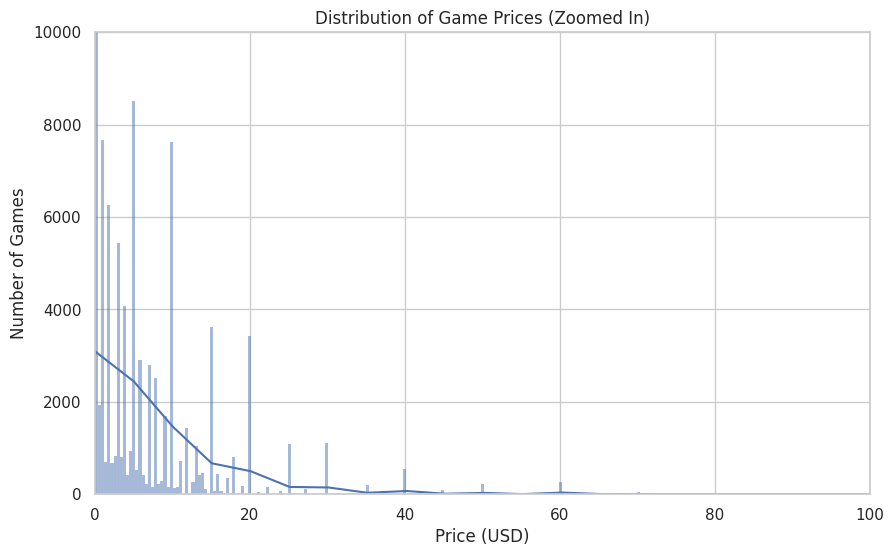

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=steam_df, x='price', kde=True)
plt.title('Distribution of Game Prices (Zoomed In)')
plt.xlabel('Price (USD)')
plt.ylabel('Number of Games')

# Set the x-axis limit from 0 to 1000
plt.xlim(0, 100)

# Set the y-axis limit (e.g., up to 5000 for demonstration)
plt.ylim(0, 10000)

plt.show()

This bar graph shows that games have a variety of prices ranging from 0 to 100. The majority of games are priced at less than 5, indicating that affordable games dominate the market. As the price increases, the number of games decreases significantly, with very few games priced above 50. This trend highlights a focus on low-cost pricing strategies, potentially to maximize accessibility and attract a larger player base.



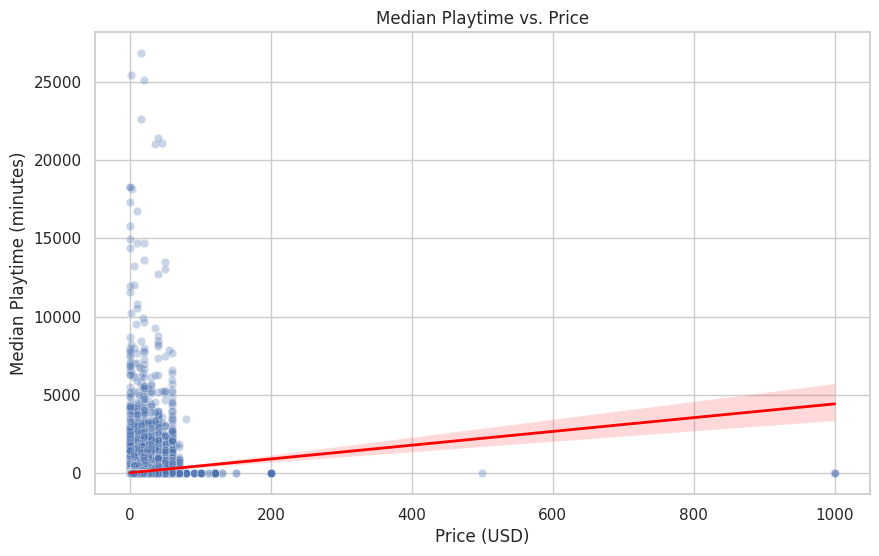

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=steam_df, x='price', y='median_playtime_forever', alpha=0.3)
sns.regplot(data=steam_df, x='price', y='median_playtime_forever', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Median Playtime vs. Price')
plt.xlabel('Price (USD)')
plt.ylabel('Median Playtime (minutes)')
plt.show()

**Takeaway:**
This scatterplot gives the impression that lower-priced games tend to foster higher median playtime. The cluster of points at the lower end of the price axis corresponds to a range of notably higher play durations, suggesting that making a game more affordable could potentially entice players to engage with it for longer periods.


In [ ]:
import pandas as pd

# Define bins and labels
bins = [-0.01, 1, 10, 30, float('inf')]
labels = ['Free', 'Budget', 'Moderate', 'Premium']

# Create a new column with categorized prices
steam_df['price_category'] = pd.cut(steam_df['price'], bins=bins, labels=labels)
# Drop old price column
steam_df = steam_df.drop(columns=['price'])

# Check the distribution of games in each category
print(steam_df['price_category'].value_counts())

price_category
Budget      48592
Free        23006
Moderate    16467
Premium      1733
Name: count, dtype: int64


app_id                    name  required_age  dlc_count  achievements  \
0        20200        Galactic Bowling             0          0            30   
1       655370            Train Bandit             0          0            12   
2      1732930            Jolt Project             0          0             0   
3      1355720                Henosis™             0          0             0   
4      1139950   Two Weeks in Painland             0          0            17   
...        ...                     ...           ...        ...           ...   
89833  3165130             SLIME ORDER             0          0             1   
89834  3080940  Femdom Game World: Mom             0          0             0   
89835  2593970             Blocky Farm             0          0            21   
89836  3124670       Escape The Garage             0          0            23   
89837  3054200              Lober Lobe             0          0           100   

                                                packages  \
0      [{'title': 'Buy Galactic Bowling', 'descriptio...   
1      [{'title': 'Buy Train Bandit', 'description': ...   
2      [{'title': 'Buy Jolt Project', 'description': ...   
3      [{'title': 'Buy Henosis™', 'description': '', ...   
4                                                     []   
...                                                  ...   
89833  [{'title': 'Buy SLIME ORDER', 'description': '...   
89834  [{'title': 'Buy Femdom Game World: Mom', 'desc...   
89835  [{'title': 'Buy Blocky Farm', 'description': '...   
89836  [{'title': 'Buy Escape The Garage', 'descripti...   
89837  [{'title': 'Buy Lober Lobe', 'description': ''...   

                          developers                     publishers  \
0            [Perpetual FX Creative]        [Perpetual FX Creative]   
1                     [Rusty Moyher]                 [Wild Rooster]   
2                    [Campião Games]                [Campião Games]   
3                [Odd Critter Games]            [Odd Critter Games]   
4                    [Unusual Games]                [Unusual Games]   
...                              ...                            ...   
89833                        [かべろくん]                        [かべろくん]   
89834            [Femdom Game World]            [Femdom Game World]   
89835  [Forever Entertainment S. A.]  [Forever Entertainment S. A.]   
89836                       [CryneX]         [CryneX, CryTechGames]   
89837      [James H. Van der Meulen]          [Trash Vomit Studios]   

       median_playtime_forever  \
0                            0   
1                            0   
2                            0   
3                            0   
4                            0   
...                        ...   
89833                        0   
89834                        0   
89835                        0   
89836                        0   
89837                        0   

                                                    tags  is_successful  \
0      {'Indie': 22, 'Casual': 21, 'Sports': 21, 'Bow...              0   
1      {'Indie': 109, 'Action': 103, 'Pixel Graphics'...              0   
2                                                     []              0   
3      {'2D Platformer': 161, 'Atmospheric': 154, 'Su...              0   
4      {'Indie': 42, 'Adventure': 41, 'Nudity': 22, '...              0   
...                                                  ...            ...   
89833  {'Casual': 68, 'Puzzle': 42, 'Point & Click': ...              0   
89834                                                 []              0   
89835                                                 []              0   
89836                                                 []              0   
89837                                                 []              0   

       has_audio  language_support_tier  Action  Adventure  Casual  \
0              0                      1       0          0       1   
1          

**Rationale for Categorizing Prices:**

Handling raw price values can be challenging due to floating-point precision issues and the sheer variety of price points. By grouping prices into categorical bins, we achieve several benefits:

1. **Enhanced Interpretability:**  
   Instead of dealing with a large range of similar values (e.g., \$4.99 vs \$5.00), categorization simplifies these values into meaningful labels such as "Budget" or "Moderate." This makes it easier to communicate findings to stakeholders.

2. **Reduced Noise:**  
   Minor differences in price (like \$9.99 vs \$10.00) often have little practical difference in terms of player behavior. Aggregating prices into ranges reduces the impact of tiny variations that would otherwise complicate analyses.

3. **Improved Data Visualization:**  
   Visualizing categories is more intuitive and visually clear. Bar charts or box plots of categorical price groups are easier to interpret than trying to discern patterns from many closely clustered price points.

4. **Facilitated Statistical Analysis:**  
   Converting a continuous variable into categories can make it easier to apply certain non-parametric statistical tests or to segment the dataset into groups for comparative studies.

Overall, categorizing prices into logical bands helps streamline analysis, enhance clarity, and reduce the complexity introduced by floating-point precision and minor price variations.

## 4.8 Required Age EDA and Feature Engineering

The price of a game is a critical factor influencing its accessibility, popularity, and overall success in the market. Understanding the pricing strategies and their relationship with other game attributes, such as player engagement and playtime, can provide valuable insights into consumer behavior and developer decisions.

Exploring the `price` column helps address several key questions:
- What are the common price points for games in the dataset, and how are they distributed?
- How does price relate to other metrics like median playtime, achievements, or genres?
- Are there any trends or patterns in how pricing impacts game success?
- Do specific pricing strategies (e.g., free-to-play vs. premium) correlate with certain player behaviors?

By analyzing the price data, we aim to uncover trends and anomalies that highlight the role of pricing in shaping the gaming landscape. This analysis can also inform data-driven recommendations for pricing strategies and business models in the gaming industry.


In [ ]:
unique_prices = steam_df['price'].unique()
print(len(unique_prices))

655


This shows that we have a wide range of prices so lets explore them further visually.

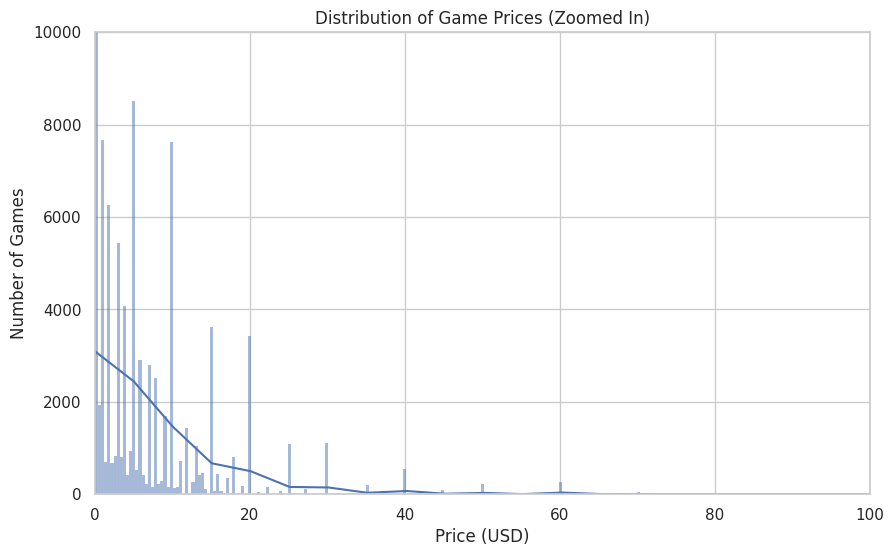

In [ ]:
plt.figure(figsize=(10,6))
sns.histplot(data=steam_df, x='price', kde=True)
plt.title('Distribution of Game Prices (Zoomed In)')
plt.xlabel('Price (USD)')
plt.ylabel('Number of Games')

# Set the x-axis limit from 0 to 1000
plt.xlim(0, 100)

# Set the y-axis limit (e.g., up to 5000 for demonstration)
plt.ylim(0, 10000)

plt.show()

**Takeaway:**  
This bar graph illustrates the distribution of game prices, focusing on the range between 0 and 100. The majority of games are priced below 5, indicating that low-cost or free games dominate the market. As the price increases, the frequency of games drops significantly, with very few games priced above 20. This trend reflects consumer preferences for affordable games and the industry's strategy of offering games at competitive prices to attract a broader audience.


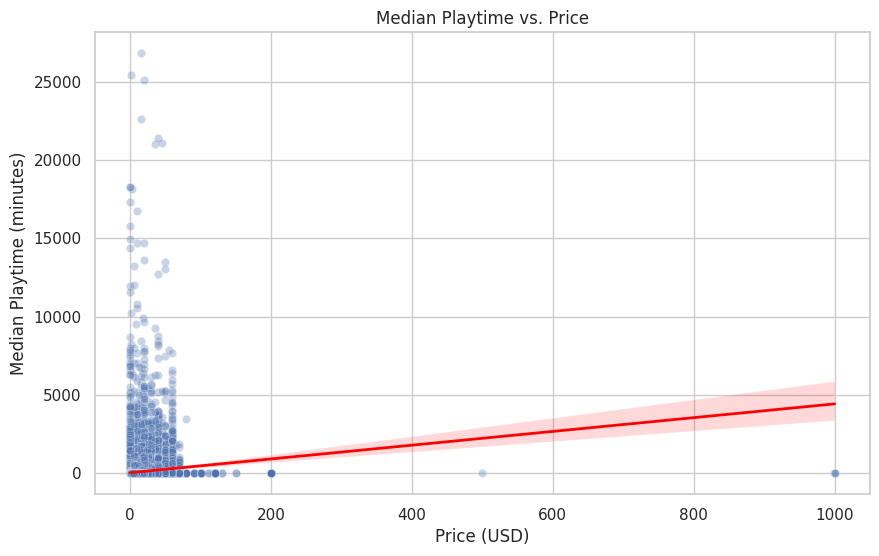

In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=steam_df, x='price', y='median_playtime_forever', alpha=0.3)
sns.regplot(data=steam_df, x='price', y='median_playtime_forever', scatter=False, color='red', line_kws={'linewidth':2})
plt.title('Median Playtime vs. Price')
plt.xlabel('Price (USD)')
plt.ylabel('Median Playtime (minutes)')
plt.show()

**Takeaway:**
This scatterplot gives the impression that lower-priced games tend to foster higher median playtime. The cluster of points at the lower end of the price axis corresponds to a range of notably higher play durations, suggesting that making a game more affordable could potentially entice players to engage with it for longer periods.


In [ ]:
bins = [-0.01, 1, 10, 30, float('inf')]
labels = ['Free', 'Budget', 'Moderate', 'Premium']

# Reapply the categorization
steam_df['price_category'] = pd.cut(steam_df['price'], bins=bins, labels=labels)

**Rationale for Categorizing Prices:**

Handling raw price values can be challenging due to floating-point precision issues and the sheer variety of price points. By grouping prices into categorical bins, we achieve several benefits:

1. **Enhanced Interpretability:**  
   Instead of dealing with a large range of similar values (e.g., \$4.99 vs \$5.00), categorization simplifies these values into meaningful labels such as "Budget" or "Moderate." This makes it easier to communicate findings to stakeholders.

2. **Reduced Noise:**  
   Minor differences in price (like \$9.99 vs \$10.00) often have little practical difference in terms of player behavior. Aggregating prices into ranges reduces the impact of tiny variations that would otherwise complicate analyses.

3. **Improved Data Visualization:**  
   Visualizing categories is more intuitive and visually clear. Bar charts or box plots of categorical price groups are easier to interpret than trying to discern patterns from many closely clustered price points.

4. **Facilitated Statistical Analysis:**  
   Converting a continuous variable into categories can make it easier to apply certain non-parametric statistical tests or to segment the dataset into groups for comparative studies.

Overall, categorizing prices into logical bands helps streamline analysis, enhance clarity, and reduce the complexity introduced by floating-point precision and minor price variations.

In [ ]:
# steam_df.drop(columns=['price'], inplace=True)
print(steam_df['price_category'].value_counts())
print(steam_df['price_category'].isna().sum())

price_category
Budget      48592
Free        23006
Moderate    16467
Premium      1733
Name: count, dtype: int64
0



In this section, we conducted exploratory data analysis and feature engineering on the `price` column. The `price` column represents the cost of each game in USD, which is a critical factor influencing player purchasing decisions and engagement. To gain insights into its distribution and impact, we performed a thorough analysis, starting with an examination of the price range, summary statistics, and potential outliers.

After the initial EDA, we implemented a key transformation: converting the continuous `price` column into a categorical feature (`price_category`). This transformation simplifies analysis by grouping prices into logical bins, such as "Free," "Budget," "Moderate," and "Premium." This approach helps to address the wide variance in pricing and enables better exploration of relationships between price categories and other variables like playtime, achievements, and success metrics.

Through this analysis, we aim to uncover patterns in pricing strategies and their impact on player engagement and game performance.


## 4.9 Pre Modeling Column dropping

For our modeling, we are removing the following columns from the dataset:

1. **`app_id`, `name`, `packages`, `developer`, `publisher`**:  
   These columns act as identifiers and provide no meaningful information for predictive modeling. Since they don't contribute to the feature set, they are redundant for our purposes.

2. **`median_playtime_forever`**:  
   This column represents a post-release feature, which is generated based on player behavior after the game's release. Since we are predicting game success using pre-release features, this column is excluded to prevent data leakage.

3. **`tags`**:  
   The `tags` column overlaps significantly with the `genre` and `categories` columns, which we are retaining in our dataset. Including it would introduce redundancy without adding new information.

By dropping these columns, we ensure that our dataset contains only relevant pre-release features, improving the clarity and reliability of our model.

In [ ]:
print("Original shape:", steam_df.shape)

columns_to_drop = [
    'app_id',
    'name',
    'packages',
    'developers',
    'publishers',
    'median_playtime_forever',
    'tags'
]

steam_df = steam_df.drop(columns_to_drop, axis=1)

print("New shape:", steam_df.shape)

Original shape: (89798, 57)
New shape: (89798, 50)


# Part 5: Model Setup

In this section, we prepared our dataframe for modeling in the next section. We began with a train-test split of our data, followed by encoding necessary columns. After careful consideration, we ultimately decided against implementing scaling, SMOTE, or PCA on our dataframe. The detailed reasoning behind each of these decisions is explained in the following subsections.

## 5.1 Train Test Split

For our first step in model setup, we performed a train-test split on steam_df with `is_successful` as our success metric. We performed this first to prevent data leakage later on when doing more model setup such as scaling and encoding. Next, given the class imbalance in our dataset where successful games are the minority class, we used an 80-20 split ratio and stratified based on our target variable to maintain the same class distribution in both sets, ensuring our test set accurately represents the original data distribution. Finally, we also set `random_state=42` to ensure reproducibility of the split, allowing consistent results across different runs.

In [ ]:
# Separate features (X) and target (y)
X = steam_df.drop('is_successful', axis=1)
y = steam_df['is_successful']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Print summary of the split
print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("\nClass distribution in training set:")
print(y_train.value_counts(normalize=True))
print("\nClass distribution in test set:")
print(y_test.value_counts(normalize=True))

Training set shape: (71838, 49)
Testing set shape: (17960, 49)

Class distribution in training set:
is_successful
0    0.874899
1    0.125101
Name: proportion, dtype: float64

Class distribution in test set:
is_successful
0    0.874889
1    0.125111
Name: proportion, dtype: float64


##5.2 Encoding

Next, upon inspection of our dataframe, we identified columns containing non-binary data. We needed to examine these columns closely to determine which would require encoding for our machine learning algorithms.

In [ ]:
# Exclude the columns we predict are not binary
non_binary_cols = ['language_support_tier', 'windows_only', 'price_category']

# Check all other columns
for col in X_train.columns:
    if col not in non_binary_cols:
        unique_vals = sorted(X_train[col].unique())
        if set(unique_vals) != {0, 1}:
            print(f"{col}: {unique_vals}")

Our initial manual inspection of the dataframe identified three potentially non-binary columns: `language_support_tier`, `windows_only`, and `price_category`. To verify this assumption and check for any additional non-binary columns, we performed a systematic examination of our dataset. The analysis confirmed our initial assessment - these three columns were indeed the only non-binary variables in our dataframe.

In [ ]:
# Further examine the three non-binary columns by looking at unique values in each column
print("Language Support Tier values:")
print(X_train['language_support_tier'].unique())
print("\nWindows Only values:")
print(X_train['windows_only'].unique())
print("\nPrice Category values:")
print(X_train['price_category'].unique())

Language Support Tier values:
[1 3 2 4 5]

Windows Only values:
<BooleanArray>
[True, False]
Length: 2, dtype: boolean

Price Category values:
['Budget', 'Free', 'Moderate', 'Premium']
Categories (4, object): ['Free' < 'Budget' < 'Moderate' < 'Premium']


Based on our examination of the three columns, we can summarize our encoding decisions as follows:

For `language_support_tier`, we observed values ranging from 1 to 5, representing different tiers of language support. Since these values were already in a meaningful ordinal format (1 through 5), no additional encoding was necessary. The inherent numerical ordering perfectly captured the hierarchical nature of language support levels.

The `windows_only` column contained boolean values (True/False), making it a straightforward binary variable. A simple label encoding sufficed here, converting True to 1 and False to 0. This transformation maintained the binary nature of the data while making it suitable for our machine learning algorithms.

Looking at `price_category`, we found four distinct categories: 'Free', 'Budget', 'Moderate', and 'Premium'. While these categories might appear to have a natural order, treating them as ordinal could impose incorrect assumptions about the relationship between categories. For instance, the price difference between 'Free' and 'Budget' might not be the same as between 'Budget' and 'Moderate'. Therefore, one-hot encoding was the most appropriate choice, as it would create separate binary columns for each category without imposing any ordinal relationships.

In [ ]:
# Convert windows_only to numeric (0/1)
X_train['windows_only'] = X_train['windows_only'].astype(int)
X_test['windows_only'] = X_test['windows_only'].astype(int)

# One-hot encode price_category
price_encoded_train = pd.get_dummies(X_train['price_category'], prefix='price')
price_encoded_test = pd.get_dummies(X_test['price_category'], prefix='price')

# Drop the original price_category column and add the encoded columns
X_train = X_train.drop('price_category', axis=1)
X_test = X_test.drop('price_category', axis=1)

X_train = pd.concat([X_train, price_encoded_train], axis=1)
X_test = pd.concat([X_test, price_encoded_test], axis=1)

# Verify our encoding
print("\nWindows Only unique values after encoding:")
print(X_train['windows_only'].unique())
print("\nNew price category columns:")
print([col for col in X_train.columns if col.startswith('price_')])


Windows Only unique values after encoding:
[1 0]

New price category columns:
['price_Free', 'price_Budget', 'price_Moderate', 'price_Premium']


In this section, we performed neccessary tasks that had be done before our modeling began. This included encoding non-numerical columns, scaling non-binary columns, performing a stratified train test split on our dataset to deal with class imbalance. And finally SMOTE to address the class imblanace before moedling even began.

##5.3 Scaling Decision

After examining our preprocessed features, scaling was determined to be unnecessary for our dataset. Our features were limited to:
- Binary variables (0/1), including:
  * Encoded `windows_only` variable
  * One-hot encoded price categories (`price_Free`, `price_Budget`, `price_Moderate`, `price_Premium`)
- One ordinal variable: language support tier (range 1-5)

Scaling is typically necessary in machine learning when:
- Features have significantly different ranges (e.g., age 0-100 vs. income 0-1,000,000)
- Features are continuous variables with wide ranges
- We want to normalize the influence of different features

In our case, the binary variables were already effectively scaled (0/1), and our only non-binary feature, the language support tier (1-5), was already in a reasonable range that wouldn't dominate other features. Therefore, applying scaling techniques like StandardScaler or MinMaxScaler would not have provided any meaningful benefit to our model's performance.

##5.4 SMOTE Decision

After careful consideration of our dataset characteristics and modeling requirements, we decided against implementing SMOTE for handling our class imbalance. Our dataset's high-dimensional feature space made synthetic data generation particularly risky, as SMOTE could create unrealistic or overlapping samples that don't accurately represent the true decision boundaries. This concern was further amplified by the presence of outliers in our minority class (success). SMOTE's interpolation mechanism could potentially amplify these outliers by generating synthetic examples around them, leading to a distorted representation of what constitutes a successful game.

The risk of overfitting was another significant concern. While SMOTE can be effective in simpler datasets, our complex feature relationships and noisy minority class distribution meant that synthetic examples might lead the model to learn patterns that don't generalize well to real-world data. Additionally, implementing SMOTE would have introduced unnecessary computational overhead given our dataset's size and complexity, without guaranteed performance improvements.

Instead, we addressed the class imbalance using class weights in our modeling approach (using `class_weight='balanced'`). This method allowed us to account for class imbalance while preserving the integrity of our original data distribution. By working with actual data points rather than synthetic ones, we maintained better interpretability and reduced the risks associated with artificial data generation. This approach aligned better with our goal of building a robust and reliable model for predicting game success.

##5.5 PCA Decision

After examining our dataframe, we determined that PCA was also not suitable for our analysis. As mentioned previously, our dataframe consisted entirely of binary features: 48 integer (0/1) indicators and 4 one-hot encoded price tiers (Free, Budget, Moderate, Premium), with only a single ordinal feature (language_support_tier) ranging from 1 to 5. PCA is most effective with continuous variables, which was not the case for our data. Each column represented distinct, non-overlapping categories, such as game genres and features, all of which were already one-hot encoded. These features, like `Action`, `Adventure`, and `Casual`, embodied fundamentally different concepts, thus limiting the advantage of finding linear combinations through PCA.

Moreover, the interpretability of our model was a key consideration. Each feature had clear business meaning, and transforming them into principal components would have complicated the explanation of factors driving game success. Stakeholders required insights into which specific features impacted success, making direct use of the original features more beneficial.

Consequently, we opted to retain our original features, as they represented a well-structured and interpretable set where each variable had a distinct business meaning. The binary nature of most variables meant that PCA's assumptions about linear relationships between continuous variables didn't apply well, reinforcing our decision to avoid dimensionality reduction through PCA.

# Part 6: Modeling


##6.1 Baseline Model

In [ ]:
# Create the dummy classifier
# strategy='most_frequent' means it will always predict the most common class
baseline_model = DummyClassifier(strategy='most_frequent')

# Fit and predict
baseline_model.fit(X_train, y_train)
y_pred = baseline_model.predict(X_test)

# Evaluate
print("Baseline Model Accuracy:", accuracy_score(y_test, y_pred))
print("\nDetailed Classification Report:")
report_dict = classification_report(y_test, y_pred, zero_division=0, digits=2, output_dict=True)

# Print only the class-specific metrics
print("              precision    recall  f1-score   support")
print(f"           0      {report_dict['0']['precision']:.2f}      {report_dict['0']['recall']:.2f}      {report_dict['0']['f1-score']:.2f}     {report_dict['0']['support']:.0f}")
print(f"           1      {report_dict['1']['precision']:.2f}      {report_dict['1']['recall']:.2f}      {report_dict['1']['f1-score']:.2f}     {report_dict['1']['support']:.0f}")

Baseline Model Accuracy: 0.8748886414253898

Detailed Classification Report:
              precision    recall  f1-score   support
           0      0.87      1.00      0.93     15713
           1      0.00      0.00      0.00     2247


For our baseline model, we decided to create a dummy classifier that just predicts unsuccessful/0 for every single game in our dataset. This is due to the fact that our dataset has a large class imbalance, with around 88% of games being unsuccessful as most of them have never even been played.

As you can see from our dummy classifier results, we get the expected around 0.88 baseline accuracy by just predicting unsuccessful.

For our subsequent models, we will attempt to improve on the baseline model by addressing the class imbalance issues. We will mainly measure success from now on using the f1-score of our success class, as this means we have good recall and precision in our success class. This is because we would rather predict successful games correctly as this is what our project is mainly about.

##6.2 Random Forest

We decided to begin our modeling with Random Forest due to its well-suited characteristics for our dataset. Random Forest was a powerful ensemble method that built multiple decision trees and merged them to produce a more accurate and stable prediction. It was particularly effective with binary and categorical features, aligning well with our dataset's structure. The model's ability to handle complex interactions between features without extensive preprocessing made it an attractive option for our initial exploration. Additionally, Random Forest provided feature importance, offering insights into which features contributed most to the model's predictions. This interpretability was valuable for understanding the factors influencing game success. Given these strengths, Random Forest served as an excellent starting point for our analysis, providing a robust benchmark against which we could compare other models like XGBoost.

In configuring our Random Forest model, we selected hyperparameters aimed at effectively addressing the class imbalance inherent in our dataset. By setting class_weight to 'balanced', we ensure that the model pays equal attention to both successful and unsuccessful game predictions, automatically adjusting weights inversely proportional to class frequencies. This is crucial since we decided against using SMOTE for synthetic oversampling. With n_estimators set to 50, we have a manageable number of trees that allow for swift iterations and initial evaluations. The max_depth of 10 provides a reasonable limit to prevent overfitting while enabling the model to capture complex patterns. Lastly, the random_state is set to 42, ensuring reproducibility of our results. These choices set a solid foundation for our initial exploration with Random Forest, focusing on improving the F1-score of successful game predictions.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Initialize the model with our chosen hyperparameters
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)

# Fit the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Print the classification report
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.81      0.87     15713
           1       0.33      0.66      0.44      2247

    accuracy                           0.79     17960
   macro avg       0.64      0.74      0.66     17960
weighted avg       0.87      0.79      0.82     17960



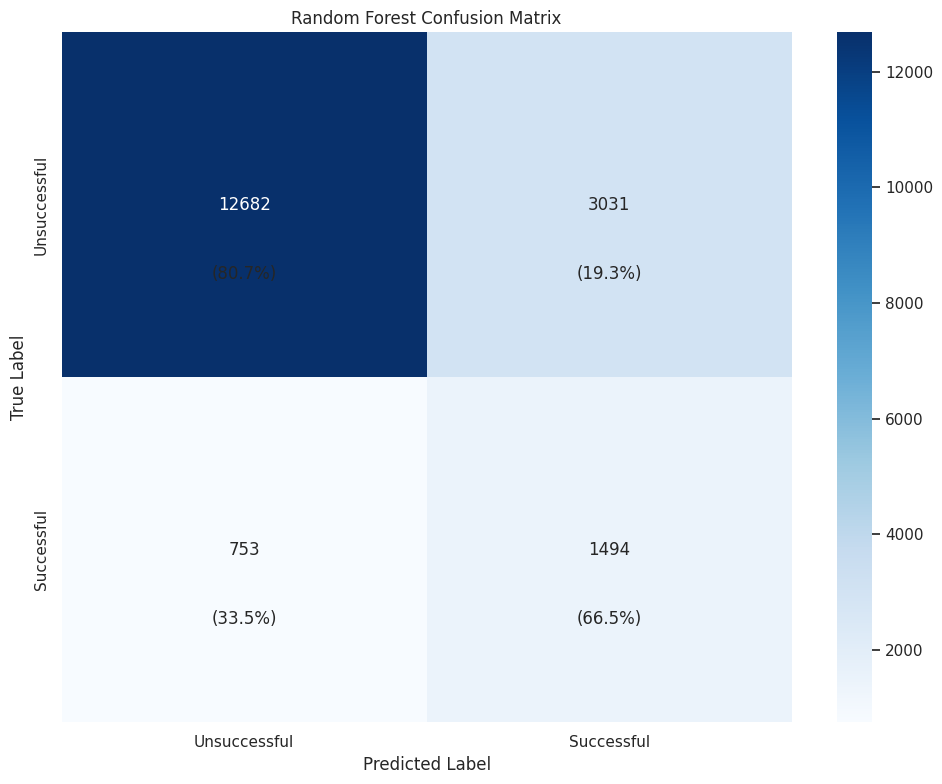

In [ ]:
# Get confusion matrix values
cm = confusion_matrix(y_test, y_pred)

# Create labels
class_labels = ['Unsuccessful', 'Successful']

# Calculate percentages for each row (true label)
row_percentages = cm / cm.sum(axis=1)[:, np.newaxis] * 100

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)

plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

# Add percentage annotations (row-wise)
for i in range(2):
    for j in range(2):
        plt.text(j+0.5, i+0.7, f'({row_percentages[i,j]:.1f}%)',
                ha='center', va='center')

plt.tight_layout()
plt.show()

From the classification report and confusion matrix visualization above, we can see that while we've sacrificed some overall accuracy, we've achieved our primary goal of better identifying successful games (F1-score 0.44). The model is now making meaningful predictions for both classes, rather than just defaulting to the majority class. The model correctly identifies 66% of successful games (recall) but with lower precision (33%), meaning it tends to overpredict success, suggesting we should focus on reducing these false positives.

Next, we decided to perform hyperparameter tuning to evaluate whether our random forest model's performance could be enhanced. Given our constraints, we initially limited our search to 9 combinations with 5-fold cross-validation. This approach allows us to quickly ascertain the impact of hyperparameter adjustments while preserving time to explore different models in the future. Importantly, we also used F1 Score as our scoring metric as our goal is to improve that.

For our hyperparameter tuning, we tested:

1. Number of Trees (n_estimators):
* **Tested Values:** [50, 100, 200]
* **Purpose:** Controls how many decision trees are built in the random forest
* **Consideration:** More trees generally improve performance but increase training time

2. Tree Depth (max_depth):
* **Tested Values:** [5, 10, 20]
* **Purpose:** Limits how deep each individual tree can grow
* **Consideration:** Deeper trees can model more complex patterns but also risk overfitting

3. Class Weights (class_weight):
* **Used Value:** 'balanced'
* **Purpose:** Automatically adjusts weights inversely proportional to class frequencies
* **Consideration:** Ensures the model pays equal attention to both classes, particularly useful for imbalanced data

4. Cross-Validation:
* **Configuration:** 5-fold cross-validation
* **Scoring Metric:** F1-score
* **Purpose:** F1-score balances precision and recall, providing a better measure of model performance on imbalanced data than accuracy

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],  # Slightly increased range
    'max_depth': [5, 10, 20],        # Wider range
    'class_weight': ['balanced'],
    'random_state': [42]
}

# Instantiate the random forest model
random_forest_model = RandomForestClassifier()

# Define the grid search object
grid_search = GridSearchCV(
    random_forest_model,
    param_grid,
    scoring='f1',     # Changed from accuracy to f1
    cv=5,
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print the best parameters and cross validation score
print("Best parameters:", grid_search.best_params_)
best_model = grid_search.best_estimator_
test_score = f1_score(y_test, best_model.predict(X_test))
print(f"Test set F1-score: {test_score}")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END class_weight=balanced, max_depth=5, n_estimators=50, random_state=42; total time=   2.2s
[CV] END class_weight=balanced, max_depth=5, n_estimators=50, random_state=42; total time=   1.6s
[CV] END class_weight=balanced, max_depth=5, n_estimators=50, random_state=42; total time=   1.6s
[CV] END class_weight=balanced, max_depth=5, n_estimators=50, random_state=42; total time=   1.8s
[CV] END class_weight=balanced, max_depth=5, n_estimators=50, random_state=42; total time=   1.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100, random_state=42; total time=   2.0s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100, random_state=42; total time=   3.1s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100, random_state=42; total time=   3.1s
[CV] END class_weight=balanced, max_depth=5, n_estimators=100, random_state=42; total time=   3.2s
[CV] END class_weight=balanced, max_depth=5, n_estimat

Our initial grid search explored 9 parameter combinations, varying `n_estimators` ([50, 100, 200]) and `max_depth` ([5, 10, 20]). The best parameters identified were:
* `n_estimators`: 100
* `max_depth`: 10
* `class_weight`: balanced

Despite these optimizations, the best F1-score achieved was 0.439, which was lower than anticipated. Several factors may have contributed to this outcome:
* The 5-fold cross-validation process offered a more realistic, albeit often lower, estimate of model performance
* The previous model's potential overfitting to the training data

To address these challenges and optimize our model efficiently, we adopted a refined approach. Recognizing time constraints and the impracticality of an exhaustive search spanning approximately 96 minutes, we focused on:
* Maintaining `n_estimators` at 100
* Testing `max_depth` values around our best result ([8, 10, 12])
* Introducing single values for additional parameters to assess their impact:
    - `min_samples_split`: 5
    - `min_samples_leaf`: 2
    - `max_features`: 'sqrt'

This refined grid search was designed to be both time-efficient and insightful, providing valuable feedback in a shorter duration of 1-2 minutes.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

# Initialize the RandomForestClassifier
rf = RandomForestClassifier(random_state=42)

# Define the parameter grid based on our best parameters with slight variations
param_grid = {
    'n_estimators': [100],  # Our best value
    'max_depth': [8, 10, 12],  # Exploring around our best value
    'min_samples_split': [5],  # Adding one new parameter
    'min_samples_leaf': [2],   # Adding one new parameter
    'max_features': ['sqrt'],  # Adding one new parameter
    'class_weight': ['balanced'],
    'random_state': [42]
}

# Set up the grid search with 5-fold cross-validation and F1 score as the metric
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1, verbose=2)

# Fit the model
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_}")

# Optionally, evaluate on test set
best_model = grid_search.best_estimator_
test_score = f1_score(y_test, best_model.predict(X_test))
print(f"Test set F1-score: {test_score}")

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best parameters: {'class_weight': 'balanced', 'max_depth': 12, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100, 'random_state': 42}
Best cross-validation F1-score: 0.4448424926757328
Test set F1-score: 0.44727272727272727


From our two hyperparameter tuning attempts above, we could see that our initial grid search explored 9 combinations of n_estimators and max_depth, achieving a best cross-validation F1-score of 0.439 and a test set F1-score of 0.440. In a refined grid search with 3 combinations, we added parameters such as min_samples_split, min_samples_leaf, and max_features. This led to a slight improvement, with a best cross-validation F1-score of 0.445 and a test set F1-score of 0.447.

Despite these efforts, the improvements in F1-score were marginal, suggesting that hyperparameter tuning has reached its limits on this Random Forest model for our dataset. As a result, we decided to do some feature importance exploration and to subsequently explore different model architectures to potentially achieve better predictive performance

Top 10 Most Important Features:
                      feature  importance
               Family Sharing    0.161306
                  Steam Cloud    0.121160
        language_support_tier    0.043686
          has_age_requirement    0.036791
                      VR Only    0.030222
Remote Play (Phone or Tablet)    0.030041
                 windows_only    0.029593
               Steam Workshop    0.029348
                 Multi-player    0.028977
               price_Moderate    0.025876


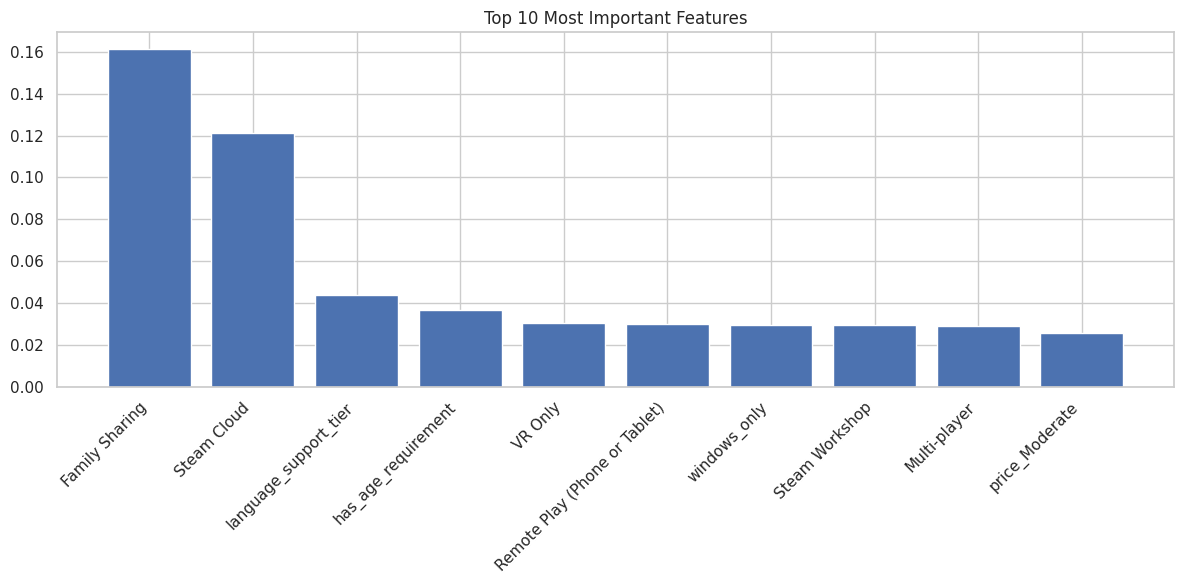

In [ ]:
# Use best mdoel found from grid search
best_rf_model = grid_search.best_estimator_

# Get feature importances from the best Random Forest model
importances = best_rf_model.feature_importances_
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': importances
})

# Sort by importance and display top 10
feature_importance = feature_importance.sort_values('importance', ascending=False)
print("Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Create a bar plot of top 10 features
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:10], feature_importance['importance'][:10])
plt.xticks(rotation=45, ha='right')
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()

The relatively low importance scores (highest being 0.161) suggest that even our most predictive features have limited individual influence on game success. This could explain why our Random Forest model is showing performance limitations around the 0.44 F1-score mark.

Given these insights, we plan to:
1. Implement **XGBoost** with careful hyperparameter tuning to see if it can overcome these limitations
2. If similar performance caps persist, explore alternative models like:
   - **LightGBM**: Known for handling binary features effectively
   - **CatBoost**: Specifically designed for categorical/binary features

These alternative models might better capture the subtle patterns in our binary-heavy feature set, potentially breaking through the current performance ceiling.

##6.3 XG Boost

After conducting our analysis with Random Forest, which achieved a modest F1-score of 0.447, we decided to explore XGBoost (eXtreme Gradient Boosting) due to its suitability for our data characteristics. XGBoost has been recognized for its ability to handle non-linear relationships and manage both numerical and categorical data efficiently, making it a strong candidate for improving our model performance.

In contrast to Random Forest, XGBoost builds trees sequentially using gradient boosting, allowing it to learn from the errors of previous iterations. This approach, coupled with its advanced optimization techniques and regularization features, often results in superior performance, especially in datasets with complex patterns and potential overfitting challenges.

Given these advantages, XGBoost was an ideal choice for our project, offering potential improvements in predictive accuracy while handling the imbalances and nuances present in our dataset. By leveraging XGBoost, we aimed to achieve better classification results compared to our previous attempts.

For our initial XGBoost model, we selected hyperparameters that would provide a balanced starting point while accounting for our dataset's characteristics. We set `n_estimators` to 100 trees as a moderate ensemble size, similar to our successful Random Forest implementation. Given XGBoost's tendency to overfit more easily than Random Forest, we chose a conservative max_depth of 6 (compared to RF's 12) and included regularization through `subsample` and `colsample_bytree` both set to 0.8, meaning each tree would use 80% of the data and features respectively. A `learning_rate` of 0.1 was selected as a standard initial value that balances between convergence speed and accuracy. Most importantly, to address our significant class imbalance (87% unsuccessful, 13% successful), we calculated and set `scale_pos_weight` to the ratio of negative to positive samples, approximately 6.7, which helps the model appropriately weight the minority class during training.

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Calculate the scale_pos_weight based on class distribution
scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])  # ratio of negative to positive samples

# Initialize XGBoost classifier with initial parameters
xgb = XGBClassifier(
    n_estimators=100,      # Similar to RF, moderate number of trees
    max_depth=6,           # Starting with a moderate depth to prevent overfitting
    learning_rate=0.1,     # Standard initial learning rate
    subsample=0.8,         # Using 80% of data for each tree to reduce overfitting
    colsample_bytree=0.8,  # Using 80% of features for each tree
    random_state=42,
    scale_pos_weight=scale_weight  # Adjusting for class imbalance (approximately 87/13 ≈ 6.7)
)

# Fit the model
xgb.fit(X_train, y_train)

# Make predictions and evaluate
y_pred = xgb.predict(X_test)
initial_f1 = f1_score(y_test, y_pred)
print(f"Initial XGBoost F1-score: {initial_f1}")

Initial XGBoost F1-score: 0.44376135252200644


Next, we decided to perform hyperparameter tuning to evaluate whether our XGBoost model's performance could be enhanced. Given our constraints, we initially limited our search to 24 combinations with 3-fold cross-validation. This approach allowed us to quickly assess the impact of hyperparameter adjustments while preserving time to explore different models in the future. Importantly, we used the F1 score as our scoring metric, as our goal was to improve this metric.

- **Tree Depth (max_depth):**
  - **Tested Values**: [4, 6, 8]
  - **Purpose**: Limits how deep each individual tree can grow
  - **Consideration**: Deeper trees can model more complex patterns but also risk overfitting

- **Learning Rate (learning_rate):**
  - **Tested Values**: [0.01, 0.1]
  - **Purpose**: Determines the step size at each iteration
  - **Consideration**: Smaller values allow for more gradual learning, potentially improving accuracy

- **Number of Trees (n_estimators):**
  - **Tested Values**: [100, 200]
  - **Purpose**: Controls how many decision trees are built in the ensemble
  - **Consideration**: More trees generally improve performance but increase training time

- **Subsampling (subsample):**
  - **Tested Values**: [0.8, 1.0]
  - **Purpose**: Fraction of the training data used in each boosting round
  - **Consideration**: Values less than 1.0 introduce randomness, helping to prevent overfitting

- **Class Weight (scale_pos_weight):**
  - **Calculated Value**: Ratio of negative to positive samples in the training set
  - **Purpose**: Adjusts for class imbalance by weighting classes inversely proportional to their frequencies
  - **Consideration**: Helps the model focus on the minority class in imbalanced datasets

- **Cross-Validation:**
  - **Configuration**: 3-fold cross-validation
  - **Scoring Metric**: F1-score
  - **Purpose**: F1-score balances precision and recall, providing a better measure of model performance on imbalanced data than accuracy

This parameter setup aimed to find a balanced model capable of effectively handling complexity and diversity within the dataset while remaining efficient in execution time.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import f1_score

# Calculate scale_weight for class imbalance
scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1])

# Define parameter grid - keeping it focused for quick execution
param_grid = {
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200],
    'subsample': [0.8, 1.0]
}

# Initialize XGBoost with fixed parameters
xgb = XGBClassifier(
    random_state=42,
    scale_pos_weight=scale_weight,
    colsample_bytree=0.8
)

# Perform grid search with 3-fold cross-validation
grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=2
)

# Fit the grid search
grid_search.fit(X_train, y_train)

# Print results
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1-score: {grid_search.best_score_:.4f}")

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_f1 = f1_score(y_test, y_pred)
print(f"Test set F1-score: {test_f1:.4f}")

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'n_estimators': 100, 'subsample': 0.8}
Best cross-validation F1-score: 0.4435
Test set F1-score: 0.4512


Despite our hyperparameter tuning on XGBoost, the performance improvements were marginal, confirming the presence of a performance cap for tree-based models for our dataframe that we hypothesized above.

Given these insights, as mentioned in the random forest section, we planned to explore alternative models like:

1. **LightGBM**: Known for handling binary features effectively
2. **CatBoost**: Specifically designed for categorical/binary features

These models might better capture the subtle patterns in our binary-heavy feature set, potentially breaking through the current performance ceiling.

##6.4 Light GBM

After exploring Random Forest and XGBoost models, we decided to implement LightGBM for several strategic reasons:

1. **Binary Feature Handling**: LightGBM excels at efficiently processing binary features, which are prevalent in our dataset.

2. **Computational Efficiency**: With its leaf-wise growth strategy, LightGBM can achieve higher accuracy using fewer leaves than level-wise approaches, offering faster training times.

3. **Memory Optimization**: LightGBM's histogram-based algorithm typically requires less memory, allowing for exploration of more complex model configurations.

4. **Hypothetical Performance Improvement**: While previous models like Random Forest and XGBoost have reached a similar performance ceiling, LightGBM's unique approach to tree growth and feature handling may hypothetically enable it to surpass these limitations. This could lead to better generalization and predictive power on our dataset.

The baseline model implementation with LightGBM aims to assess its potential to break through the performance constraints observed with other tree-based models. Should this baseline prove promising, it will serve as a foundation for further tuning and optimization efforts.

In [ ]:
import warnings
import logging
import lightgbm as lgb
from sklearn.metrics import f1_score, classification_report
import pandas as pd

# Suppress warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Suppress LightGBM info messages
lgb_logger = logging.getLogger('lightgbm')
lgb_logger.setLevel(logging.ERROR)

# Calculate class weights
scale_weight = len(y_train[y_train == 0]) / len(y_train[y_train == 1])

# Initialize LightGBM with basic parameters
baseline_lgb = lgb.LGBMClassifier(
    random_state=42,
    scale_pos_weight=scale_weight,
    n_jobs=-1
    # Using default parameters for everything else
)

# Fit the model
baseline_lgb.fit(X_train, y_train)

# Make predictions
y_pred = baseline_lgb.predict(X_test)

# Evaluate
baseline_f1 = f1_score(y_test, y_pred)
print("Baseline LightGBM Results:")
print(f"F1 Score: {baseline_f1:.4f}")
print("\nDetailed Classification Report:")
print(classification_report(y_test, y_pred))

# Quick feature importance check
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': baseline_lgb.feature_importances_
})
print("\nTop 10 Most Important Features:")
print(feature_importance.sort_values('importance', ascending=False).head(10))

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 8987, number of negative: 62851
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.142938 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 108
[LightGBM] [Info] Number of data points in the train set: 71838, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.125101 -> initscore=-1.944988
[LightGBM] [Info] Start training from score -1.944988
Baseline LightGBM Results:
F1 Score: 0.4379

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.78      0.86     15713
           1       0.32      0.72      0.44      2247

    accuracy                           0.77     17960
   macro avg       0.63      0.75      0.65     17960
weighted avg   

From this baseline LightGBM model, we saw that it similarly achieved an F1 score of 0.44 on our success class, which was exactly the same as Random Forest and XGBoost pre-hyperparameter tuning. Thus, we decided not to perform hyperparameter tuning here as it seemed much the same compared to the previous two models.

More broadly speaking, it seemed these ensemble models were effectively getting capped around this point, suggesting that performance could not go higher without either better data, better data preprocessing, or better feature engineering. Another option we considered was that we needed to go in a completely different direction with, for example, neural networks. We discuss these other options in more detail below.

##6.5 Neural Network Decision

Having observed consistent performance limitations across three ensemble methods (Random Forest, XGBoost, and LightGBM), we considered implementing neural networks. While neural networks offered sophisticated capabilities in complex pattern recognition and automatic feature learning, these advantages weren't compelling for our specific case. Our ensemble methods already effectively handled non-linear patterns and feature interactions through their tree structures. Additionally, while neural networks excel with very large datasets, our dataset of approximately 90,000 rows wasn't large enough to leverage these benefits effectively.

More importantly, the drawbacks were significant. Neural networks typically required substantially more data than we had to outperform ensemble methods, and with our relatively small dataset, overfitting would have been a major concern. Furthermore, neural networks would have sacrificed the clear interpretability we had with our ensemble methods, making it harder to understand what drives game success - a crucial aspect for providing actionable insights. Given these considerations, we decided not to pursue neural networks and instead focused on improving our current approach through enhanced data quality and feature engineering.

# Part 7: Conlcusion

## Key Takeaways and Modeling Results

### Data Science Challenges in Real-World Applications
• Working with real-world data presented numerous unexpected challenges, from basic data loading issues (CSV vs. JSON) to complex missing value patterns in the Steam dataset

• Significant class imbalance toward unsuccessful games required us to carefully reconsider and pivot our success metrics

• The complexity of the data required substantial preprocessing and creative feature engineering approaches

### Model Performance and Limitations
• Our models (Random Forest, XGBoost, and LightGBM) consistently reached a performance ceiling with an F1 score of 0.44

• This moderate performance actually represents a meaningful achievement given the inherent complexity of predicting game success

• The ceiling likely reflects several fundamental challenges:
    • Inherent unpredictability in game success
    • Missing crucial factors like marketing efforts and advertising budgets
    • High variability in user preferences and market conditions

### Feature Importance Insights
• Language support emerged as a consistently important feature across models (particularly high in LightGBM and third-highest in Random Forest)

• No single feature showed overwhelming correlation with success, suggesting game success depends on multiple factors working in concert

• This aligns with the intuitive understanding that game success is multifaceted

### Model Selection Considerations
• After careful evaluation, we determined that more complex approaches like neural networks wouldn't necessarily improve performance given our data constraints

• The consistent performance across different ensemble methods suggested our limitations were more data-related than model-related

## Future Work and Potential Improvements

• Data and Feature Engineering: Explore NLP techniques for text data, enhance feature interactions, and consider alternative success metrics

• Sampling Techniques: Compare SMOTE with current class weight balancing to address data imbalance

• External Data Integration: Incorporate additional data like marketing, social media sentiment, and industry trends to enrich the dataset

• Real-World Complexity Acknowledgement: Recognize the inherent unpredictability and randomness in game success, emphasizing that many influential factors were outside our dataset's scope

## Overall Experience

Overall, This project provided valuable real-world experience in handling messy data and building predictive models, highlighting both the challenges and iterative nature of data science work. Despite the limitations in our predictions, we gained practical insights into the complexities of working with real datasets and the importance of careful feature engineering and model selection.